In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from xgboost import plot_importance
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split,LeaveOneOut
import seaborn as sns
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from sklearn import metrics
from sklearn.impute import SimpleImputer

In [2]:
#导入数据
#对缺失值进行填补
train_X = np.empty(shape=[0,268],dtype=float)
train_Y = []
filePath = 'D:\Temple\jupyter_psychology\Shen268\ROI_FC_r_per\session1'
filePath_list = os.listdir(filePath)
cnt_nan = 0
for fp in filePath_list:
    fp_a = ['D:\Temple\jupyter_psychology\Shen268\ROI_FC_r_per\session1\\'+fp,'D:\Temple\jupyter_psychology\Shen268\ROI_FC_r_per\session2\\'+fp,'D:\Temple\jupyter_psychology\Shen268\ROI_FC_r_per\session3\\'+fp]
    train_Y = np.append(train_Y,[0,1,2],axis=0)
    for i in range(3):
        data =  np.loadtxt(fp_a[i])
        
        #数据去中心化，感觉没必要
        #data = data.apply(lambda x:(x - x.mean()))
        #PCA降维，二维矩阵变一维
        pca_alg = PCA(n_components = 1, whiten=True)
        data = pca_alg.fit_transform(data)
        data = data.ravel()
        train_X = np.append(train_X,[data],axis=0)
        #print(data)
        #print(train_X)

In [3]:
# 数据划分
train_x = train_X[:159]
train_y = train_Y[:159]
test_x = train_X[159:]
test_y = train_Y[159:]

# 数据标准化 特征标度
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)
dtrain = xgb.DMatrix(train_x,label=train_y)
ddtrain = xgb.DMatrix(train_x)
dtest = xgb.DMatrix(test_x,label=test_y)
ddtest = xgb.DMatrix(test_x)

In [4]:
# booster:
param = {'booster':'gbtree',
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',#,'auc'
        'num_class':3,
        'max_depth':5,
        'lambda':10,
        'subsample':0.8,
        'colsample_bytree':0.9,
        'min_child_weight':4,
        'eta': 0.01,
        'seed':0,
        'nthread':8,
        'gamma':0.6,
        'reg_alpha': 1e-05,
        'learning_rate' : 0.1}

# 最佳迭代次数cv_res.shape[0]
watchlist = [(dtrain,'train'),(dtest,'test')]

best_depth = 0
best_score = 0
for max_depth in range(3,10):
    for min_child_weight in range(3,10):
        param = {'booster':'gbtree',
            'objective': 'multi:softmax',
            'eval_metric': 'mlogloss',#,'auc'
            'num_class':3,
            'max_depth':max_depth,
            'lambda':10,
            'subsample':0.8,
            'colsample_bytree':0.9,
            'min_child_weight':min_child_weight,
            'eta': 0.01,
            'seed':0,
            'nthread':8,
            'gamma':0.6,
            'reg_alpha': 1e-05,
            'learning_rate' : 0.1}
        cv_res= xgb.cv(param,dtrain,num_boost_round=2000,early_stopping_rounds=30,nfold=5, metrics='mlogloss',show_stdv=True)
        bst=xgb.train(param,dtrain,early_stopping_rounds=10, num_boost_round=cv_res.shape[0],evals=watchlist)
        pred_test_y = bst.predict(ddtest)
        score = accuracy_score(test_y, pred_test_y)
        print(score)
        if score > best_score:
            best_score = score
            best_depth = max_depth
            best_weight = min_child_weight
            #print(best_depth)
# booster:
param = {'booster':'gbtree',
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',#,'auc'
        'num_class':3,
        'max_depth':best_depth,
        'lambda':10,
        'subsample':0.8,
        'colsample_bytree':0.9,
        'min_child_weight':best_weight,
        'eta': 0.01,
        'seed':0,
        'nthread':8,
        'gamma':0.6,
        'reg_alpha': 1e-05,
        'learning_rate' : 0.1}
cv_res= xgb.cv(param,dtrain,num_boost_round=2000,early_stopping_rounds=30,nfold=5, metrics='mlogloss',show_stdv=True)
bst=xgb.train(param,dtrain,early_stopping_rounds=10, num_boost_round=cv_res.shape[0],evals=watchlist)
pred_test_y = bst.predict(ddtest)
pred_train_y = bst.predict(ddtrain)

result1 = metrics.classification_report(test_y, pred_test_y)
print("Classification Report(test):", )
print(result1)
result2 = metrics.classification_report(train_y, pred_train_y)
print("Classification Report(train):", )
print(result2)

print ('Train Accuracy: %.4f' % metrics.accuracy_score(train_y,pred_train_y))
print ('Test Accuracy: %.4f' % metrics.accuracy_score(test_y,pred_test_y))

[0]	train-mlogloss:1.07015	test-mlogloss:1.08401
0.47619047619047616
[0]	train-mlogloss:1.07083	test-mlogloss:1.08430
[1]	train-mlogloss:1.04202	test-mlogloss:1.07900
[2]	train-mlogloss:1.01890	test-mlogloss:1.07713
[3]	train-mlogloss:0.99667	test-mlogloss:1.08017
[4]	train-mlogloss:0.96999	test-mlogloss:1.06864
[5]	train-mlogloss:0.94559	test-mlogloss:1.06223
[6]	train-mlogloss:0.92479	test-mlogloss:1.05318
[7]	train-mlogloss:0.90315	test-mlogloss:1.04937
[8]	train-mlogloss:0.88174	test-mlogloss:1.04860
[9]	train-mlogloss:0.86050	test-mlogloss:1.04405
[10]	train-mlogloss:0.83937	test-mlogloss:1.04269
0.42857142857142855
[0]	train-mlogloss:1.07211	test-mlogloss:1.08540
0.47619047619047616
[0]	train-mlogloss:1.07373	test-mlogloss:1.08465
0.5238095238095238
[0]	train-mlogloss:1.07391	test-mlogloss:1.08335
0.5714285714285714
[0]	train-mlogloss:1.07616	test-mlogloss:1.08442
0.47619047619047616
[0]	train-mlogloss:1.07578	test-mlogloss:1.08249
0.5
[0]	train-mlogloss:1.06716	test-mlogloss:1.0

In [5]:
'''fig,ax = plt.subplots(figsize=(3,6))
xgb.plot_importance(bst, height=0.5, ax=ax,importance_type='cover', max_num_features=20,show_values=False)
plt.show()
bst.get_score(fmap='',importance_type='gain')'''

"fig,ax = plt.subplots(figsize=(3,6))\nxgb.plot_importance(bst, height=0.5, ax=ax,importance_type='cover', max_num_features=20,show_values=False)\nplt.show()\nbst.get_score(fmap='',importance_type='gain')"

[0]	train-mlogloss:1.06716	test-mlogloss:1.10458
[1]	train-mlogloss:1.04068	test-mlogloss:1.10151
[2]	train-mlogloss:1.01324	test-mlogloss:1.06050
[3]	train-mlogloss:0.98631	test-mlogloss:1.07571
[4]	train-mlogloss:0.95822	test-mlogloss:1.06933
[5]	train-mlogloss:0.93567	test-mlogloss:1.06289
[6]	train-mlogloss:0.90965	test-mlogloss:1.04441
[7]	train-mlogloss:0.88911	test-mlogloss:1.06057
[8]	train-mlogloss:0.86777	test-mlogloss:1.06119
[9]	train-mlogloss:0.84859	test-mlogloss:1.04391
[10]	train-mlogloss:0.82814	test-mlogloss:1.05675
[11]	train-mlogloss:0.80873	test-mlogloss:1.05973
[12]	train-mlogloss:0.78924	test-mlogloss:1.07553
[13]	train-mlogloss:0.76902	test-mlogloss:1.05688
[14]	train-mlogloss:0.75320	test-mlogloss:1.04902
[15]	train-mlogloss:0.73825	test-mlogloss:1.05700
0.3333333333333333
[0]	train-mlogloss:1.06795	test-mlogloss:1.08870
[1]	train-mlogloss:1.04318	test-mlogloss:1.08515
[2]	train-mlogloss:1.01653	test-mlogloss:1.04455
[3]	train-mlogloss:0.99166	test-mlogloss:1.0

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


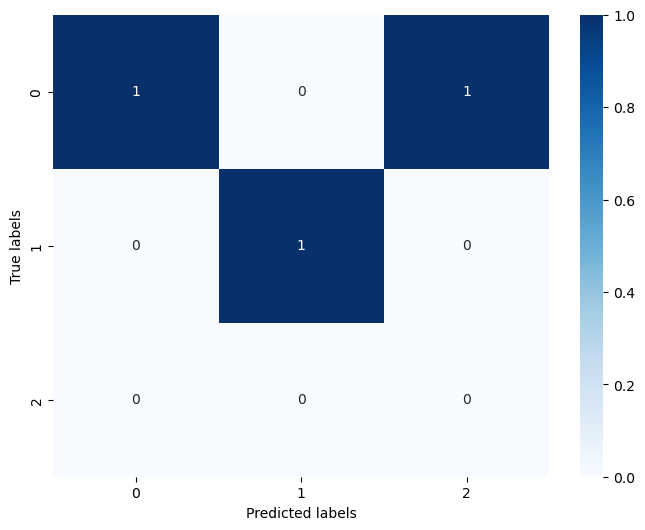

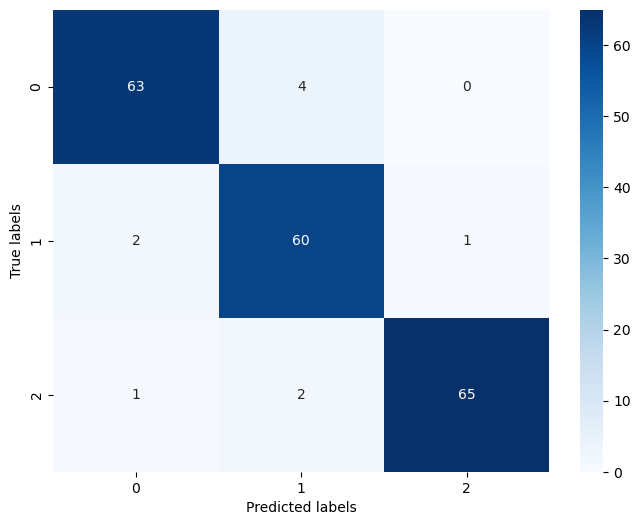

0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
{'medial frontal': 0.11859740236509099, 'frontoparietal': 0.16340682814556654, 'default mode': 0.08598311671469097, 'subcortical-cerebellum': 0.1513890772925328, 'motor': 0.1058253744180812, 'visual I': 0.1322817180226015, 'visual II': 0.1028857806842456, 'visual association': 0.13963070235719047}


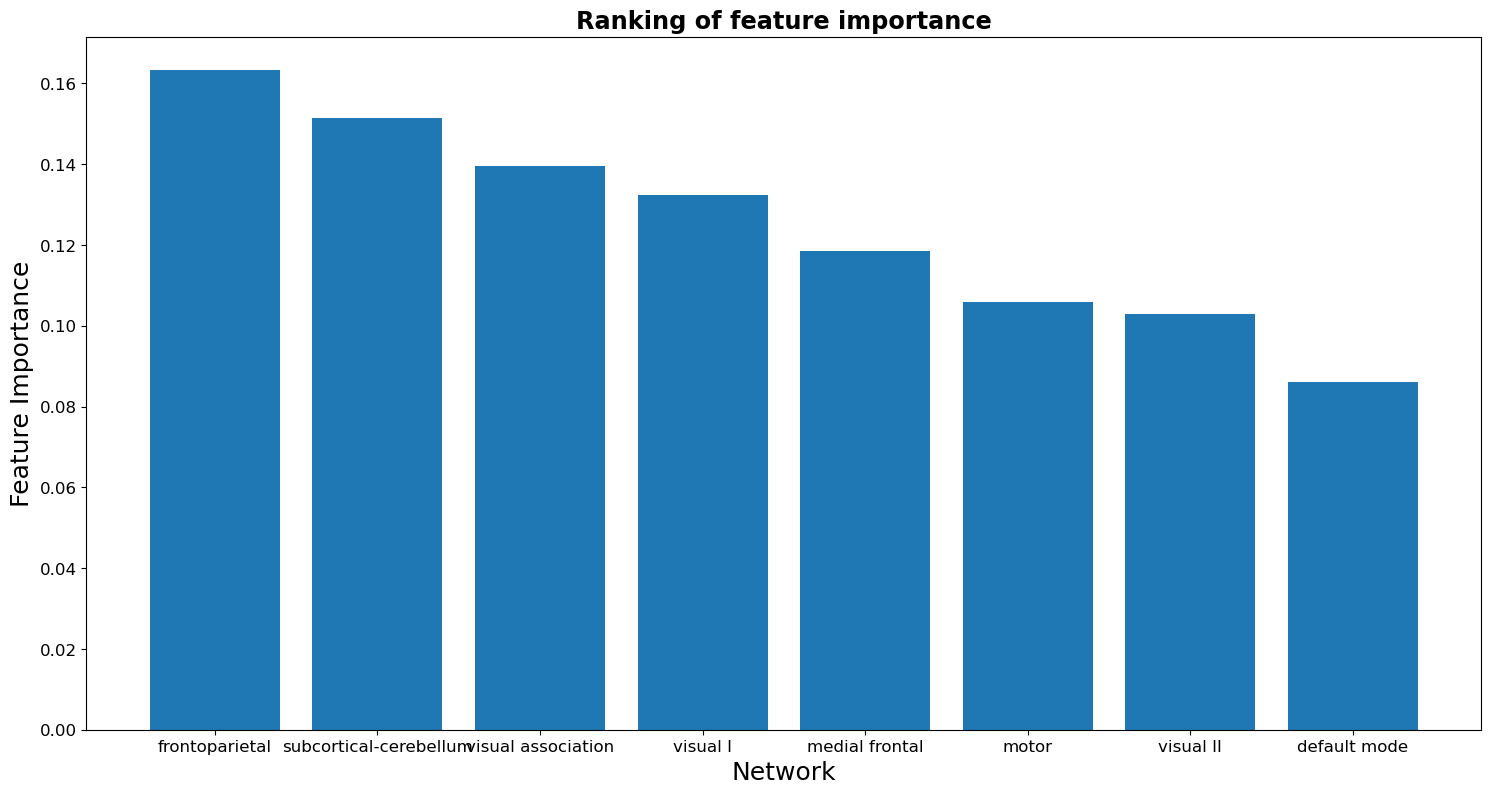

[0]	train-mlogloss:1.06831	test-mlogloss:1.12572
[1]	train-mlogloss:1.03818	test-mlogloss:1.15131
[2]	train-mlogloss:1.01131	test-mlogloss:1.16868
[3]	train-mlogloss:0.98529	test-mlogloss:1.19975
[4]	train-mlogloss:0.95654	test-mlogloss:1.23736
[5]	train-mlogloss:0.93333	test-mlogloss:1.23037
[6]	train-mlogloss:0.90708	test-mlogloss:1.21891
[7]	train-mlogloss:0.88386	test-mlogloss:1.25197
[8]	train-mlogloss:0.86365	test-mlogloss:1.23019
[9]	train-mlogloss:0.84407	test-mlogloss:1.23355
0.0
[0]	train-mlogloss:1.06908	test-mlogloss:1.12634
[1]	train-mlogloss:1.04161	test-mlogloss:1.13650
[2]	train-mlogloss:1.01673	test-mlogloss:1.14153
[3]	train-mlogloss:0.99032	test-mlogloss:1.16605
[4]	train-mlogloss:0.96349	test-mlogloss:1.19355
[5]	train-mlogloss:0.94158	test-mlogloss:1.20229
[6]	train-mlogloss:0.91605	test-mlogloss:1.19053
[7]	train-mlogloss:0.89687	test-mlogloss:1.19392
[8]	train-mlogloss:0.87724	test-mlogloss:1.17098
[9]	train-mlogloss:0.85950	test-mlogloss:1.17994
0.0
[0]	train-ml

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


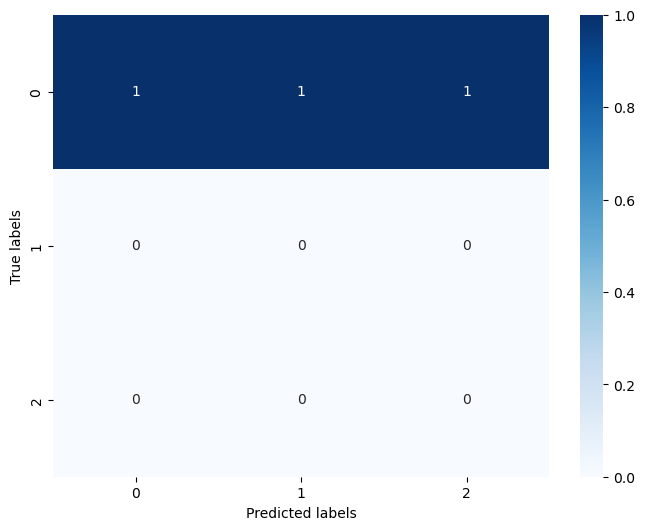

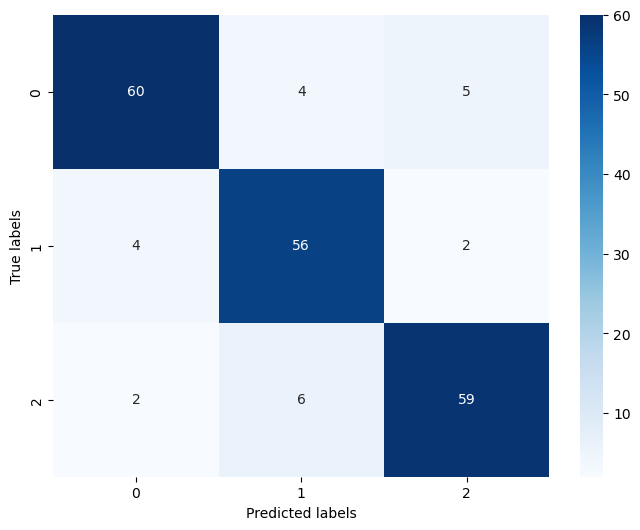

{'medial frontal': 0.1978766144229928, 'frontoparietal': 0.33922013959161934, 'default mode': 0.15495603120506554, 'subcortical-cerebellum': 0.31743498254713826, 'motor': 0.2069856490039639, 'visual I': 0.285554861334545, 'visual II': 0.15397682845489344, 'visual association': 0.3439948934397818}


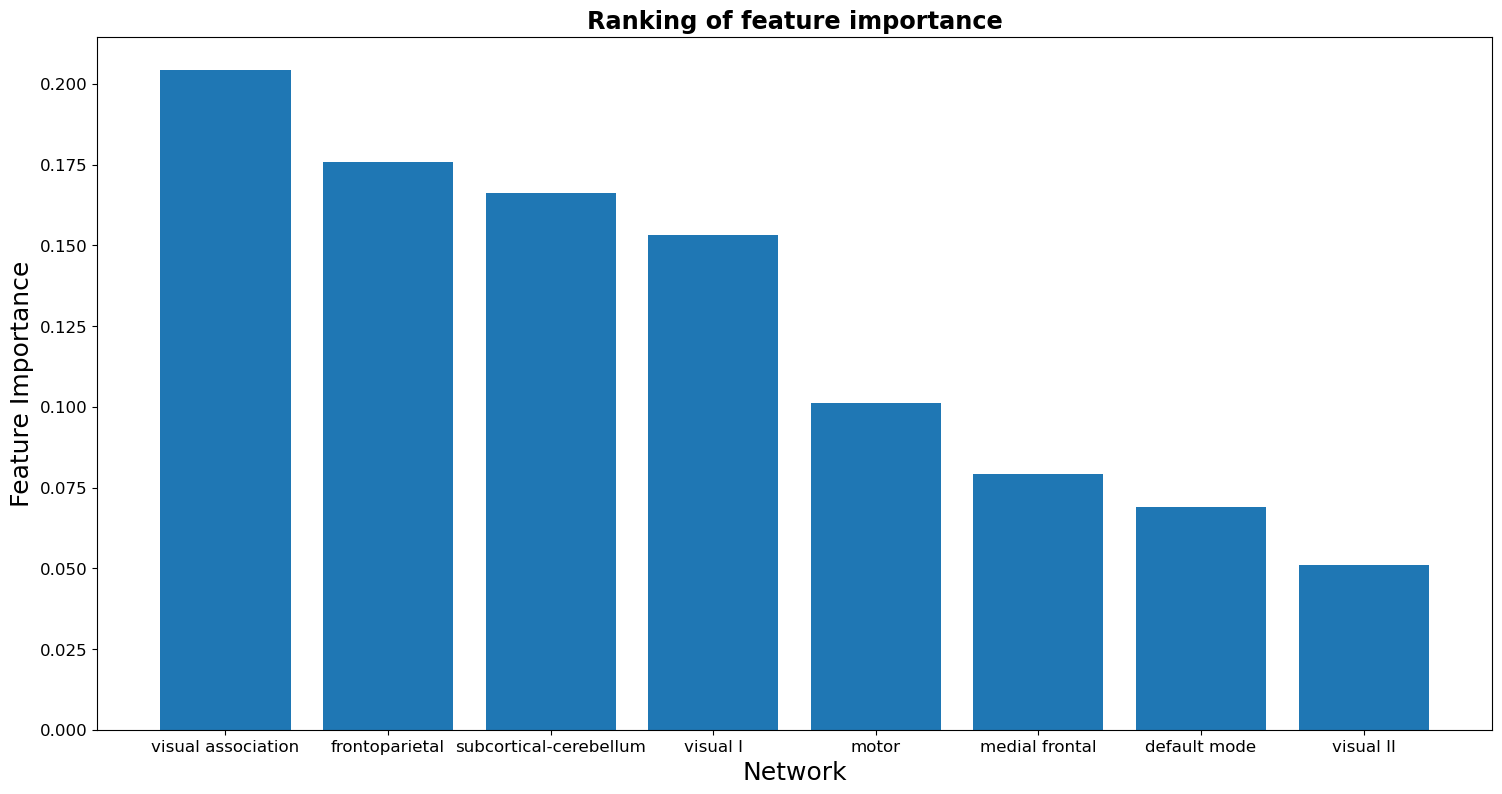

[0]	train-mlogloss:1.06657	test-mlogloss:1.11564
[1]	train-mlogloss:1.03965	test-mlogloss:1.12162
[2]	train-mlogloss:1.01018	test-mlogloss:1.11863
[3]	train-mlogloss:0.98439	test-mlogloss:1.13039
[4]	train-mlogloss:0.95557	test-mlogloss:1.09469
[5]	train-mlogloss:0.93292	test-mlogloss:1.07978
[6]	train-mlogloss:0.90689	test-mlogloss:1.04295
[7]	train-mlogloss:0.88540	test-mlogloss:1.04470
[8]	train-mlogloss:0.86320	test-mlogloss:1.05494
[9]	train-mlogloss:0.84602	test-mlogloss:1.04118
[10]	train-mlogloss:0.82665	test-mlogloss:1.02540
[11]	train-mlogloss:0.80753	test-mlogloss:1.03889
[12]	train-mlogloss:0.78643	test-mlogloss:1.05377
[13]	train-mlogloss:0.76815	test-mlogloss:1.03570
[14]	train-mlogloss:0.75144	test-mlogloss:1.03097
[15]	train-mlogloss:0.73510	test-mlogloss:1.04729
[16]	train-mlogloss:0.71958	test-mlogloss:1.03035
[17]	train-mlogloss:0.70423	test-mlogloss:1.01231
[18]	train-mlogloss:0.68878	test-mlogloss:1.01733
[19]	train-mlogloss:0.67448	test-mlogloss:1.01464
[20]	train

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


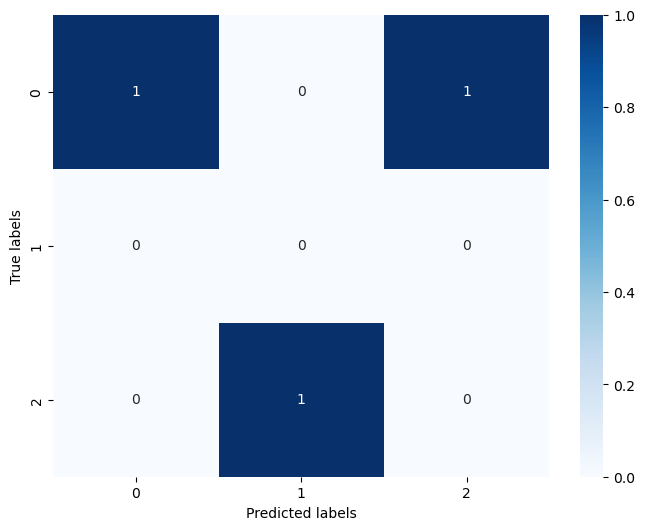

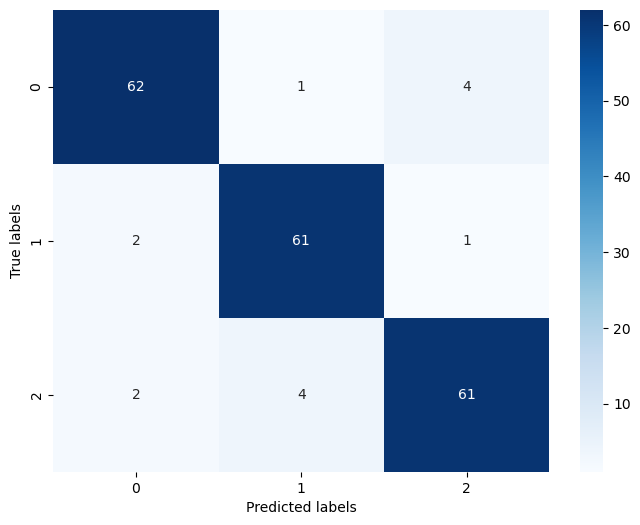

{'medial frontal': 1.0304994669592855, 'frontoparietal': 2.186295972002105, 'default mode': 1.4869182529430987, 'subcortical-cerebellum': 2.0318271243689017, 'motor': 1.3903119596018882, 'visual I': 1.6662093564468707, 'visual II': 1.5792673570558533, 'visual association': 1.6286705106219974}


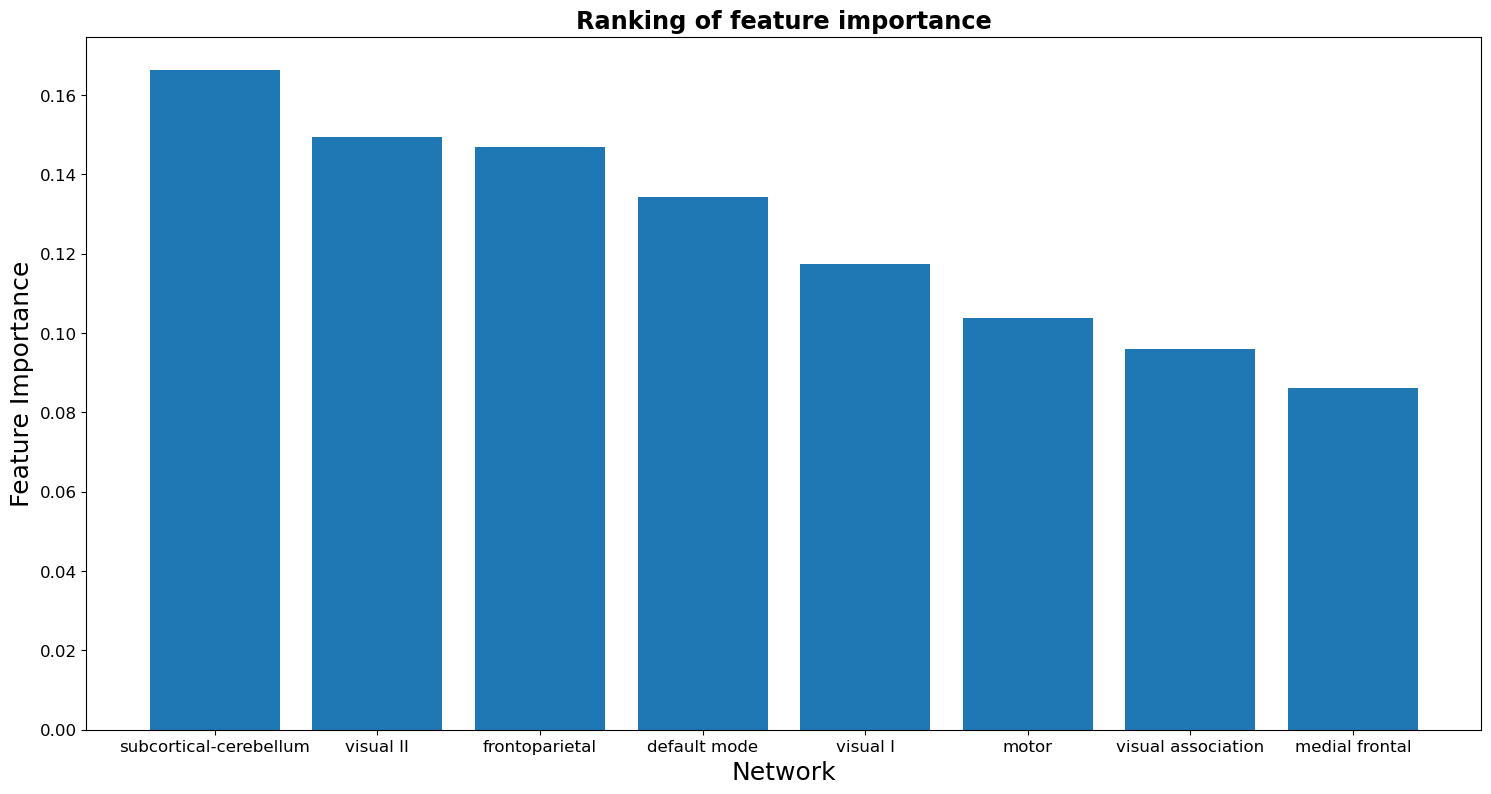

[0]	train-mlogloss:1.06819	test-mlogloss:1.12377
[1]	train-mlogloss:1.03924	test-mlogloss:1.09446
[2]	train-mlogloss:1.01431	test-mlogloss:1.06805
[3]	train-mlogloss:0.99006	test-mlogloss:1.07387
[4]	train-mlogloss:0.96447	test-mlogloss:1.05429
[5]	train-mlogloss:0.94245	test-mlogloss:1.05369
[6]	train-mlogloss:0.91767	test-mlogloss:1.05691
[7]	train-mlogloss:0.89379	test-mlogloss:1.04827
[8]	train-mlogloss:0.87217	test-mlogloss:1.05880
[9]	train-mlogloss:0.85334	test-mlogloss:1.06617
[10]	train-mlogloss:0.83198	test-mlogloss:1.04272
[11]	train-mlogloss:0.80945	test-mlogloss:1.04303
[12]	train-mlogloss:0.79189	test-mlogloss:1.03679
[13]	train-mlogloss:0.77410	test-mlogloss:1.02092
[14]	train-mlogloss:0.75625	test-mlogloss:1.01418
[15]	train-mlogloss:0.73978	test-mlogloss:1.01566
[16]	train-mlogloss:0.72439	test-mlogloss:0.98846
[17]	train-mlogloss:0.70845	test-mlogloss:0.95715
[18]	train-mlogloss:0.69352	test-mlogloss:0.94404
[19]	train-mlogloss:0.67933	test-mlogloss:0.92844
[20]	train

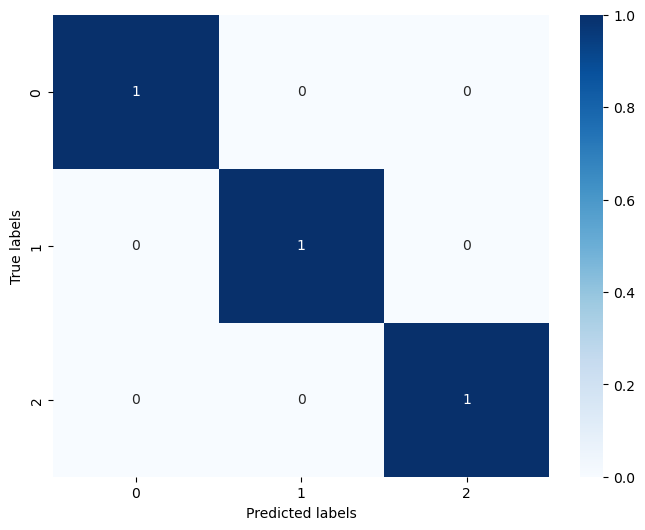

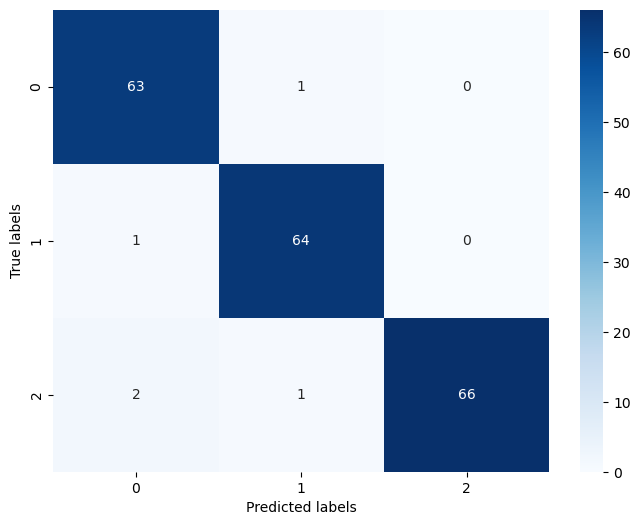

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
{'medial frontal': 1.099242181064665, 'frontoparietal': 2.337765824896066, 'default mode': 1.6239740391906994, 'subcortical-cerebellum': 2.1924177425984137, 'motor': 1.5032791531150622, 'visual I': 1.781576179887612, 'visual II': 1.6992488534342243, 'visual association': 1.7624960258132574}


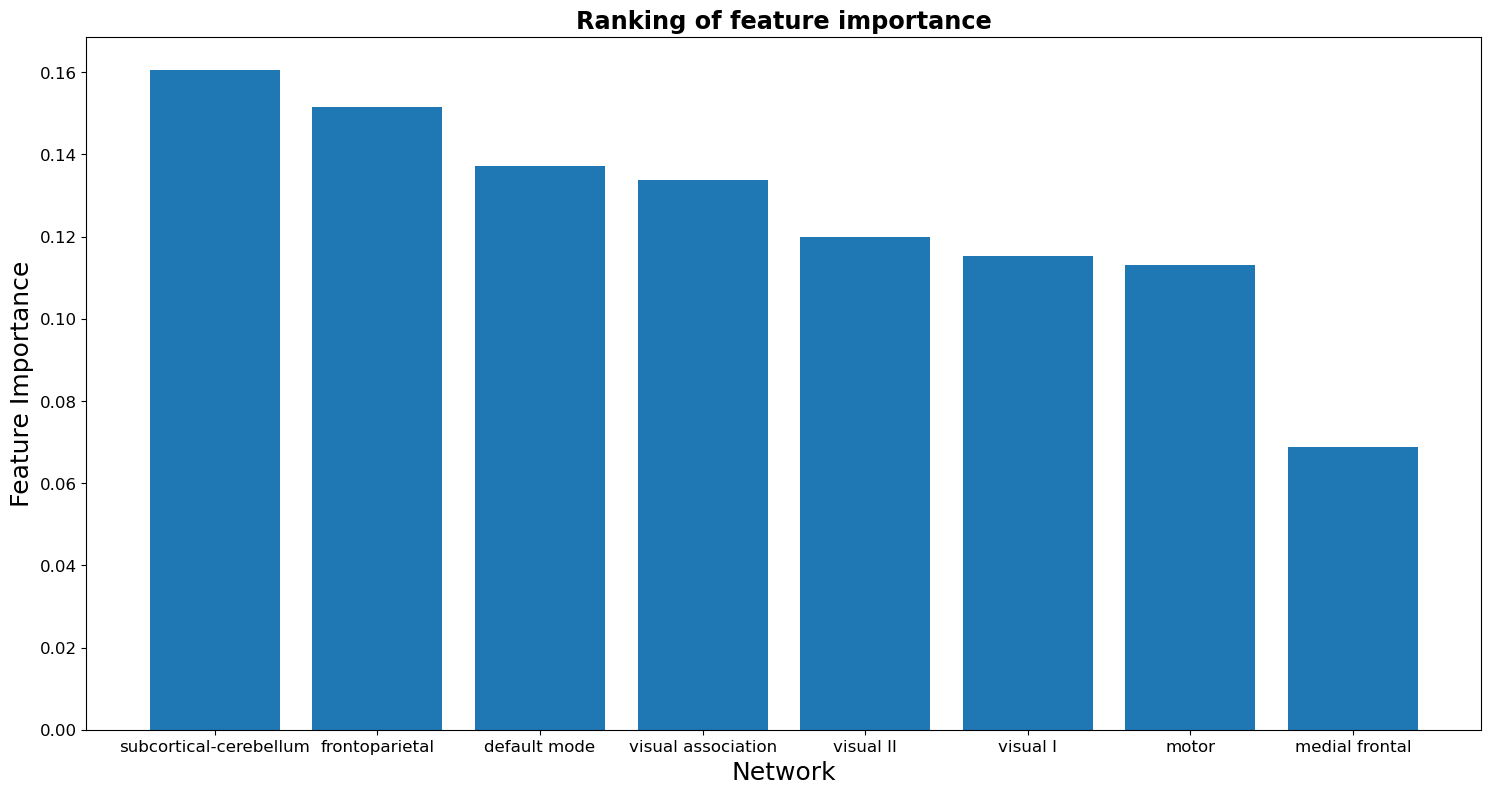

[0]	train-mlogloss:1.06957	test-mlogloss:1.09526
[1]	train-mlogloss:1.04120	test-mlogloss:1.07708
[2]	train-mlogloss:1.01610	test-mlogloss:1.08246
[3]	train-mlogloss:0.98808	test-mlogloss:1.07450
[4]	train-mlogloss:0.96258	test-mlogloss:1.08508
[5]	train-mlogloss:0.93929	test-mlogloss:1.09565
[6]	train-mlogloss:0.91304	test-mlogloss:1.06621
[7]	train-mlogloss:0.89195	test-mlogloss:1.05405
[8]	train-mlogloss:0.87200	test-mlogloss:1.03737
[9]	train-mlogloss:0.85186	test-mlogloss:1.06761
[10]	train-mlogloss:0.83080	test-mlogloss:1.04849
[11]	train-mlogloss:0.80940	test-mlogloss:0.99799
[12]	train-mlogloss:0.79192	test-mlogloss:0.97490
[13]	train-mlogloss:0.77331	test-mlogloss:0.96756
[14]	train-mlogloss:0.75606	test-mlogloss:0.96772
[15]	train-mlogloss:0.73932	test-mlogloss:0.95643
[16]	train-mlogloss:0.72413	test-mlogloss:0.93917
[17]	train-mlogloss:0.70917	test-mlogloss:0.93403
[18]	train-mlogloss:0.69427	test-mlogloss:0.91933
[19]	train-mlogloss:0.67859	test-mlogloss:0.93803
[20]	train

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


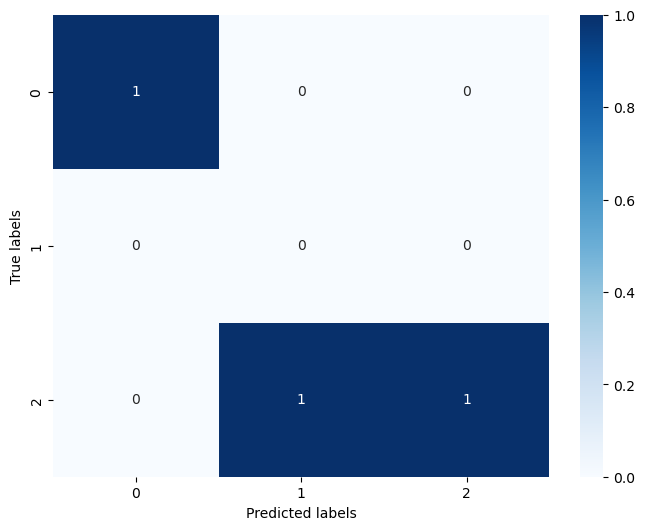

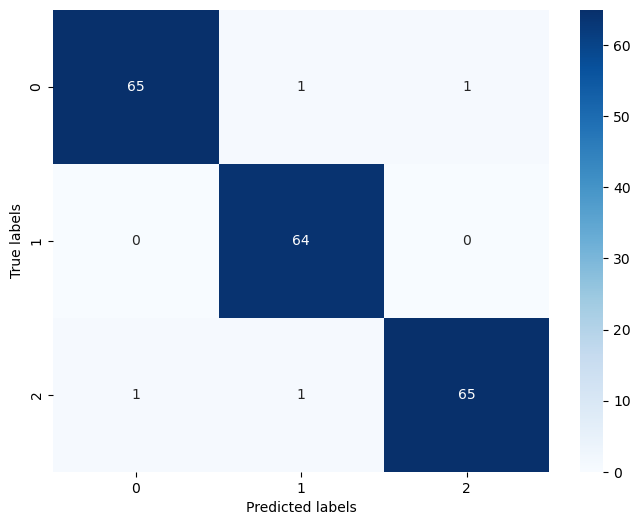

0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
{'medial frontal': 1.1711420147277678, 'frontoparietal': 2.5191895473376453, 'default mode': 1.7412606428536357, 'subcortical-cerebellum': 2.3613490647466757, 'motor': 1.616221808494186, 'visual I': 1.8925881915850413, 'visual II': 1.8150874743358898, 'visual association': 1.8831612559191588}


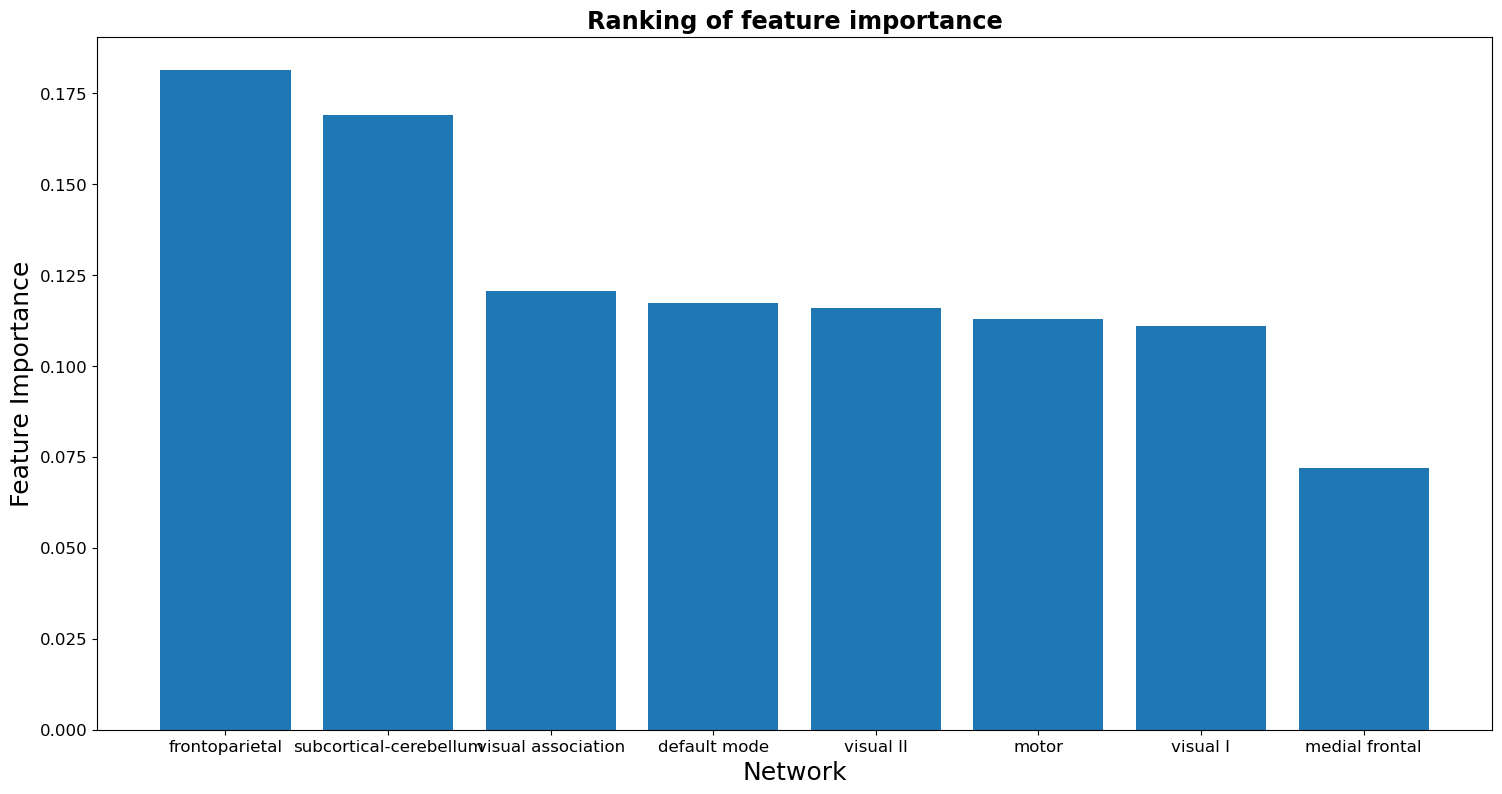

[0]	train-mlogloss:1.06695	test-mlogloss:1.08349
[1]	train-mlogloss:1.03819	test-mlogloss:1.11487
[2]	train-mlogloss:1.00912	test-mlogloss:1.11600
[3]	train-mlogloss:0.98380	test-mlogloss:1.11170
[4]	train-mlogloss:0.95528	test-mlogloss:1.11250
[5]	train-mlogloss:0.93094	test-mlogloss:1.12010
[6]	train-mlogloss:0.90921	test-mlogloss:1.11368
[7]	train-mlogloss:0.88821	test-mlogloss:1.10027
[8]	train-mlogloss:0.86865	test-mlogloss:1.07555
[9]	train-mlogloss:0.84811	test-mlogloss:1.07072
[10]	train-mlogloss:0.82770	test-mlogloss:1.08859
[11]	train-mlogloss:0.80511	test-mlogloss:1.08565
[12]	train-mlogloss:0.78503	test-mlogloss:1.07951
[13]	train-mlogloss:0.76842	test-mlogloss:1.09033
[14]	train-mlogloss:0.75221	test-mlogloss:1.07059
[15]	train-mlogloss:0.73622	test-mlogloss:1.06089
[16]	train-mlogloss:0.72069	test-mlogloss:1.05476
[17]	train-mlogloss:0.70602	test-mlogloss:1.05484
[18]	train-mlogloss:0.69091	test-mlogloss:1.04990
[19]	train-mlogloss:0.67573	test-mlogloss:1.07527
[20]	train

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[19]	train-mlogloss:0.70396	test-mlogloss:1.02248
[20]	train-mlogloss:0.69020	test-mlogloss:1.01169
[21]	train-mlogloss:0.67692	test-mlogloss:0.99468
[22]	train-mlogloss:0.66408	test-mlogloss:1.00620
[23]	train-mlogloss:0.65122	test-mlogloss:1.00341
[24]	train-mlogloss:0.63885	test-mlogloss:0.99291
[25]	train-mlogloss:0.62840	test-mlogloss:0.98530
0.6666666666666666
[0]	train-mlogloss:1.07078	test-mlogloss:1.10677
[1]	train-mlogloss:1.04547	test-mlogloss:1.09402
[2]	train-mlogloss:1.02267	test-mlogloss:1.08804
[3]	train-mlogloss:0.99862	test-mlogloss:1.09675
[4]	train-mlogloss:0.97839	test-mlogloss:1.09419
[5]	train-mlogloss:0.95723	test-mlogloss:1.07593
[6]	train-mlogloss:0.93557	test-mlogloss:1.07859
[7]	train-mlogloss:0.91581	test-mlogloss:1.06772
[8]	train-mlogloss:0.89795	test-mlogloss:1.04327
[9]	train-mlogloss:0.88111	test-mlogloss:1.02894
[10]	train-mlogloss:0.86127	test-mlogloss:0.98265
[11]	train-mlogloss:0.84240	test-mlogloss:0.98800
[12]	train-mlogloss:0.82794	test-mlogloss

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


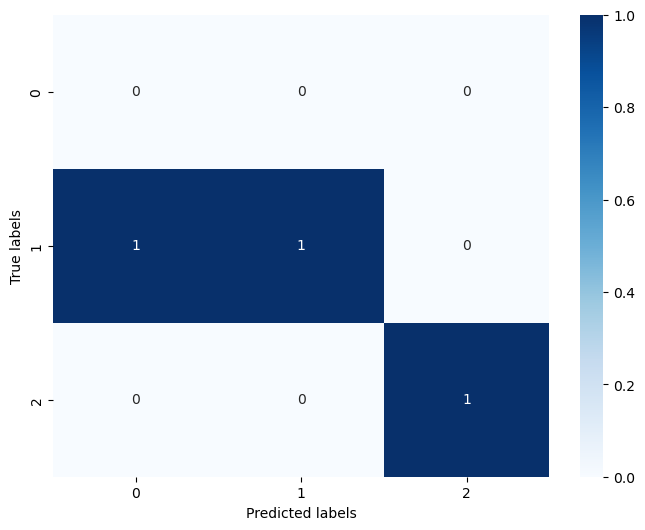

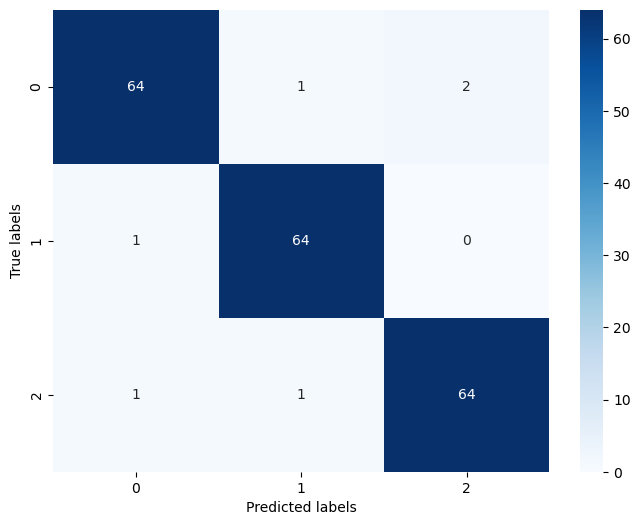

0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
{'medial frontal': 1.4170290994920185, 'frontoparietal': 3.0225470636139162, 'default mode': 2.125586518401384, 'subcortical-cerebellum': 2.844719867191074, 'motor': 1.9411834604916587, 'visual I': 2.198122773358366, 'visual II': 2.1255599546828767, 'visual association': 2.325251262768707}


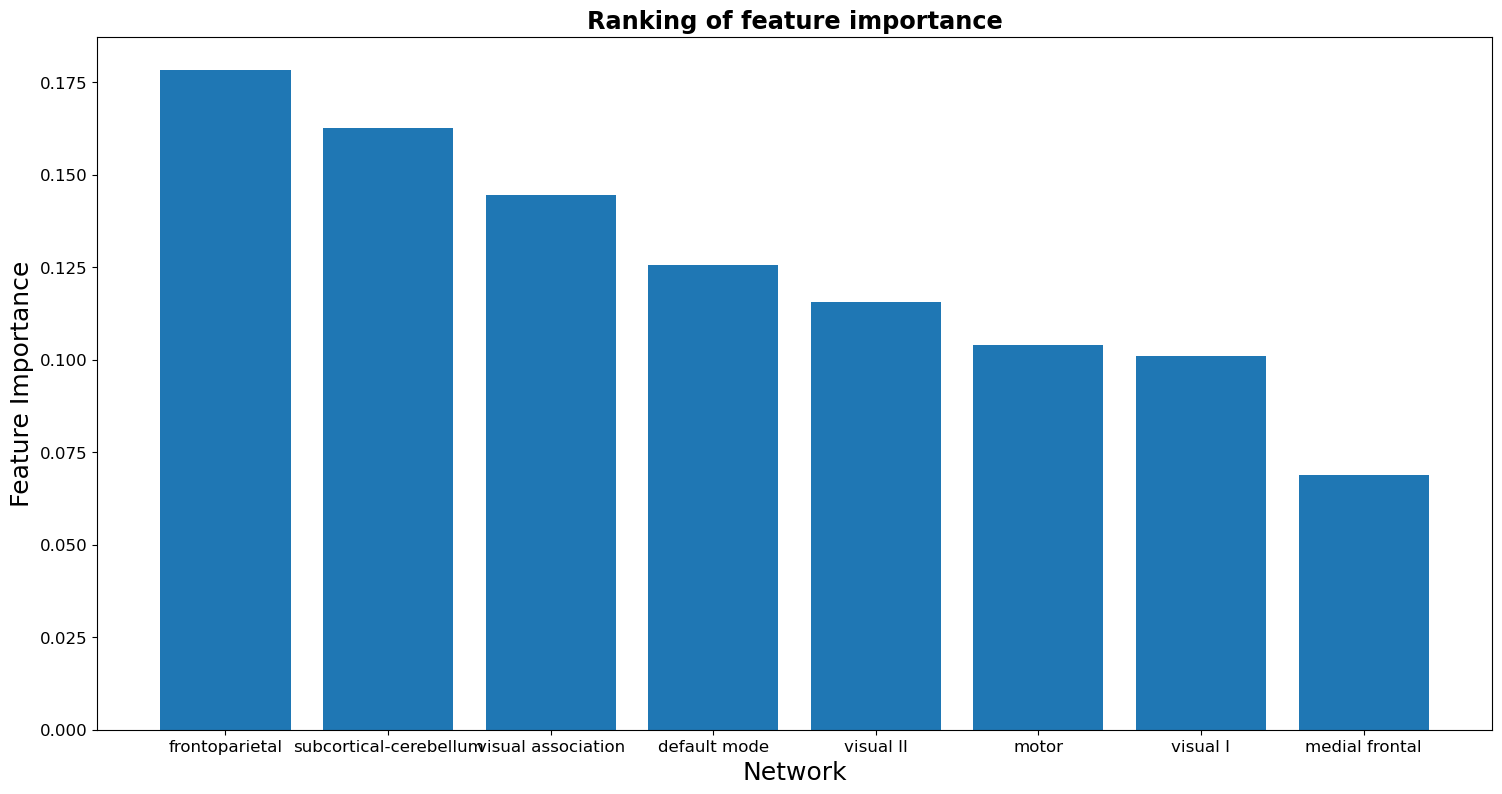

[0]	train-mlogloss:1.06671	test-mlogloss:1.09890
[1]	train-mlogloss:1.03798	test-mlogloss:1.07789
[2]	train-mlogloss:1.00904	test-mlogloss:1.06376
[3]	train-mlogloss:0.98373	test-mlogloss:1.04889
[4]	train-mlogloss:0.95720	test-mlogloss:1.06473
[5]	train-mlogloss:0.93386	test-mlogloss:1.05788
[6]	train-mlogloss:0.90978	test-mlogloss:1.01560
[7]	train-mlogloss:0.88780	test-mlogloss:1.03074
[8]	train-mlogloss:0.86741	test-mlogloss:1.03886
[9]	train-mlogloss:0.84848	test-mlogloss:1.05403
[10]	train-mlogloss:0.82633	test-mlogloss:1.03628
[11]	train-mlogloss:0.80633	test-mlogloss:1.03533
[12]	train-mlogloss:0.78974	test-mlogloss:1.05519
[13]	train-mlogloss:0.77288	test-mlogloss:1.05811
[14]	train-mlogloss:0.75629	test-mlogloss:1.06626
[15]	train-mlogloss:0.74063	test-mlogloss:1.07290
[16]	train-mlogloss:0.72492	test-mlogloss:1.06134
0.6666666666666666
[0]	train-mlogloss:1.06862	test-mlogloss:1.09190
[1]	train-mlogloss:1.04073	test-mlogloss:1.07863
[2]	train-mlogloss:1.01167	test-mlogloss:1.

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


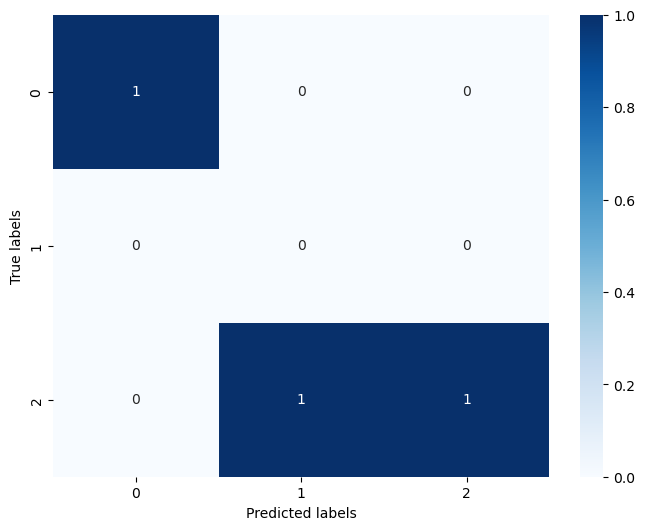

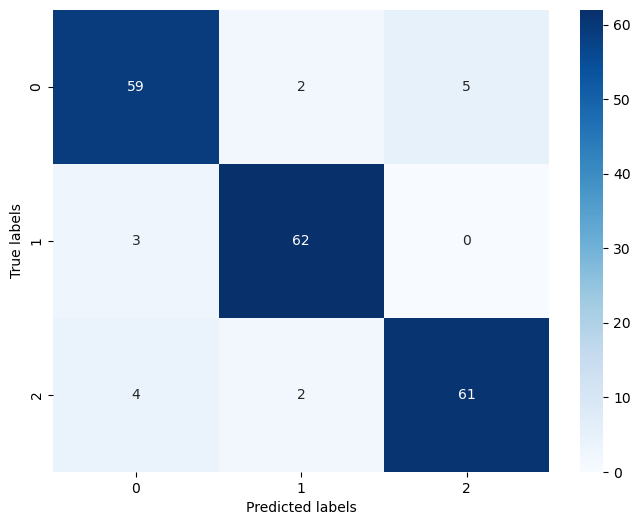

0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
{'medial frontal': 1.4551613449994336, 'frontoparietal': 3.2104667571602623, 'default mode': 2.254600615701471, 'subcortical-cerebellum': 2.9757818073054487, 'motor': 2.0591392065945957, 'visual I': 2.3278194849298823, 'visual II': 2.289387379825845, 'visual association': 2.4276434034830623}
[1]	train-mlogloss:1.03600	test-mlogloss:1.06364
[2]	train-mlogloss:1.00701	test-mlogloss:1.01647
[3]	train-mlogloss:0.97988	test-mlogloss:1.02042
[4]	train-mlogloss:0.95193	test-mlogloss:1.00062
[5]	train-mlogloss:0.92862	test-mlogloss:0.99717
[6]	train-mlogloss:0.90068	test-mlogloss:0.99084
[7]	train-mlogloss:0.87625	test-mlogloss:0.97790
[8]	train-mlogloss:0.85669	test-mlogloss:0.98105
[9]	train-mlogloss:0.83753	test-mlogloss:0.96954
[10]	train-mlogloss:0.81379	test-mlogloss:0.94304
[11]	train-mlogloss:0.79388	test-mlogloss:0.91943
[12]	train-mlo

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


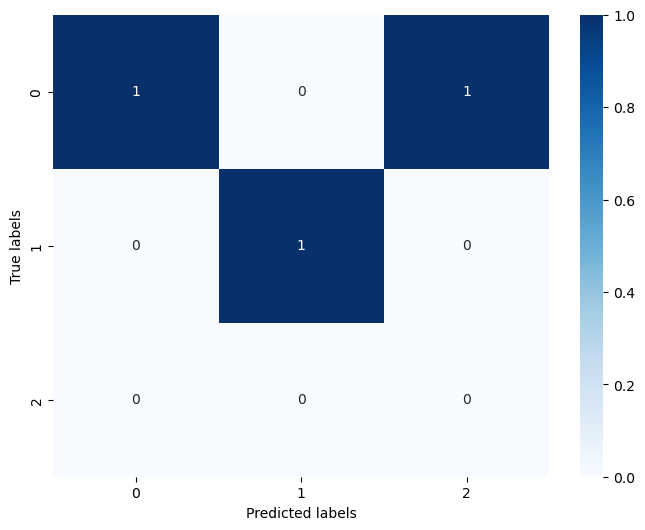

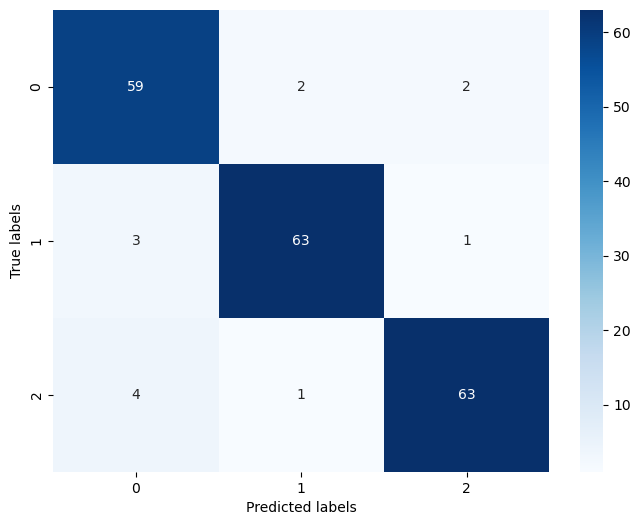

0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
{'medial frontal': 2.0350186335436566, 'frontoparietal': 4.567563552436644, 'default mode': 3.3120517000961875, 'subcortical-cerebellum': 4.339401386279263, 'motor': 3.152135583022378, 'visual I': 3.5519344831518698, 'visual II': 3.4843681070256585, 'visual association': 3.557526554444343}


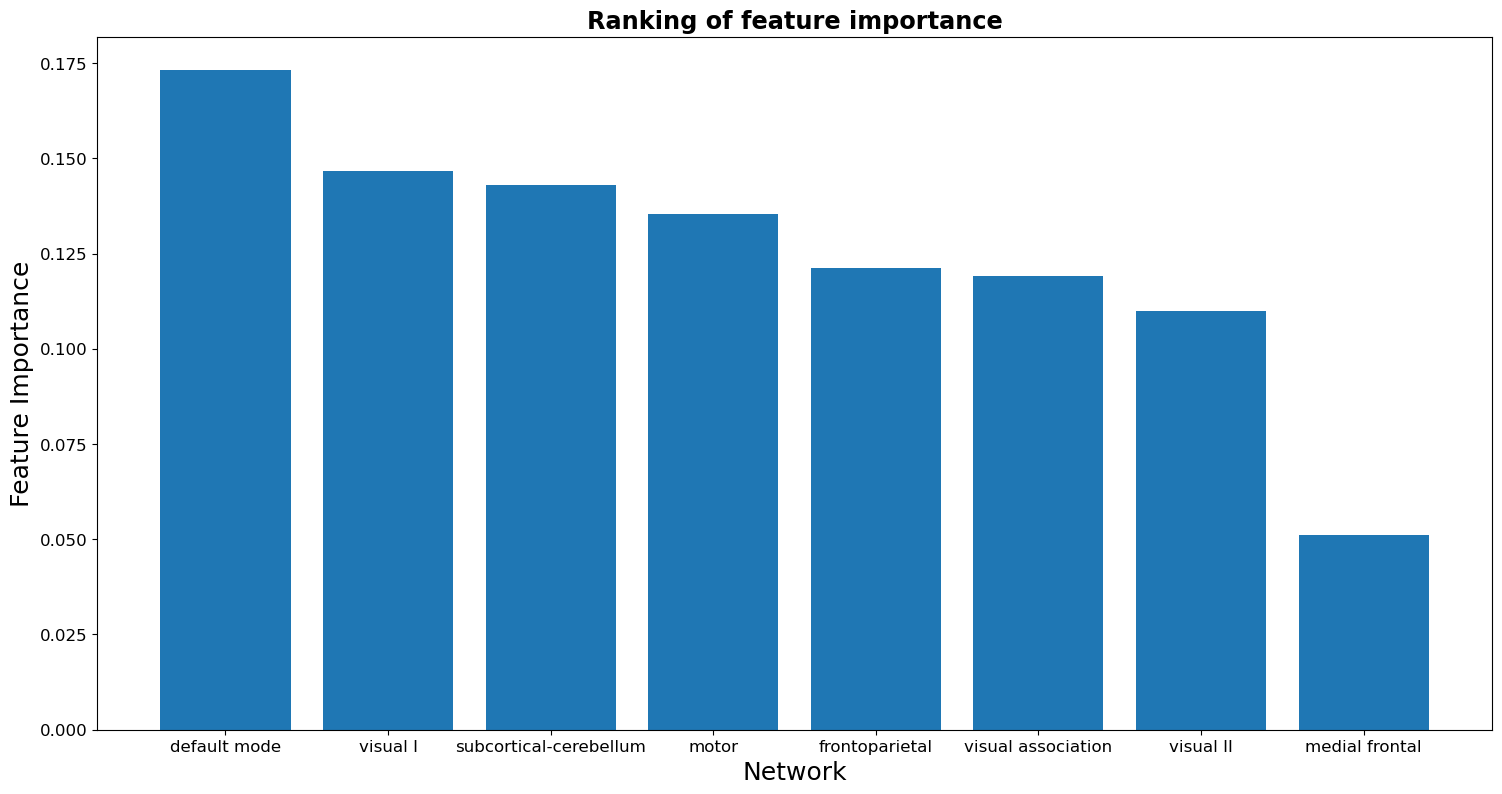

[0]	train-mlogloss:1.06634	test-mlogloss:1.11453
[1]	train-mlogloss:1.03826	test-mlogloss:1.12176
[2]	train-mlogloss:1.01001	test-mlogloss:1.13488
[3]	train-mlogloss:0.98283	test-mlogloss:1.15137
[4]	train-mlogloss:0.95637	test-mlogloss:1.14270
[5]	train-mlogloss:0.93424	test-mlogloss:1.15421
[6]	train-mlogloss:0.90828	test-mlogloss:1.16149
[7]	train-mlogloss:0.88688	test-mlogloss:1.15482
[8]	train-mlogloss:0.86755	test-mlogloss:1.14204
[9]	train-mlogloss:0.84706	test-mlogloss:1.12388
[10]	train-mlogloss:0.82529	test-mlogloss:1.11157
[11]	train-mlogloss:0.80593	test-mlogloss:1.08905
[12]	train-mlogloss:0.78945	test-mlogloss:1.06120
[13]	train-mlogloss:0.77168	test-mlogloss:1.07366
[14]	train-mlogloss:0.75516	test-mlogloss:1.07415
[15]	train-mlogloss:0.73844	test-mlogloss:1.06377
[16]	train-mlogloss:0.72315	test-mlogloss:1.06076
[17]	train-mlogloss:0.70731	test-mlogloss:1.06399
[18]	train-mlogloss:0.69277	test-mlogloss:1.07424
[19]	train-mlogloss:0.67900	test-mlogloss:1.07747
[20]	train

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


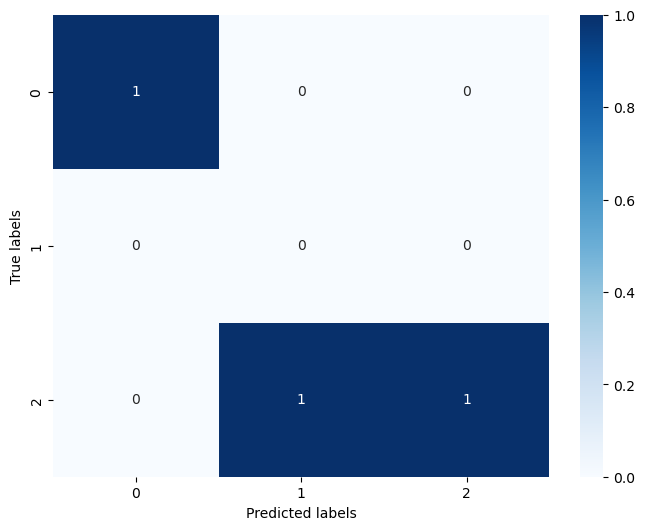

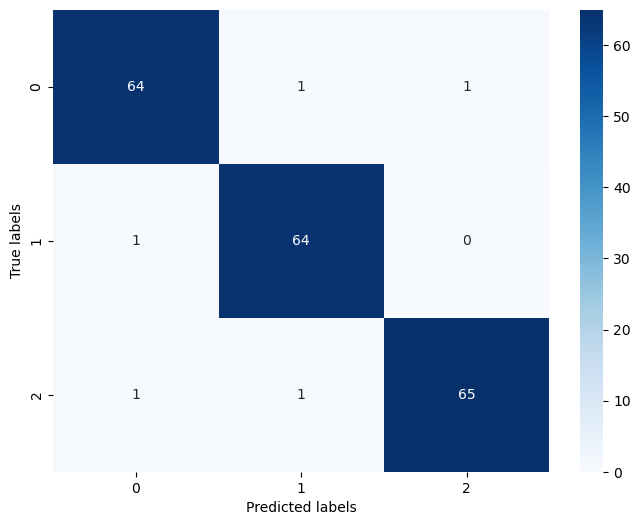

0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
{'medial frontal': 2.099744683617598, 'frontoparietal': 4.721184459005998, 'default mode': 3.4507905813416353, 'subcortical-cerebellum': 4.464538416422216, 'motor': 3.2663911322833346, 'visual I': 3.633545589766839, 'visual II': 3.6838619231955834, 'visual association': 3.679943214366797}


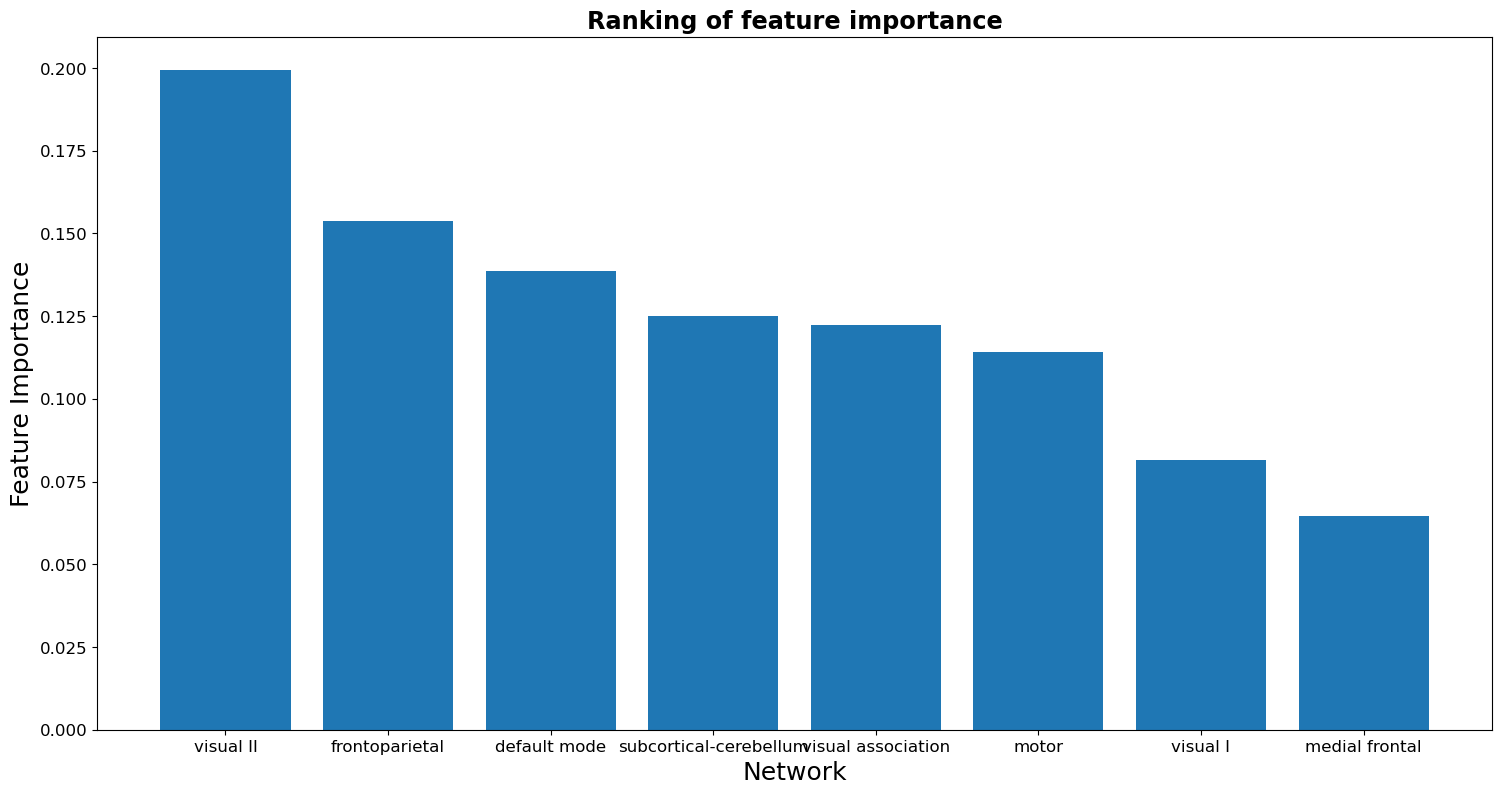

[0]	train-mlogloss:1.06743	test-mlogloss:1.06286
[1]	train-mlogloss:1.03952	test-mlogloss:1.03112
[2]	train-mlogloss:1.01278	test-mlogloss:1.00266
[3]	train-mlogloss:0.98564	test-mlogloss:0.98550
[4]	train-mlogloss:0.96031	test-mlogloss:1.01826
[5]	train-mlogloss:0.93839	test-mlogloss:1.02113
[6]	train-mlogloss:0.91232	test-mlogloss:1.02060
[7]	train-mlogloss:0.88785	test-mlogloss:1.02223
[8]	train-mlogloss:0.86800	test-mlogloss:1.04504
[9]	train-mlogloss:0.84706	test-mlogloss:1.04518
[10]	train-mlogloss:0.82313	test-mlogloss:1.03055
[11]	train-mlogloss:0.80494	test-mlogloss:1.00163
[12]	train-mlogloss:0.78734	test-mlogloss:1.01673
[13]	train-mlogloss:0.76816	test-mlogloss:1.00452
0.3333333333333333
[0]	train-mlogloss:1.07086	test-mlogloss:1.05621
[1]	train-mlogloss:1.04397	test-mlogloss:1.01776
[2]	train-mlogloss:1.01960	test-mlogloss:1.00581
[3]	train-mlogloss:0.99410	test-mlogloss:0.98797
[4]	train-mlogloss:0.96910	test-mlogloss:1.01659
[5]	train-mlogloss:0.94846	test-mlogloss:1.013

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


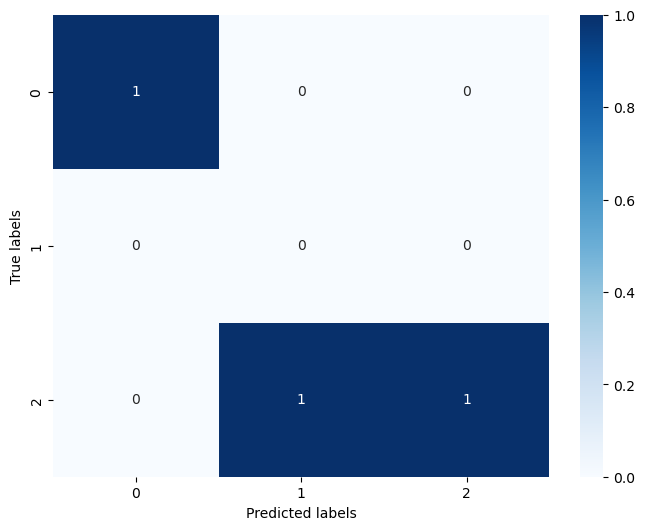

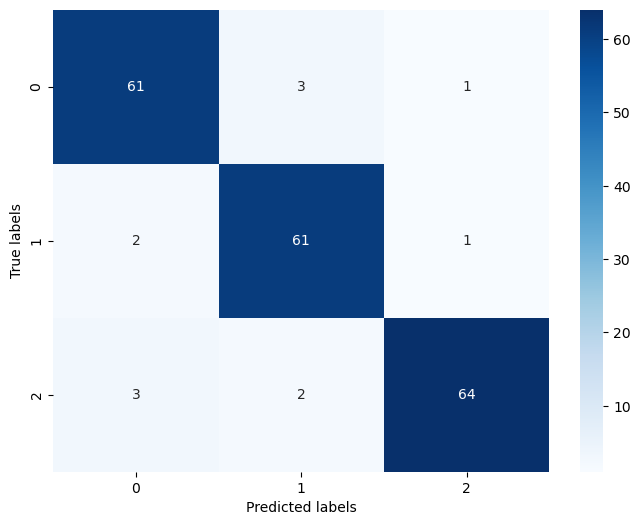

0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
{'medial frontal': 2.175316535325538, 'frontoparietal': 4.880181707795448, 'default mode': 3.5603697663181486, 'subcortical-cerebellum': 4.613890787056872, 'motor': 3.383275596258282, 'visual I': 3.7796511697355237, 'visual II': 3.79749959650456, 'visual association': 3.8098148410056276}


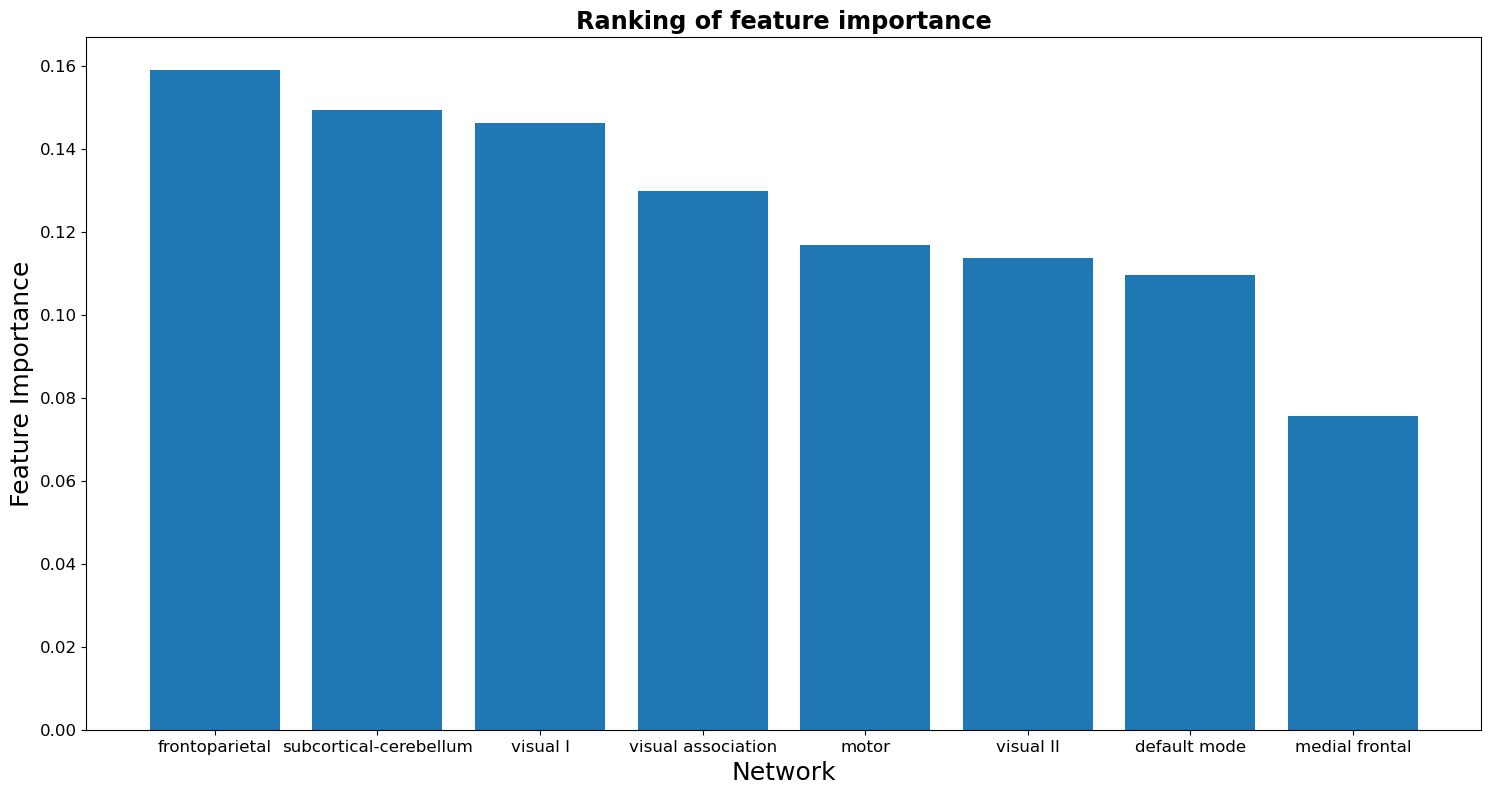

[0]	train-mlogloss:1.06584	test-mlogloss:1.14152
[1]	train-mlogloss:1.03460	test-mlogloss:1.17120
[2]	train-mlogloss:1.00765	test-mlogloss:1.19633
[3]	train-mlogloss:0.97978	test-mlogloss:1.23758
[4]	train-mlogloss:0.95384	test-mlogloss:1.25399
[5]	train-mlogloss:0.93078	test-mlogloss:1.26590
[6]	train-mlogloss:0.90613	test-mlogloss:1.24834
[7]	train-mlogloss:0.88375	test-mlogloss:1.27234
[8]	train-mlogloss:0.86484	test-mlogloss:1.27423
[9]	train-mlogloss:0.84307	test-mlogloss:1.28235
0.0
[0]	train-mlogloss:1.06951	test-mlogloss:1.14041
[1]	train-mlogloss:1.03933	test-mlogloss:1.16178
[2]	train-mlogloss:1.01540	test-mlogloss:1.19261
[3]	train-mlogloss:0.98902	test-mlogloss:1.22564
[4]	train-mlogloss:0.96361	test-mlogloss:1.25207
[5]	train-mlogloss:0.94153	test-mlogloss:1.26475
[6]	train-mlogloss:0.91769	test-mlogloss:1.27998
[7]	train-mlogloss:0.89616	test-mlogloss:1.28477
[8]	train-mlogloss:0.87689	test-mlogloss:1.30538
[9]	train-mlogloss:0.85449	test-mlogloss:1.34396
0.0
[0]	train-ml

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


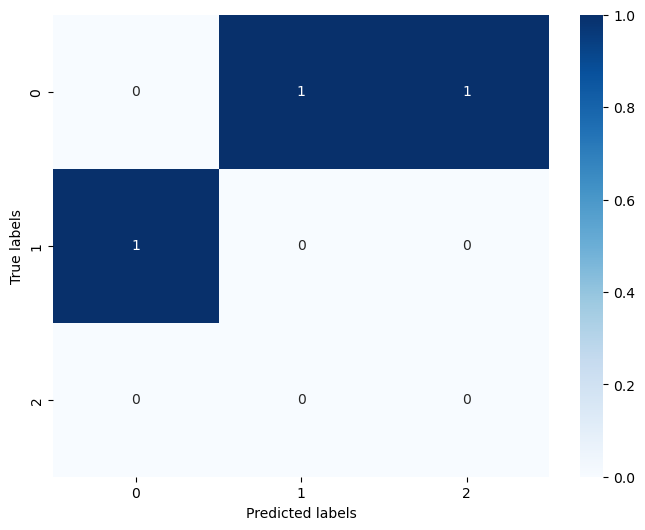

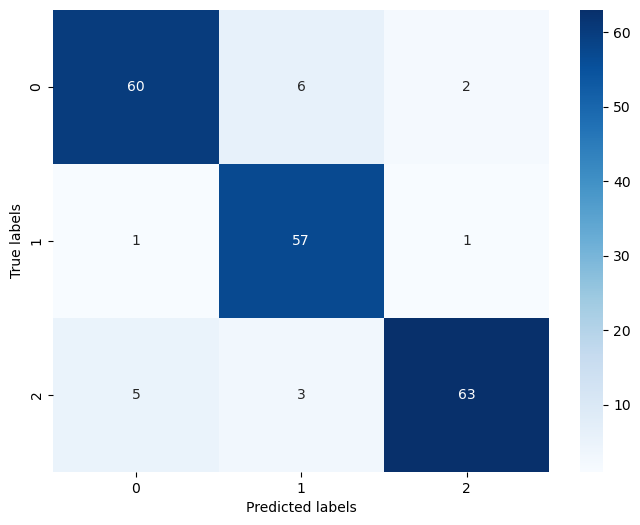

{'medial frontal': 2.239828281663665, 'frontoparietal': 5.026914307309619, 'default mode': 3.7162731533019553, 'subcortical-cerebellum': 4.750161895679755, 'motor': 3.4872111875808196, 'visual I': 3.9528771552730864, 'visual II': 3.9129835868629352, 'visual association': 3.913750432328165}


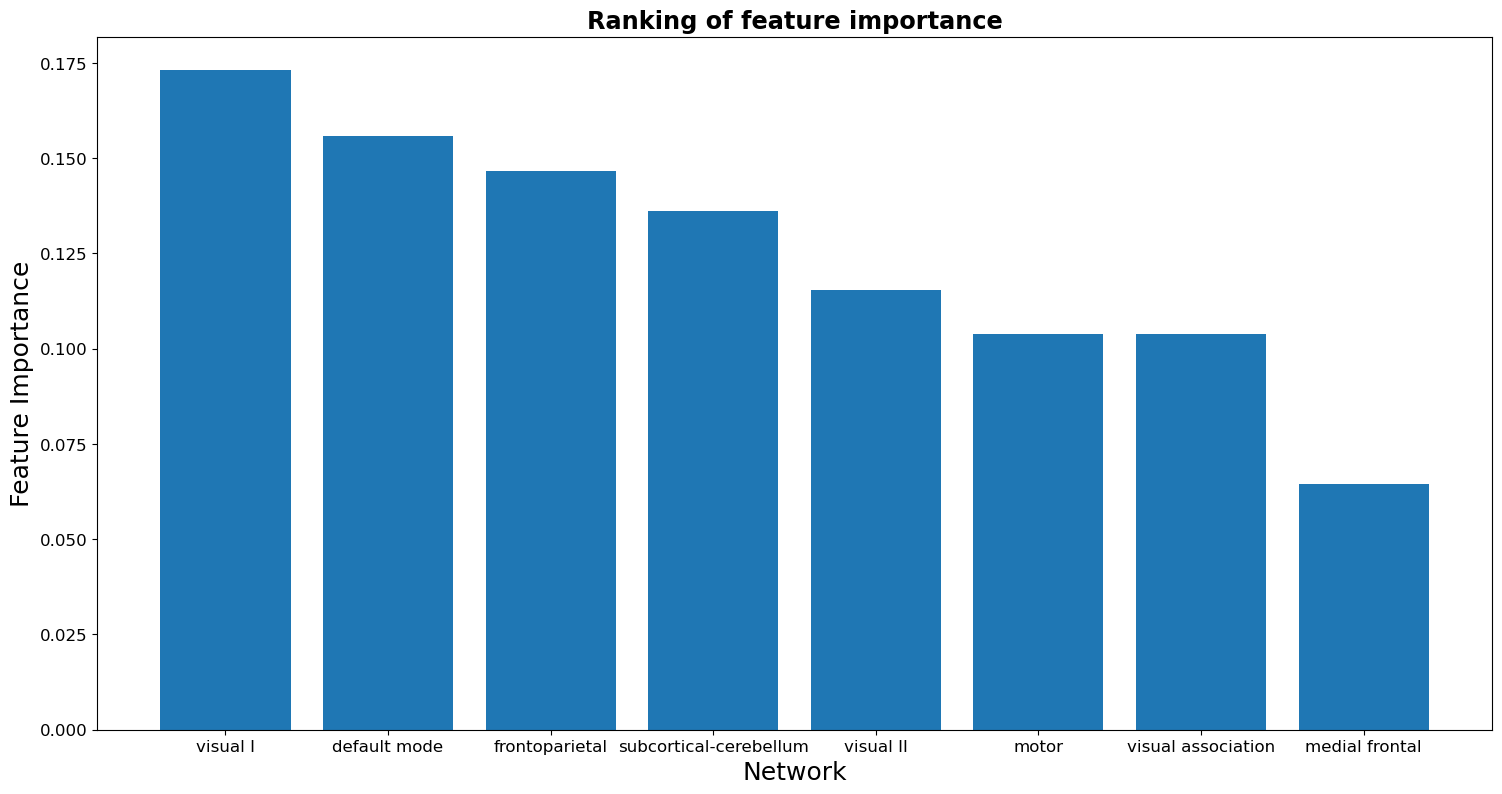

[0]	train-mlogloss:1.06626	test-mlogloss:1.08297
[1]	train-mlogloss:1.03723	test-mlogloss:1.08001
[2]	train-mlogloss:1.01152	test-mlogloss:1.08474
[3]	train-mlogloss:0.98502	test-mlogloss:1.05368
[4]	train-mlogloss:0.96064	test-mlogloss:1.04614
[5]	train-mlogloss:0.93834	test-mlogloss:1.04993
[6]	train-mlogloss:0.91546	test-mlogloss:1.04143
[7]	train-mlogloss:0.89092	test-mlogloss:1.04900
[8]	train-mlogloss:0.87166	test-mlogloss:1.05913
[9]	train-mlogloss:0.85062	test-mlogloss:1.08118
[10]	train-mlogloss:0.82780	test-mlogloss:1.05897
[11]	train-mlogloss:0.80824	test-mlogloss:1.03700
[12]	train-mlogloss:0.79083	test-mlogloss:1.05370
[13]	train-mlogloss:0.77314	test-mlogloss:1.05266
[14]	train-mlogloss:0.75644	test-mlogloss:1.03796
[15]	train-mlogloss:0.73940	test-mlogloss:1.03815
[16]	train-mlogloss:0.72404	test-mlogloss:1.04307
[17]	train-mlogloss:0.70668	test-mlogloss:1.06297


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[8]	train-mlogloss:0.88241	test-mlogloss:0.92205
[9]	train-mlogloss:0.86400	test-mlogloss:0.92923
[10]	train-mlogloss:0.84328	test-mlogloss:0.91574
1.0
[0]	train-mlogloss:1.07240	test-mlogloss:1.06013
[1]	train-mlogloss:1.04812	test-mlogloss:1.03429
[2]	train-mlogloss:1.02548	test-mlogloss:1.01314
[3]	train-mlogloss:1.00126	test-mlogloss:0.99174
[4]	train-mlogloss:0.97736	test-mlogloss:0.97577
[5]	train-mlogloss:0.95671	test-mlogloss:0.96132
[6]	train-mlogloss:0.93506	test-mlogloss:0.94536
[7]	train-mlogloss:0.91468	test-mlogloss:0.93320
[8]	train-mlogloss:0.89432	test-mlogloss:0.91189
[9]	train-mlogloss:0.87680	test-mlogloss:0.91972
[10]	train-mlogloss:0.85925	test-mlogloss:0.90472
0.6666666666666666
[0]	train-mlogloss:1.07271	test-mlogloss:1.06022
[1]	train-mlogloss:1.05191	test-mlogloss:1.04777
[2]	train-mlogloss:1.03028	test-mlogloss:1.02260
[3]	train-mlogloss:1.00664	test-mlogloss:1.00580
[4]	train-mlogloss:0.98367	test-mlogloss:0.99061
[5]	train-mlogloss:0.96569	test-mlogloss:0.9

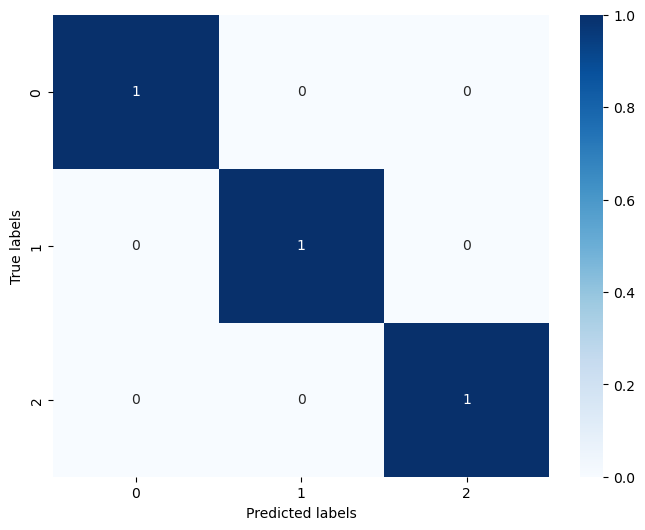

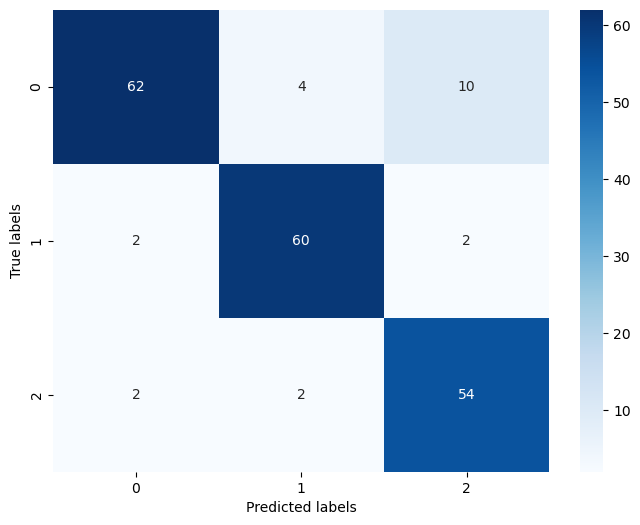

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
{'medial frontal': 3.1219058183517023, 'frontoparietal': 7.135728424564493, 'default mode': 5.370126013147429, 'subcortical-cerebellum': 6.668596584599384, 'motor': 4.965017896521372, 'visual I': 5.589084978828455, 'visual II': 5.713480230360059, 'visual association': 5.436060053627105}


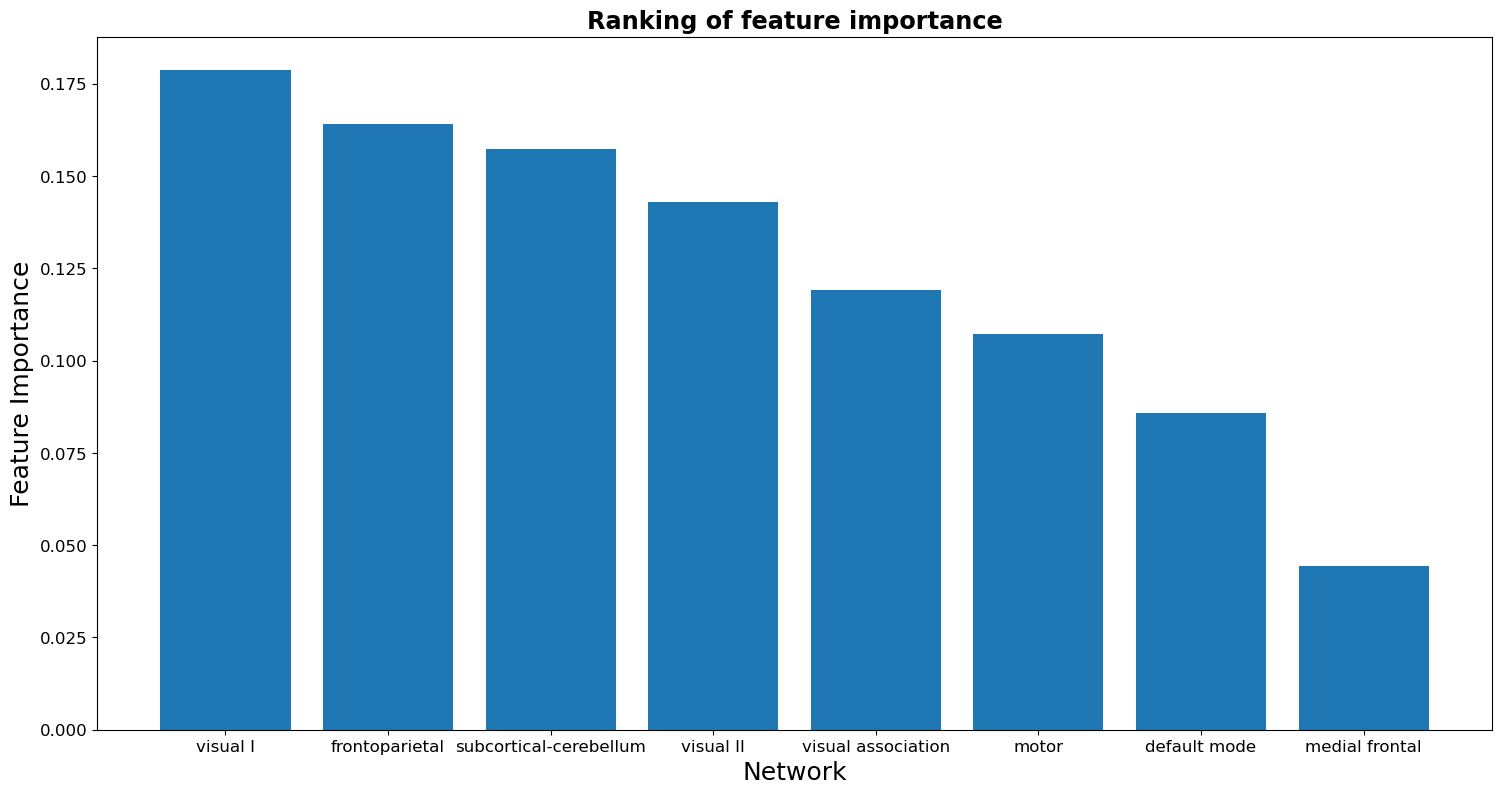

[0]	train-mlogloss:1.06812	test-mlogloss:1.08624
[1]	train-mlogloss:1.04177	test-mlogloss:1.10450
[2]	train-mlogloss:1.01453	test-mlogloss:1.09177
[3]	train-mlogloss:0.98813	test-mlogloss:1.07545
[4]	train-mlogloss:0.96052	test-mlogloss:1.06150
[5]	train-mlogloss:0.93736	test-mlogloss:1.03033
[6]	train-mlogloss:0.91214	test-mlogloss:1.01688
[7]	train-mlogloss:0.89100	test-mlogloss:1.00265
[8]	train-mlogloss:0.86834	test-mlogloss:0.98226
[9]	train-mlogloss:0.84708	test-mlogloss:0.96658
[10]	train-mlogloss:0.82722	test-mlogloss:0.98495
[11]	train-mlogloss:0.80815	test-mlogloss:0.97135
[12]	train-mlogloss:0.78901	test-mlogloss:0.97643
[13]	train-mlogloss:0.77145	test-mlogloss:0.97847
[14]	train-mlogloss:0.75323	test-mlogloss:0.96956
0.6666666666666666
[0]	train-mlogloss:1.07032	test-mlogloss:1.07677
[1]	train-mlogloss:1.04536	test-mlogloss:1.08355
[2]	train-mlogloss:1.02136	test-mlogloss:1.07449
[3]	train-mlogloss:0.99698	test-mlogloss:1.04616
[4]	train-mlogloss:0.97070	test-mlogloss:1.03

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


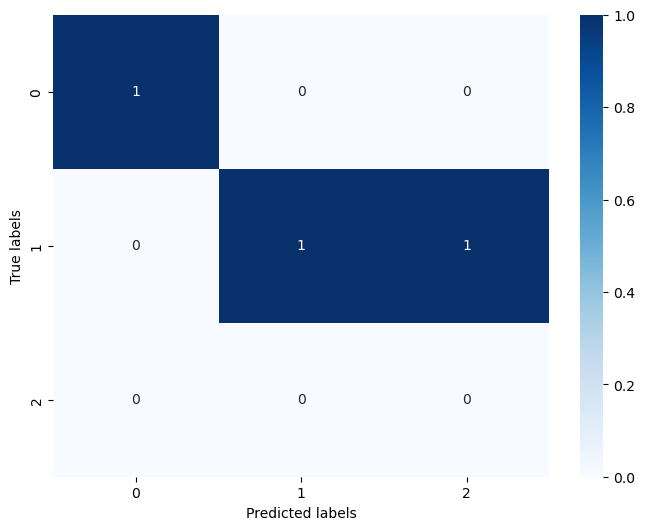

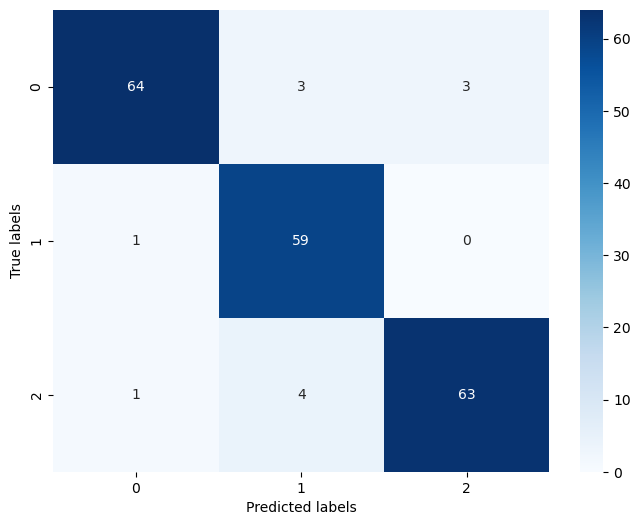

0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
{'medial frontal': 3.1886585800836094, 'frontoparietal': 7.289018137591383, 'default mode': 5.489254018699755, 'subcortical-cerebellum': 6.82908848096849, 'motor': 5.093080502490123, 'visual I': 5.721449429442151, 'visual II': 5.796208011993619, 'visual association': 5.593242838730869}


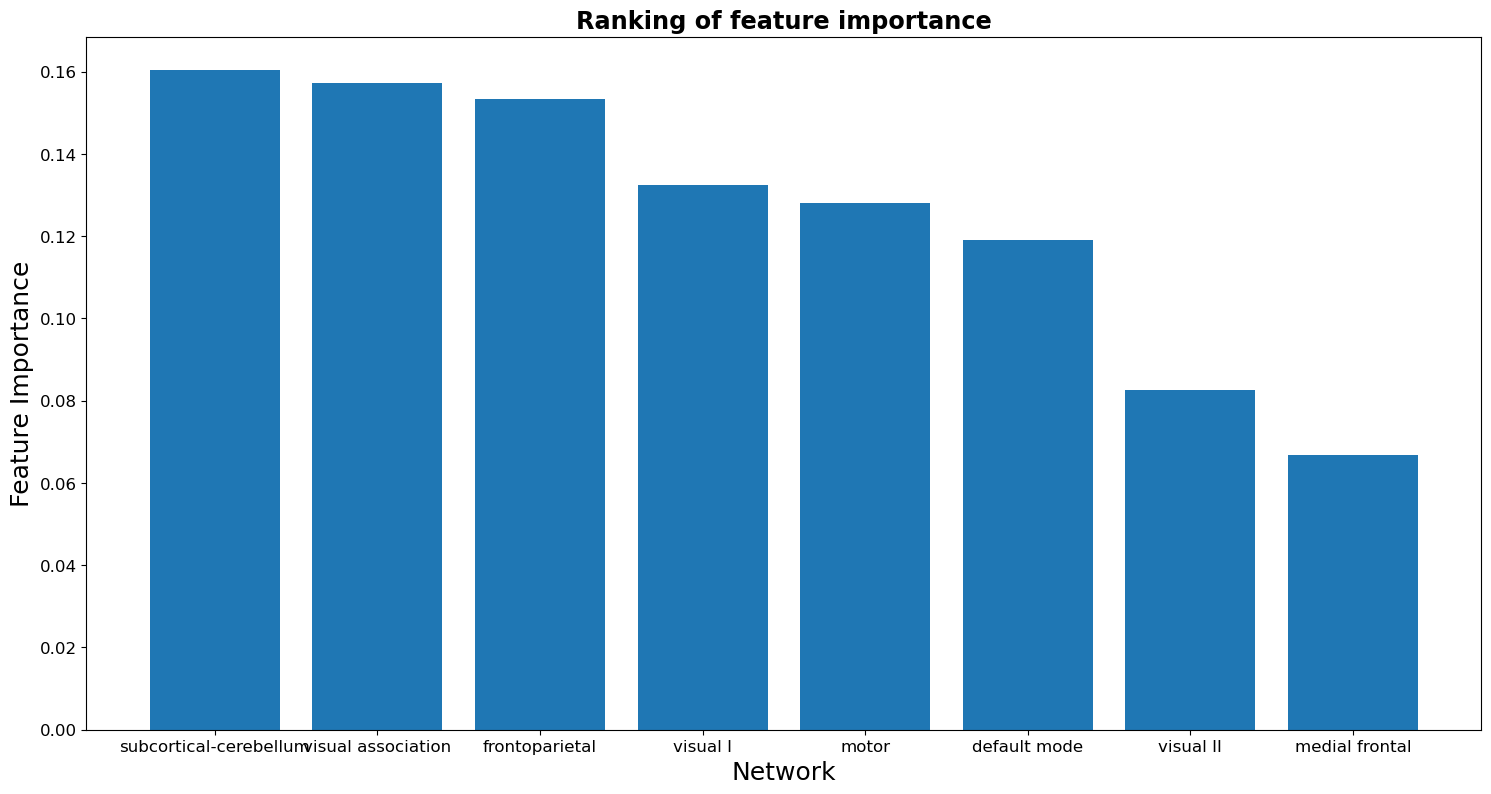

[0]	train-mlogloss:1.06826	test-mlogloss:1.06985
[1]	train-mlogloss:1.04349	test-mlogloss:1.03877
[2]	train-mlogloss:1.01415	test-mlogloss:1.00872
[3]	train-mlogloss:0.98796	test-mlogloss:0.99063
[4]	train-mlogloss:0.96058	test-mlogloss:0.98116
[5]	train-mlogloss:0.93890	test-mlogloss:0.98241
[6]	train-mlogloss:0.91407	test-mlogloss:0.97563
[7]	train-mlogloss:0.89020	test-mlogloss:0.95350
[8]	train-mlogloss:0.86772	test-mlogloss:0.93329
[9]	train-mlogloss:0.84729	test-mlogloss:0.92936
[10]	train-mlogloss:0.82633	test-mlogloss:0.93085
[11]	train-mlogloss:0.80659	test-mlogloss:0.92751
[12]	train-mlogloss:0.78857	test-mlogloss:0.93274
[13]	train-mlogloss:0.77109	test-mlogloss:0.93793
[14]	train-mlogloss:0.75317	test-mlogloss:0.94522
1.0
[0]	train-mlogloss:1.07044	test-mlogloss:1.06878
[1]	train-mlogloss:1.04648	test-mlogloss:1.03810
[2]	train-mlogloss:1.02004	test-mlogloss:1.01717
[3]	train-mlogloss:0.99591	test-mlogloss:0.98230
[4]	train-mlogloss:0.96882	test-mlogloss:0.97224
[5]	train-m

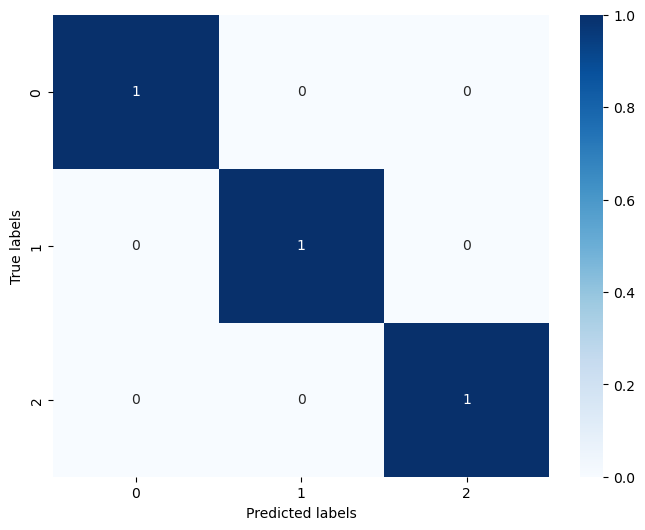

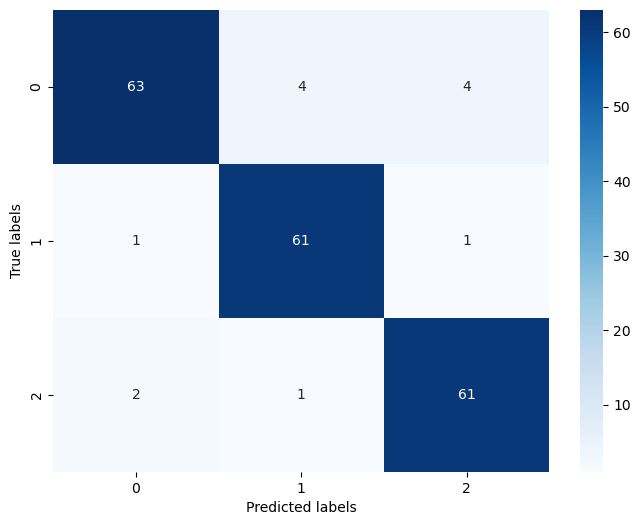

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
{'medial frontal': 3.2809149415516714, 'frontoparietal': 7.442025011594787, 'default mode': 5.59329869302207, 'subcortical-cerebellum': 6.982678238301431, 'motor': 5.226852226618813, 'visual I': 5.845312136968715, 'visual II': 5.928328233355288, 'visual association': 5.700590518587225}


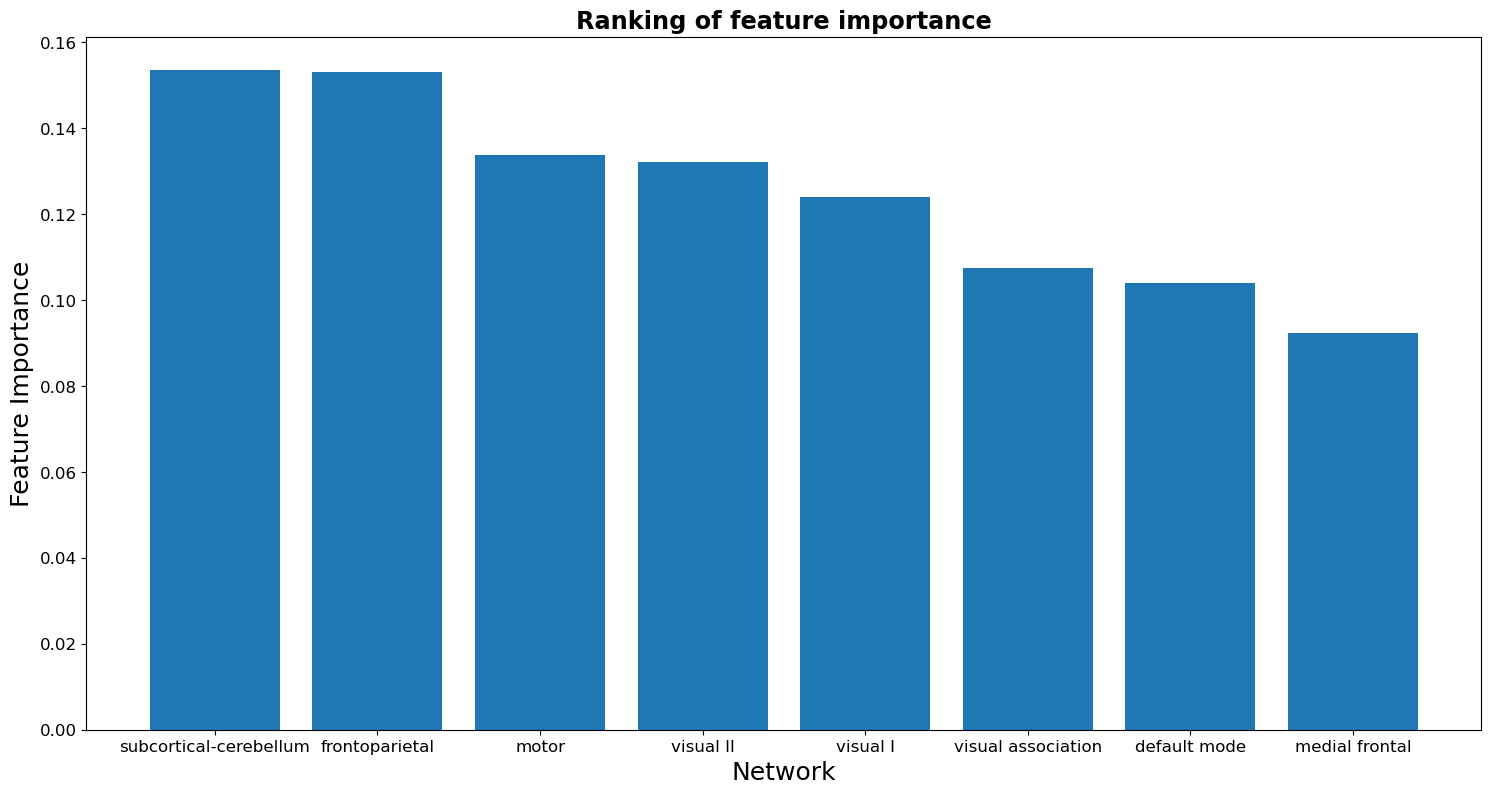

[0]	train-mlogloss:1.06593	test-mlogloss:1.07855
[1]	train-mlogloss:1.03899	test-mlogloss:1.07658
[2]	train-mlogloss:1.00915	test-mlogloss:1.05744
[3]	train-mlogloss:0.98399	test-mlogloss:1.05053
[4]	train-mlogloss:0.95746	test-mlogloss:1.04053
[5]	train-mlogloss:0.93423	test-mlogloss:1.05860
[6]	train-mlogloss:0.91050	test-mlogloss:1.03985
[7]	train-mlogloss:0.88977	test-mlogloss:1.05799
[8]	train-mlogloss:0.86451	test-mlogloss:1.07350
0.3333333333333333
[0]	train-mlogloss:1.06974	test-mlogloss:1.08663
[1]	train-mlogloss:1.04383	test-mlogloss:1.08590
[2]	train-mlogloss:1.01634	test-mlogloss:1.08228
[3]	train-mlogloss:0.99114	test-mlogloss:1.08005
[4]	train-mlogloss:0.96514	test-mlogloss:1.07809
[5]	train-mlogloss:0.94215	test-mlogloss:1.09714
[6]	train-mlogloss:0.91859	test-mlogloss:1.08791
[7]	train-mlogloss:0.89712	test-mlogloss:1.10769
[8]	train-mlogloss:0.87305	test-mlogloss:1.10906
0.3333333333333333
[0]	train-mlogloss:1.07050	test-mlogloss:1.08912
[1]	train-mlogloss:1.04570	test

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


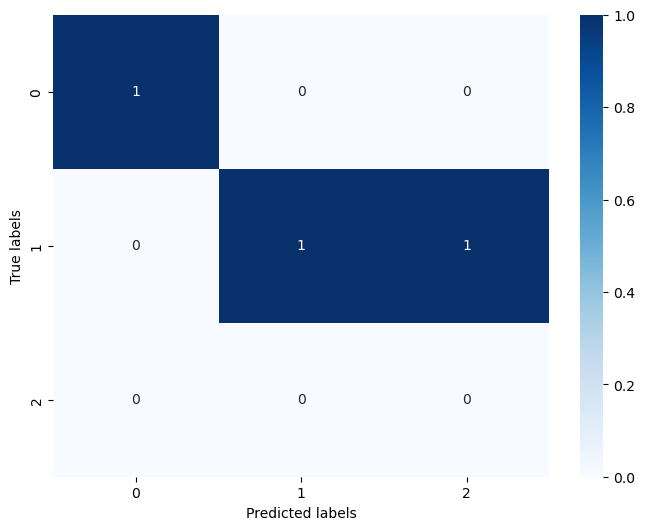

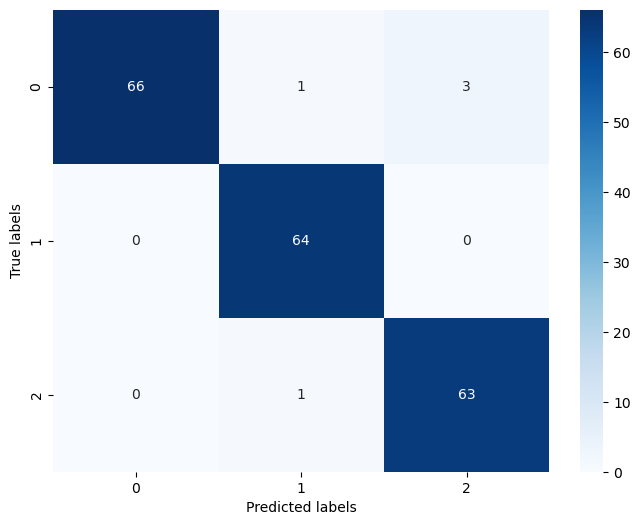

0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
{'medial frontal': 3.3480251791087534, 'frontoparietal': 7.625196483515293, 'default mode': 5.6614155841425085, 'subcortical-cerebellum': 7.164323281289266, 'motor': 5.359193615081378, 'visual I': 5.996683006125245, 'visual II': 6.014825872873304, 'visual association': 5.83033697786425}


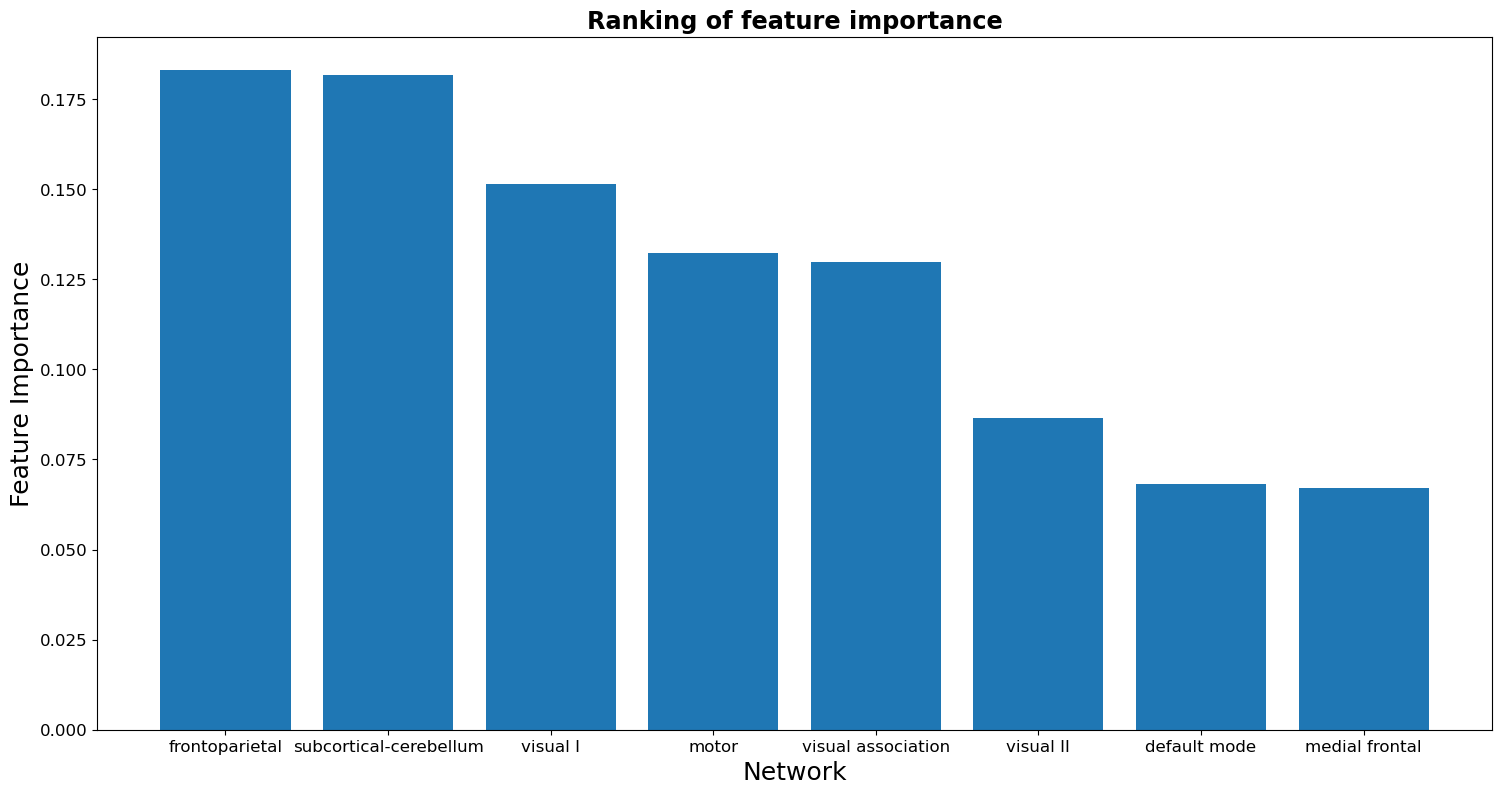

[0]	train-mlogloss:1.06577	test-mlogloss:1.07773
[1]	train-mlogloss:1.04139	test-mlogloss:1.08175
[2]	train-mlogloss:1.01223	test-mlogloss:1.07249
[3]	train-mlogloss:0.98485	test-mlogloss:1.11960
[4]	train-mlogloss:0.95944	test-mlogloss:1.09905
[5]	train-mlogloss:0.93859	test-mlogloss:1.07975
[6]	train-mlogloss:0.91700	test-mlogloss:1.06839
[7]	train-mlogloss:0.89410	test-mlogloss:1.05815
[8]	train-mlogloss:0.86974	test-mlogloss:1.01508
0.6666666666666666
[0]	train-mlogloss:1.06978	test-mlogloss:1.07775
[1]	train-mlogloss:1.04554	test-mlogloss:1.07421
[2]	train-mlogloss:1.01958	test-mlogloss:1.07230
[3]	train-mlogloss:0.99276	test-mlogloss:1.11887
[4]	train-mlogloss:0.96727	test-mlogloss:1.09836
[5]	train-mlogloss:0.94751	test-mlogloss:1.07729
[6]	train-mlogloss:0.92697	test-mlogloss:1.04245
[7]	train-mlogloss:0.90339	test-mlogloss:1.02661
[8]	train-mlogloss:0.87970	test-mlogloss:1.00223
0.6666666666666666
[0]	train-mlogloss:1.07049	test-mlogloss:1.07614
[1]	train-mlogloss:1.04769	test

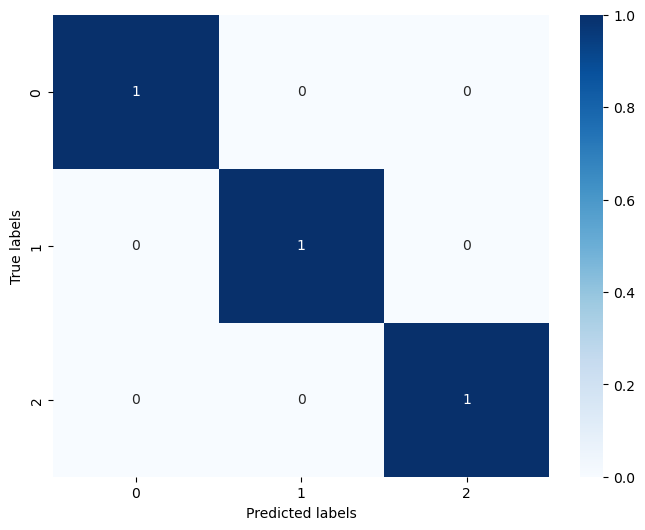

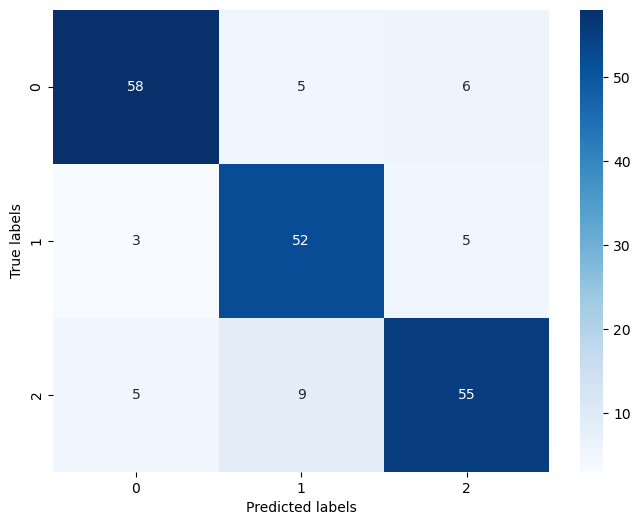

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
{'medial frontal': 3.400209840501927, 'frontoparietal': 7.821042448037908, 'default mode': 5.75221689496663, 'subcortical-cerebellum': 7.302206753281451, 'motor': 5.462101767348717, 'visual I': 6.181648639285494, 'visual II': 6.082086103113395, 'visual association': 5.998487553464476}


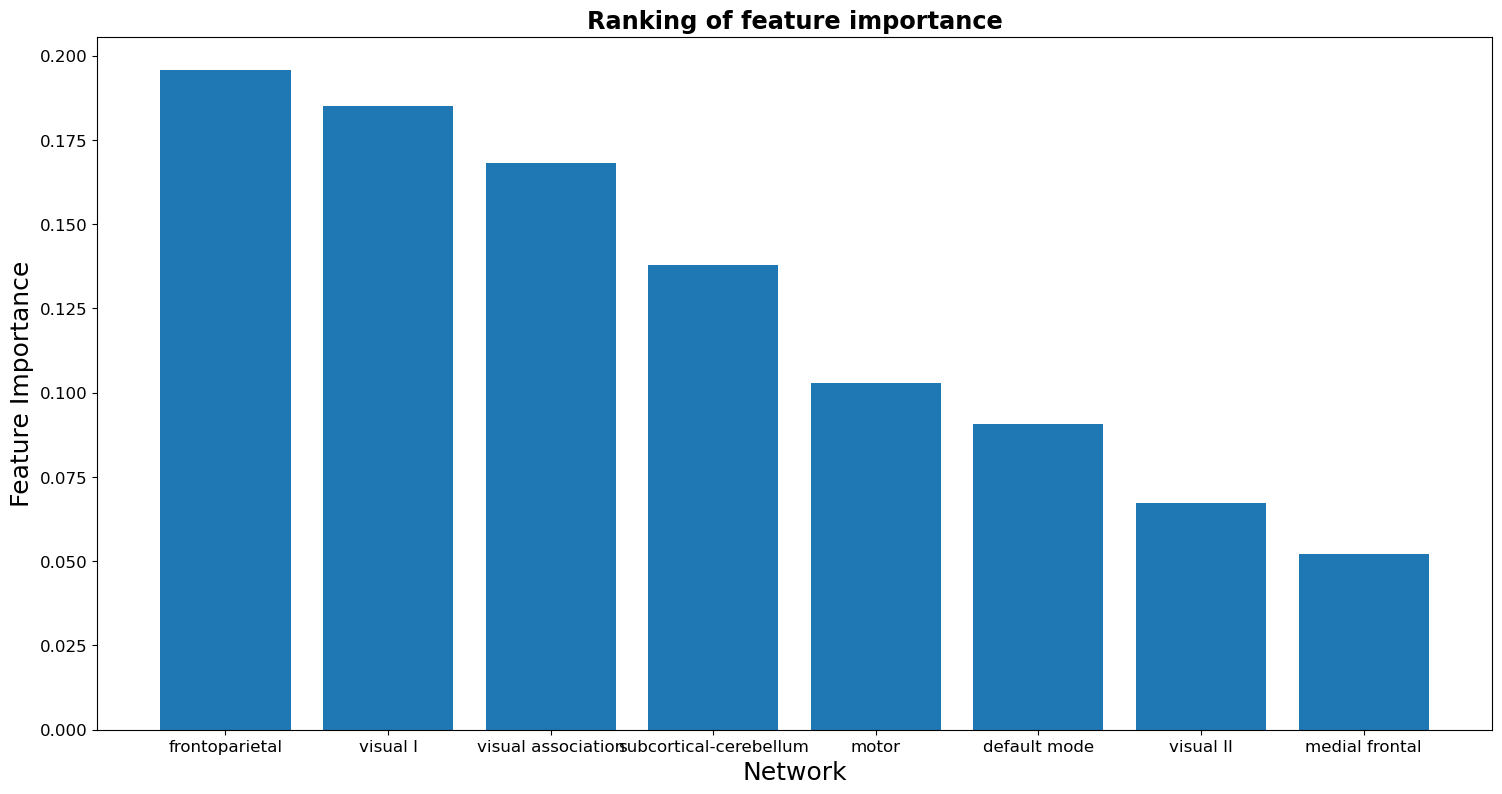

[0]	train-mlogloss:1.06824	test-mlogloss:1.08985
[1]	train-mlogloss:1.04132	test-mlogloss:1.10561
[2]	train-mlogloss:1.01244	test-mlogloss:1.08849
[3]	train-mlogloss:0.98804	test-mlogloss:1.05966
[4]	train-mlogloss:0.96196	test-mlogloss:1.03303
[5]	train-mlogloss:0.94033	test-mlogloss:1.01891
[6]	train-mlogloss:0.91945	test-mlogloss:1.01428
[7]	train-mlogloss:0.89638	test-mlogloss:1.00937
[8]	train-mlogloss:0.87171	test-mlogloss:0.99035
[9]	train-mlogloss:0.85146	test-mlogloss:0.99392
[10]	train-mlogloss:0.83215	test-mlogloss:0.98988
[11]	train-mlogloss:0.81363	test-mlogloss:0.99301
[12]	train-mlogloss:0.79530	test-mlogloss:1.00765
[13]	train-mlogloss:0.77867	test-mlogloss:1.01505
[14]	train-mlogloss:0.76137	test-mlogloss:0.99701
[15]	train-mlogloss:0.74436	test-mlogloss:0.98482
[16]	train-mlogloss:0.72719	test-mlogloss:0.98950
[17]	train-mlogloss:0.71024	test-mlogloss:0.98458
[18]	train-mlogloss:0.69653	test-mlogloss:0.98999
[19]	train-mlogloss:0.68129	test-mlogloss:0.97337
[20]	train

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


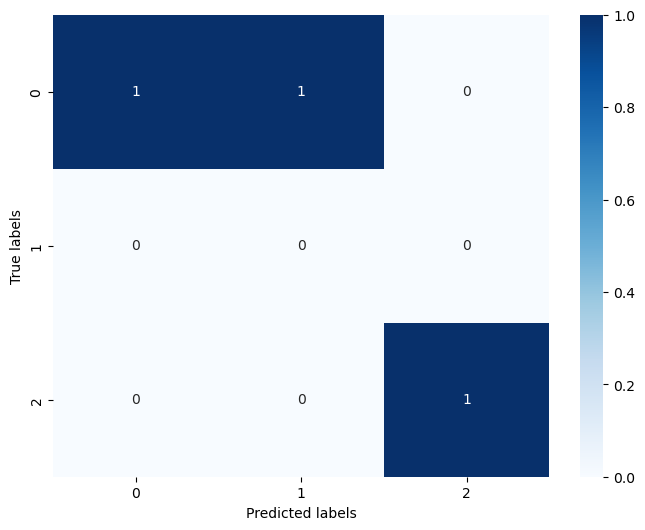

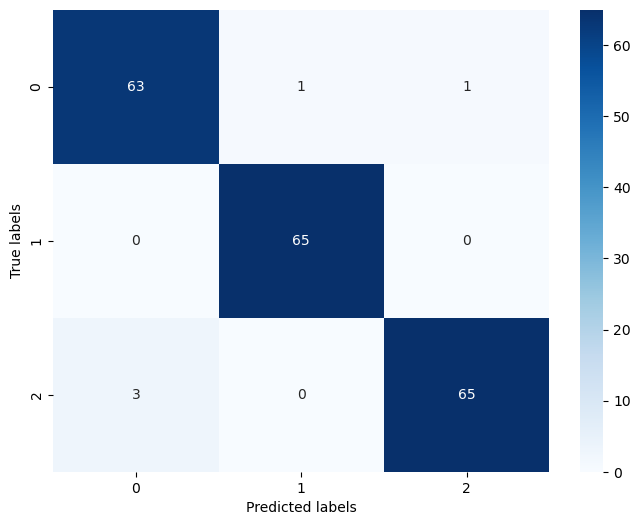

0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
{'medial frontal': 3.468729998476922, 'frontoparietal': 7.993716910314467, 'default mode': 5.865119427993611, 'subcortical-cerebellum': 7.440700527127881, 'motor': 5.58313328275364, 'visual I': 6.312113788561116, 'visual II': 6.212551252389017, 'visual association': 6.123934812383343}


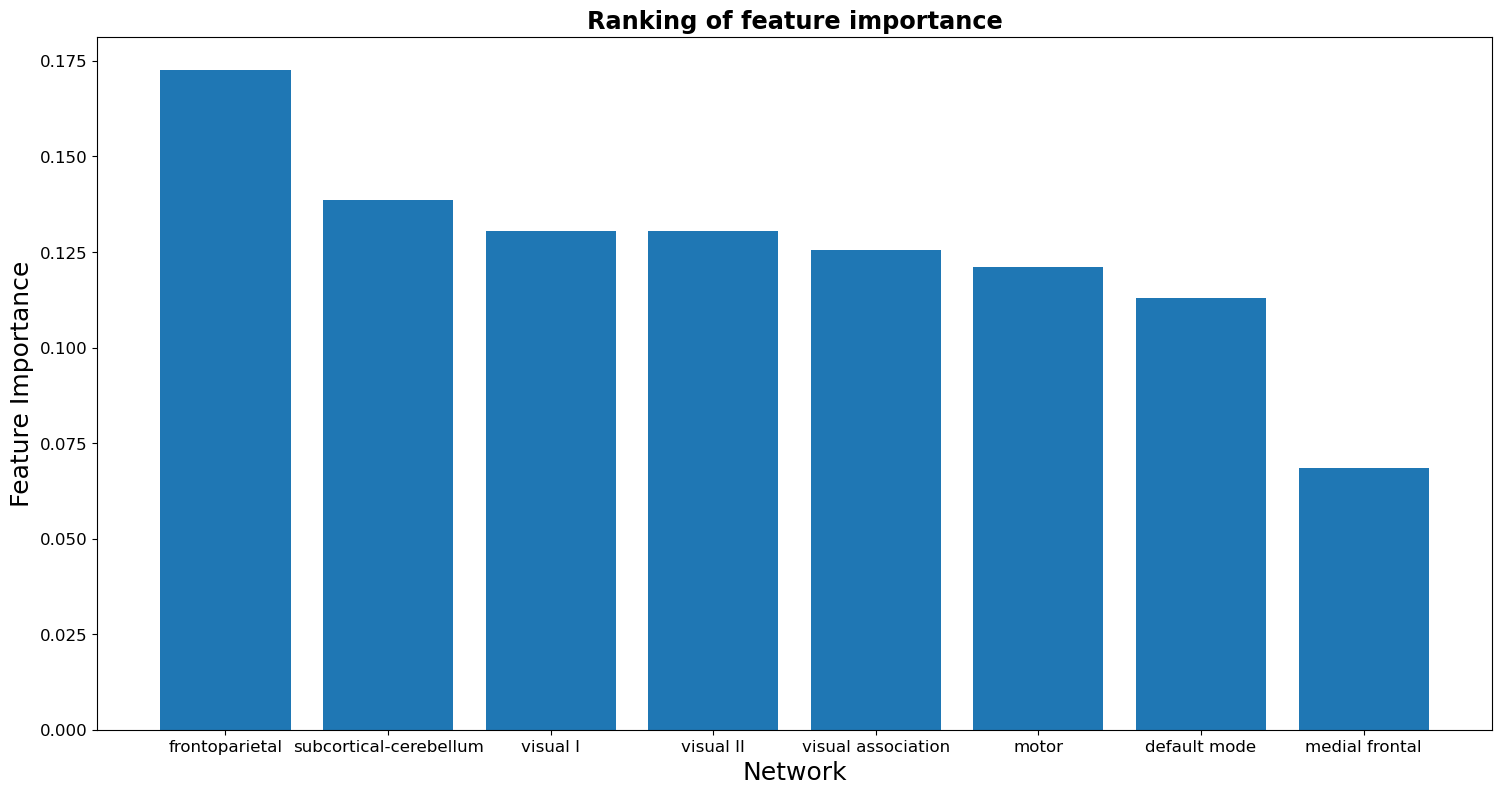

[0]	train-mlogloss:1.06573	test-mlogloss:1.14608
[1]	train-mlogloss:1.03727	test-mlogloss:1.16761
[2]	train-mlogloss:1.00811	test-mlogloss:1.16170
[3]	train-mlogloss:0.98073	test-mlogloss:1.18178
[4]	train-mlogloss:0.95376	test-mlogloss:1.17918
[5]	train-mlogloss:0.92953	test-mlogloss:1.20500
[6]	train-mlogloss:0.90493	test-mlogloss:1.17833
[7]	train-mlogloss:0.87938	test-mlogloss:1.19469
[8]	train-mlogloss:0.85721	test-mlogloss:1.21929
[9]	train-mlogloss:0.83666	test-mlogloss:1.19321
0.0
[0]	train-mlogloss:1.06796	test-mlogloss:1.14445
[1]	train-mlogloss:1.03972	test-mlogloss:1.16478
[2]	train-mlogloss:1.01186	test-mlogloss:1.17570
[3]	train-mlogloss:0.98668	test-mlogloss:1.18124
[4]	train-mlogloss:0.96014	test-mlogloss:1.18324
[5]	train-mlogloss:0.93753	test-mlogloss:1.21733
[6]	train-mlogloss:0.91378	test-mlogloss:1.20589
[7]	train-mlogloss:0.88863	test-mlogloss:1.21382
[8]	train-mlogloss:0.86455	test-mlogloss:1.19389
[9]	train-mlogloss:0.84416	test-mlogloss:1.16725
[10]	train-mlogl

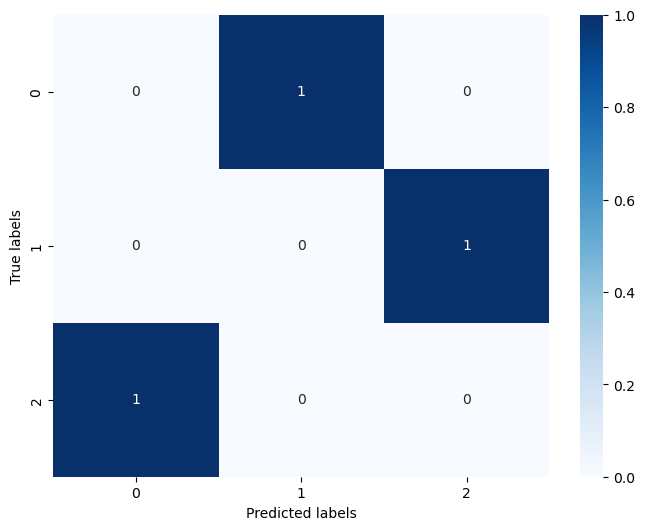

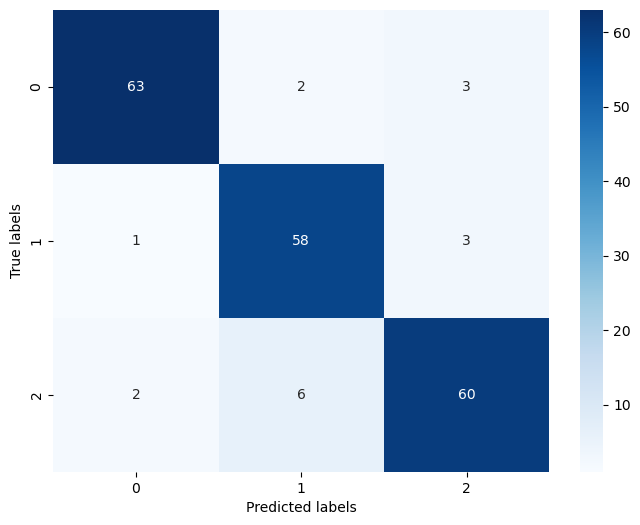

{'medial frontal': 3.544930288880168, 'frontoparietal': 8.165065691675776, 'default mode': 5.995699016548264, 'subcortical-cerebellum': 7.588021088574156, 'motor': 5.711703954561298, 'visual I': 6.434880923099679, 'visual II': 6.324157738333165, 'visual association': 6.235541298327491}


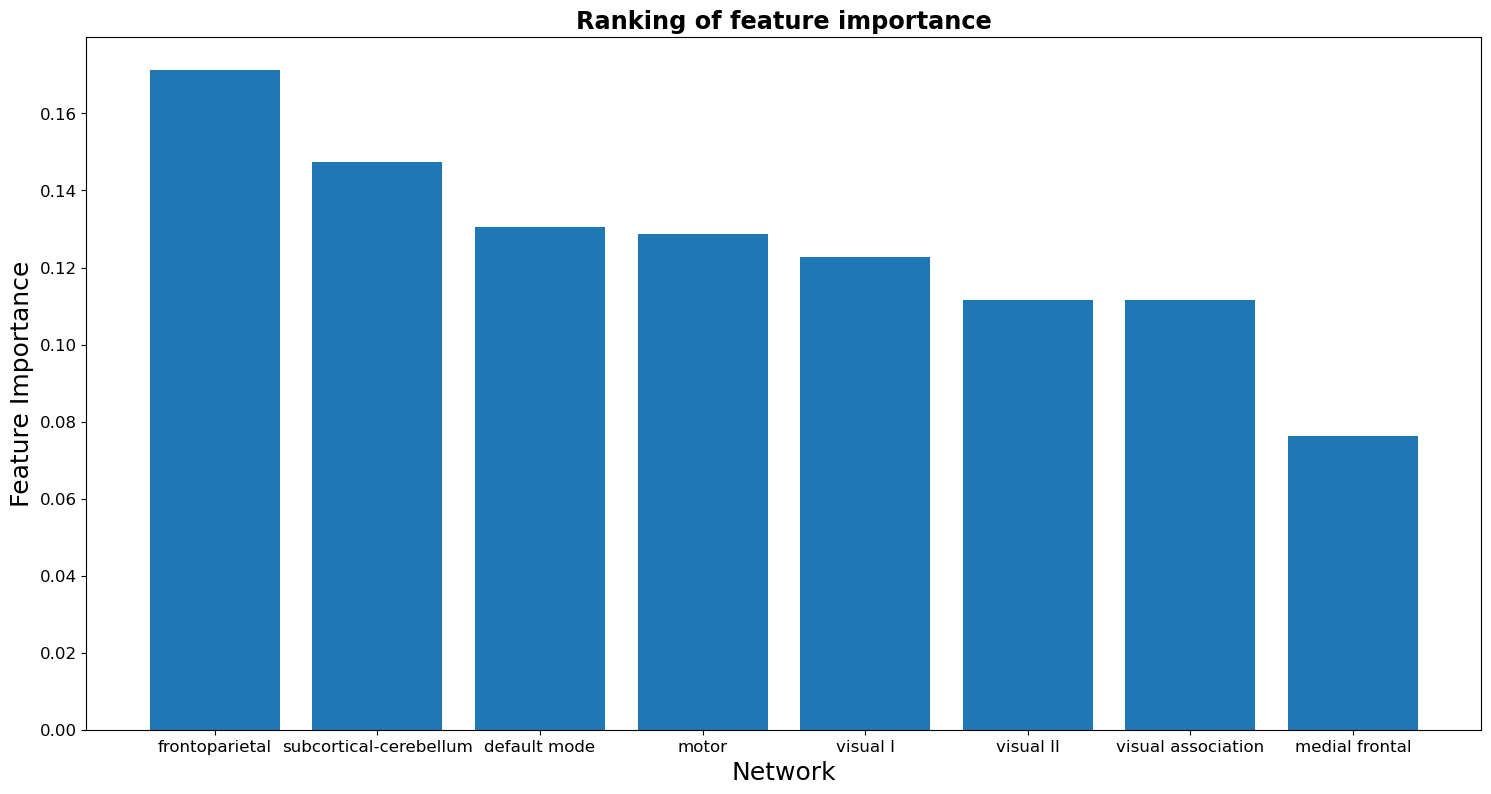

[0]	train-mlogloss:1.06655	test-mlogloss:1.10340
[1]	train-mlogloss:1.03912	test-mlogloss:1.12382
[2]	train-mlogloss:1.00981	test-mlogloss:1.11420
[3]	train-mlogloss:0.98367	test-mlogloss:1.11841
[4]	train-mlogloss:0.95760	test-mlogloss:1.10977
[5]	train-mlogloss:0.93357	test-mlogloss:1.10317
[6]	train-mlogloss:0.90890	test-mlogloss:1.10706
[7]	train-mlogloss:0.88475	test-mlogloss:1.10115
[8]	train-mlogloss:0.85998	test-mlogloss:1.08694
[9]	train-mlogloss:0.83934	test-mlogloss:1.07936
[10]	train-mlogloss:0.81950	test-mlogloss:1.10283
[11]	train-mlogloss:0.80072	test-mlogloss:1.12556
0.3333333333333333
[0]	train-mlogloss:1.06844	test-mlogloss:1.09787
[1]	train-mlogloss:1.04175	test-mlogloss:1.11933
[2]	train-mlogloss:1.01532	test-mlogloss:1.12492
[3]	train-mlogloss:0.99055	test-mlogloss:1.12245
[4]	train-mlogloss:0.96586	test-mlogloss:1.11788
[5]	train-mlogloss:0.94319	test-mlogloss:1.12069
[6]	train-mlogloss:0.91887	test-mlogloss:1.12262
[7]	train-mlogloss:0.89462	test-mlogloss:1.11678

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


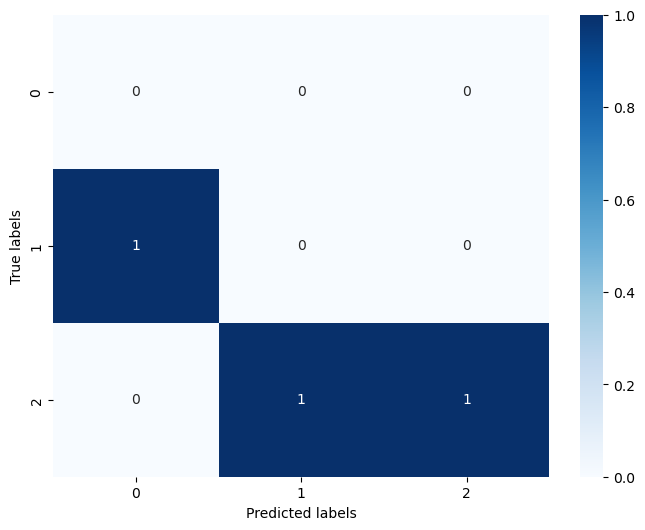

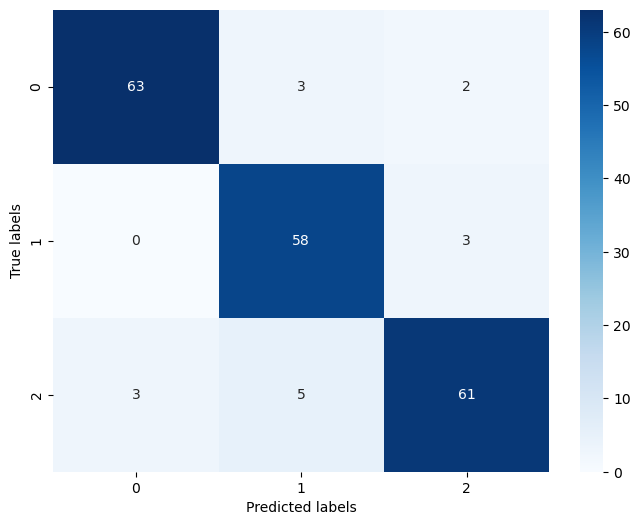

{'medial frontal': 3.6143101491805423, 'frontoparietal': 8.337216788891677, 'default mode': 6.105445341023401, 'subcortical-cerebellum': 7.7363818605498045, 'motor': 5.836083122299787, 'visual I': 6.57714467704893, 'visual II': 6.466421492282416, 'visual association': 6.326996568723438}


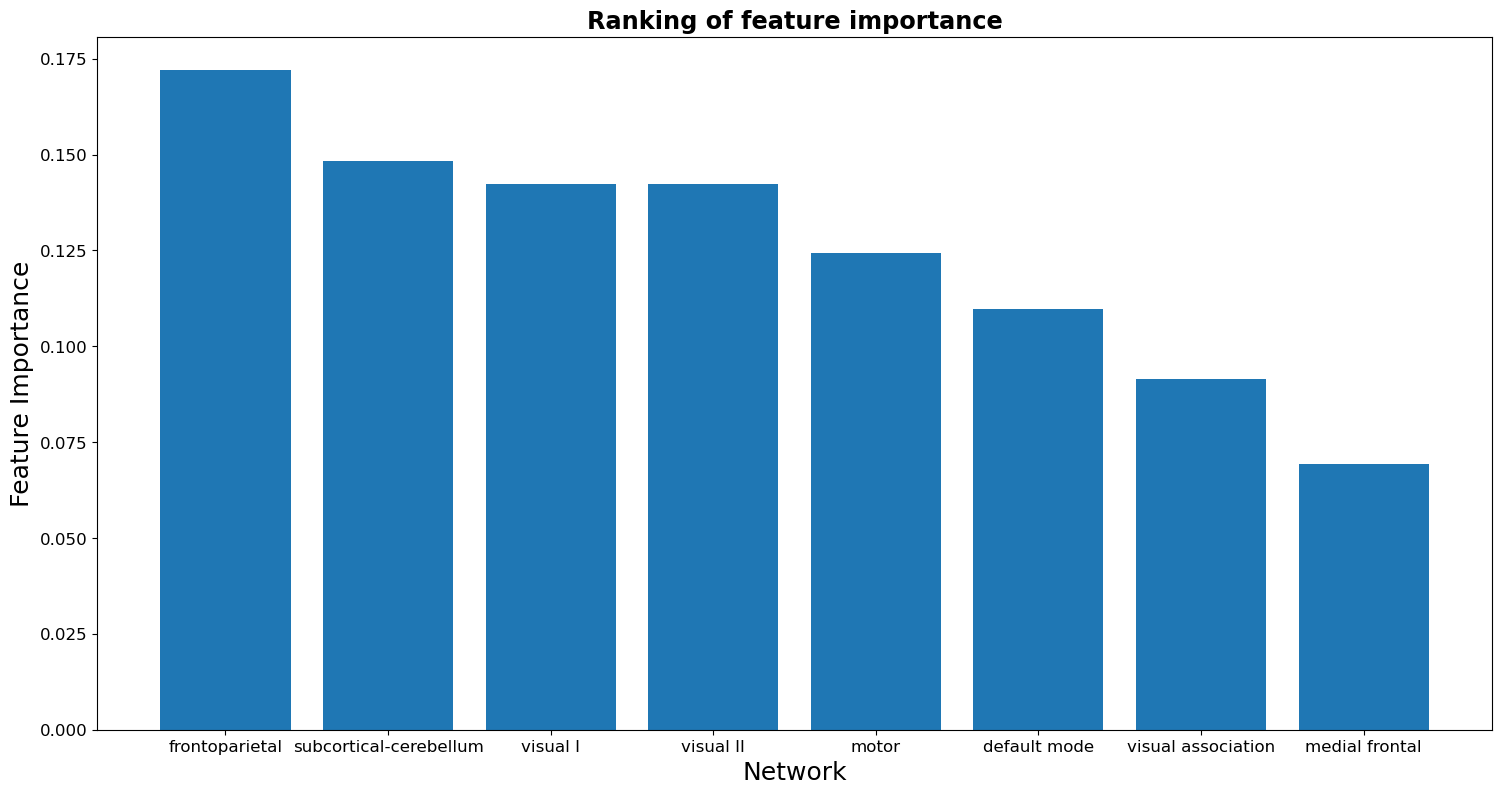

[0]	train-mlogloss:1.06747	test-mlogloss:1.07856
[1]	train-mlogloss:1.04050	test-mlogloss:1.06237
[2]	train-mlogloss:1.01196	test-mlogloss:1.04422
[3]	train-mlogloss:0.98773	test-mlogloss:1.01287
[4]	train-mlogloss:0.95865	test-mlogloss:1.06221
[5]	train-mlogloss:0.93527	test-mlogloss:1.03838
[6]	train-mlogloss:0.90992	test-mlogloss:1.03685
[7]	train-mlogloss:0.88636	test-mlogloss:1.03962
[8]	train-mlogloss:0.86197	test-mlogloss:1.05556
[9]	train-mlogloss:0.84050	test-mlogloss:1.04838
[10]	train-mlogloss:0.82034	test-mlogloss:1.06567
[11]	train-mlogloss:0.80232	test-mlogloss:1.08857
[12]	train-mlogloss:0.78471	test-mlogloss:1.10166
[13]	train-mlogloss:0.76661	test-mlogloss:1.09909
0.3333333333333333
[0]	train-mlogloss:1.06914	test-mlogloss:1.09852
[1]	train-mlogloss:1.04351	test-mlogloss:1.08822
[2]	train-mlogloss:1.01702	test-mlogloss:1.06307
[3]	train-mlogloss:0.99244	test-mlogloss:1.03493
[4]	train-mlogloss:0.96450	test-mlogloss:1.06979
[5]	train-mlogloss:0.94239	test-mlogloss:1.046

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


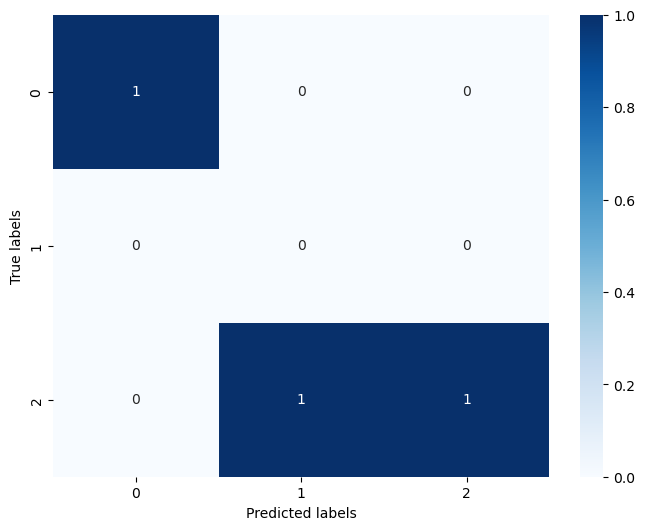

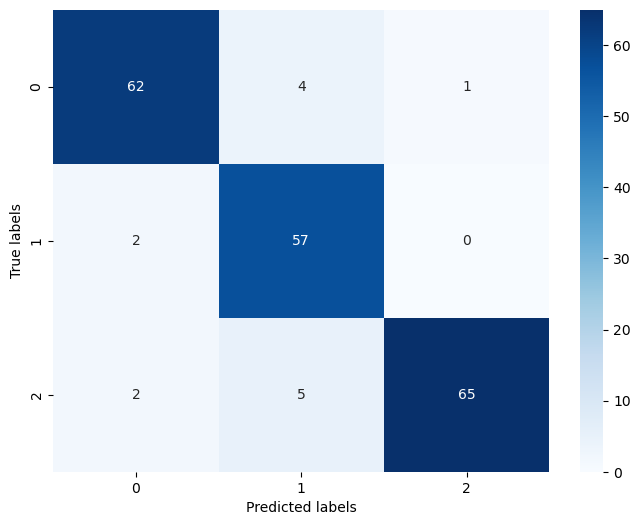

0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
{'medial frontal': 3.6790742641463705, 'frontoparietal': 8.509841727679271, 'default mode': 6.228699547317743, 'subcortical-cerebellum': 7.894199415699173, 'motor': 5.939381885670283, 'visual I': 6.727136568306595, 'visual II': 6.5707636775051395, 'visual association': 6.450902913675423}


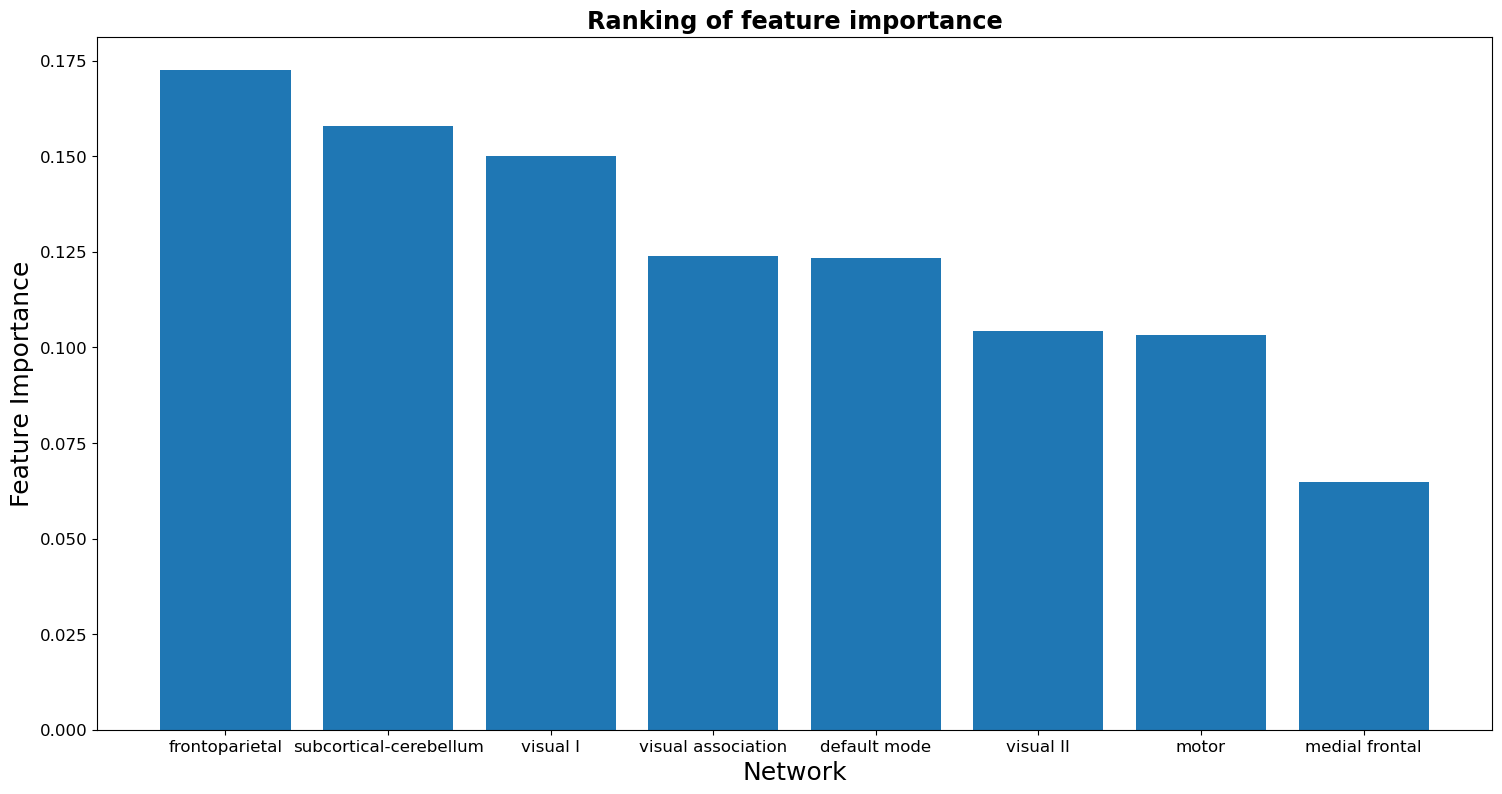

[0]	train-mlogloss:1.06770	test-mlogloss:1.05792
[1]	train-mlogloss:1.03971	test-mlogloss:1.08134
[2]	train-mlogloss:1.01051	test-mlogloss:1.11084
[3]	train-mlogloss:0.98426	test-mlogloss:1.11720
[4]	train-mlogloss:0.95702	test-mlogloss:1.10968
[5]	train-mlogloss:0.93382	test-mlogloss:1.13015
[6]	train-mlogloss:0.90871	test-mlogloss:1.12662
[7]	train-mlogloss:0.88640	test-mlogloss:1.14001
[8]	train-mlogloss:0.86362	test-mlogloss:1.13935
[9]	train-mlogloss:0.84353	test-mlogloss:1.15816
[10]	train-mlogloss:0.82427	test-mlogloss:1.16633
0.3333333333333333
[0]	train-mlogloss:1.06912	test-mlogloss:1.06034
[1]	train-mlogloss:1.04228	test-mlogloss:1.08433
[2]	train-mlogloss:1.01446	test-mlogloss:1.12138
[3]	train-mlogloss:0.98918	test-mlogloss:1.13424
[4]	train-mlogloss:0.96409	test-mlogloss:1.12837
[5]	train-mlogloss:0.94150	test-mlogloss:1.14290
[6]	train-mlogloss:0.91622	test-mlogloss:1.13933
[7]	train-mlogloss:0.89420	test-mlogloss:1.15721
[8]	train-mlogloss:0.86938	test-mlogloss:1.13662


D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


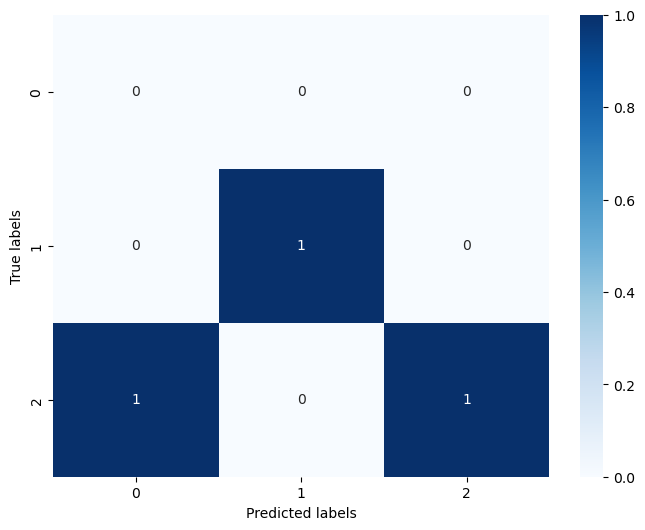

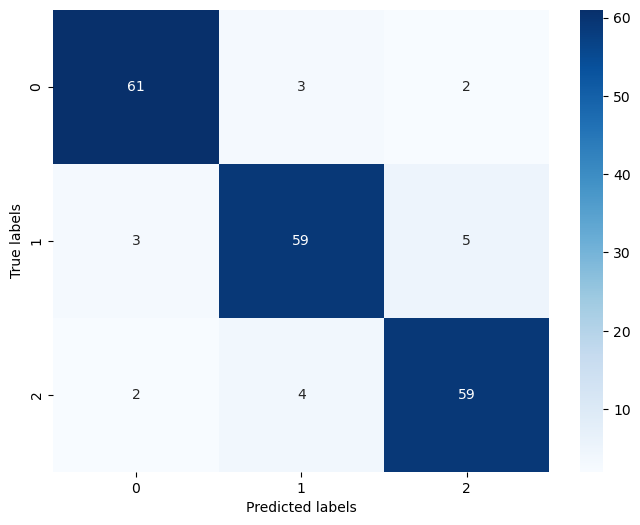

0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
{'medial frontal': 3.7379250707272327, 'frontoparietal': 8.649275828238503, 'default mode': 6.314033216859993, 'subcortical-cerebellum': 8.031154687804019, 'motor': 6.034197074050561, 'visual I': 6.927301965998293, 'visual II': 6.7393240124034115, 'visual association': 6.566788143917985}


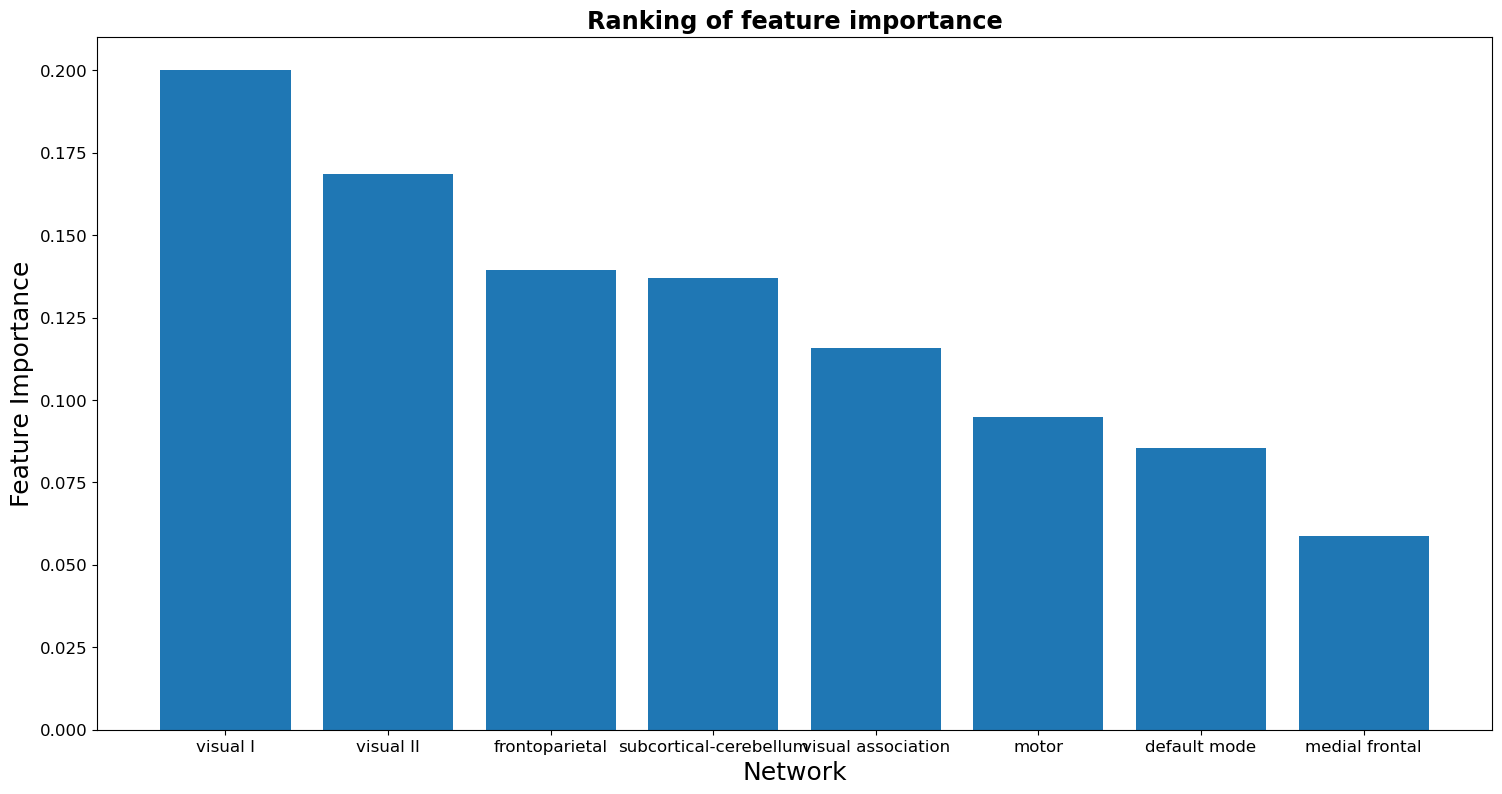

[0]	train-mlogloss:1.06730	test-mlogloss:1.08587
[1]	train-mlogloss:1.03810	test-mlogloss:1.08495
[2]	train-mlogloss:1.00774	test-mlogloss:1.11016
[3]	train-mlogloss:0.98258	test-mlogloss:1.12887
[4]	train-mlogloss:0.95653	test-mlogloss:1.11062
[5]	train-mlogloss:0.93230	test-mlogloss:1.15447
[6]	train-mlogloss:0.90673	test-mlogloss:1.17241
[7]	train-mlogloss:0.88165	test-mlogloss:1.16624
[8]	train-mlogloss:0.85892	test-mlogloss:1.17591
[9]	train-mlogloss:0.83968	test-mlogloss:1.20590
[10]	train-mlogloss:0.81916	test-mlogloss:1.23419
[11]	train-mlogloss:0.80063	test-mlogloss:1.20800
0.3333333333333333
[0]	train-mlogloss:1.06874	test-mlogloss:1.09678
[1]	train-mlogloss:1.04013	test-mlogloss:1.10276
[2]	train-mlogloss:1.01210	test-mlogloss:1.11793
[3]	train-mlogloss:0.98799	test-mlogloss:1.13720
[4]	train-mlogloss:0.96402	test-mlogloss:1.11980
[5]	train-mlogloss:0.94016	test-mlogloss:1.15430
[6]	train-mlogloss:0.91605	test-mlogloss:1.18421
[7]	train-mlogloss:0.89113	test-mlogloss:1.17951

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


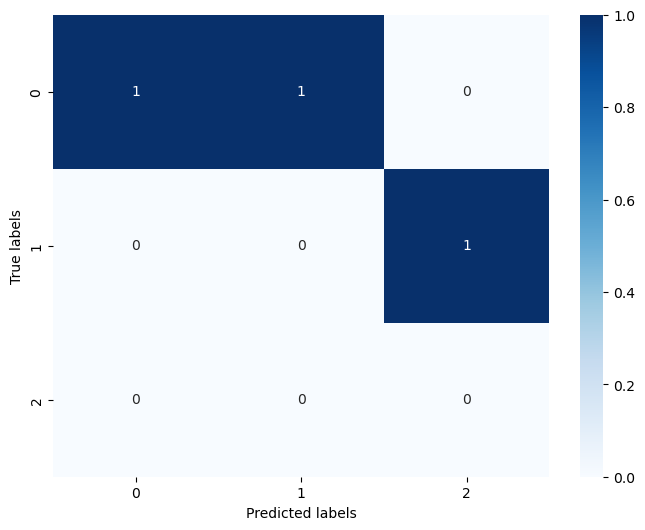

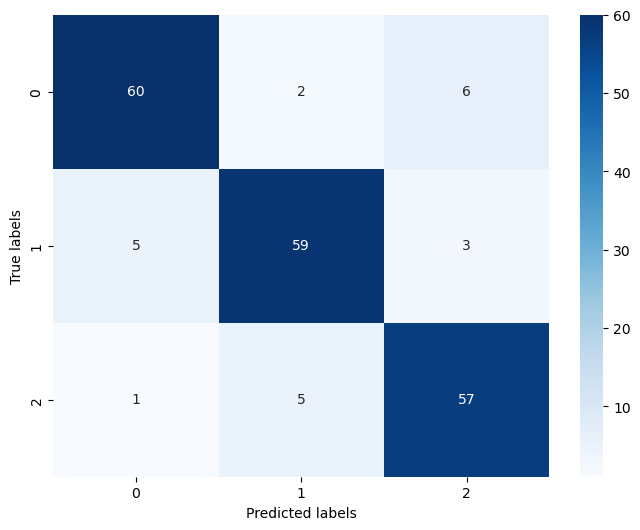

{'medial frontal': 3.7827371612049774, 'frontoparietal': 8.818545027143934, 'default mode': 6.443988279245453, 'subcortical-cerebellum': 8.185863095405756, 'motor': 6.16415213643602, 'visual I': 7.08201037360003, 'visual II': 6.821835163124338, 'visual association': 6.70086876383949}


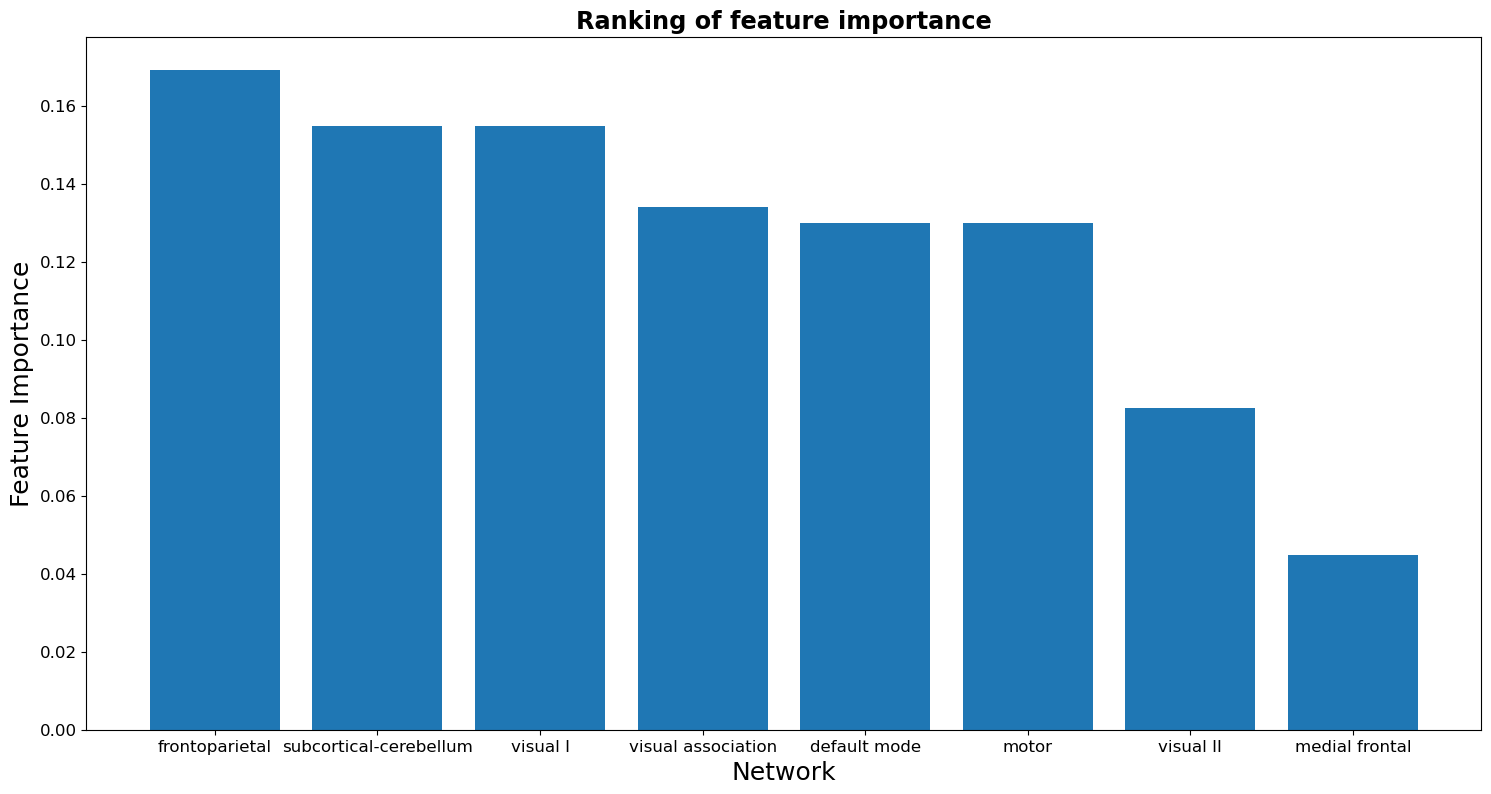

[0]	train-mlogloss:1.06831	test-mlogloss:1.08157
[1]	train-mlogloss:1.04167	test-mlogloss:1.06496
[2]	train-mlogloss:1.01294	test-mlogloss:1.05882
[3]	train-mlogloss:0.98914	test-mlogloss:1.02892
[4]	train-mlogloss:0.96431	test-mlogloss:1.02839
[5]	train-mlogloss:0.94058	test-mlogloss:1.01743
[6]	train-mlogloss:0.91686	test-mlogloss:1.00410
[7]	train-mlogloss:0.89575	test-mlogloss:0.97837
[8]	train-mlogloss:0.87476	test-mlogloss:0.96532
[9]	train-mlogloss:0.85311	test-mlogloss:0.95563
[10]	train-mlogloss:0.83270	test-mlogloss:0.95578
[11]	train-mlogloss:0.81313	test-mlogloss:0.96855
[12]	train-mlogloss:0.79634	test-mlogloss:0.98182
[13]	train-mlogloss:0.77751	test-mlogloss:0.95895
[14]	train-mlogloss:0.76167	test-mlogloss:0.93588
[15]	train-mlogloss:0.74552	test-mlogloss:0.95406
[16]	train-mlogloss:0.73129	test-mlogloss:0.94334
[17]	train-mlogloss:0.71633	test-mlogloss:0.92756
[18]	train-mlogloss:0.70219	test-mlogloss:0.91802
[19]	train-mlogloss:0.68671	test-mlogloss:0.91582
[20]	train

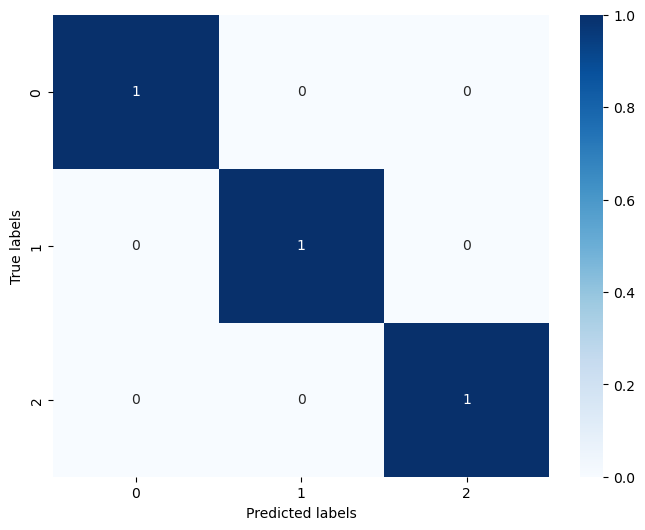

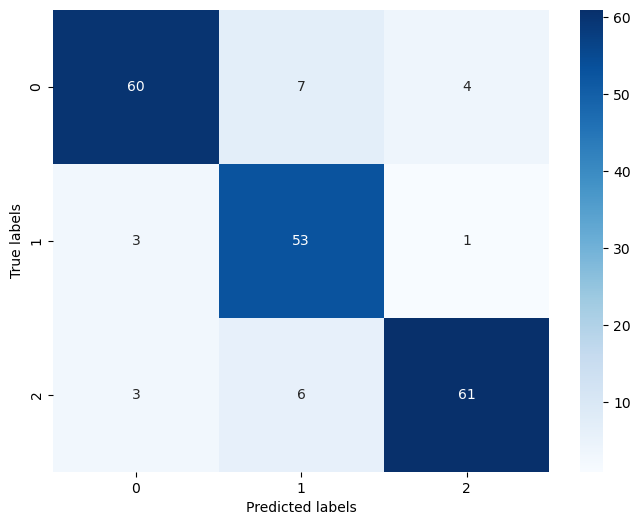

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
{'medial frontal': 3.851638554754426, 'frontoparietal': 8.983097767032616, 'default mode': 6.530574363805926, 'subcortical-cerebellum': 8.33387349636383, 'motor': 6.252070314605117, 'visual I': 7.281824414893431, 'visual II': 6.955044523986605, 'visual association': 6.811876564558046}


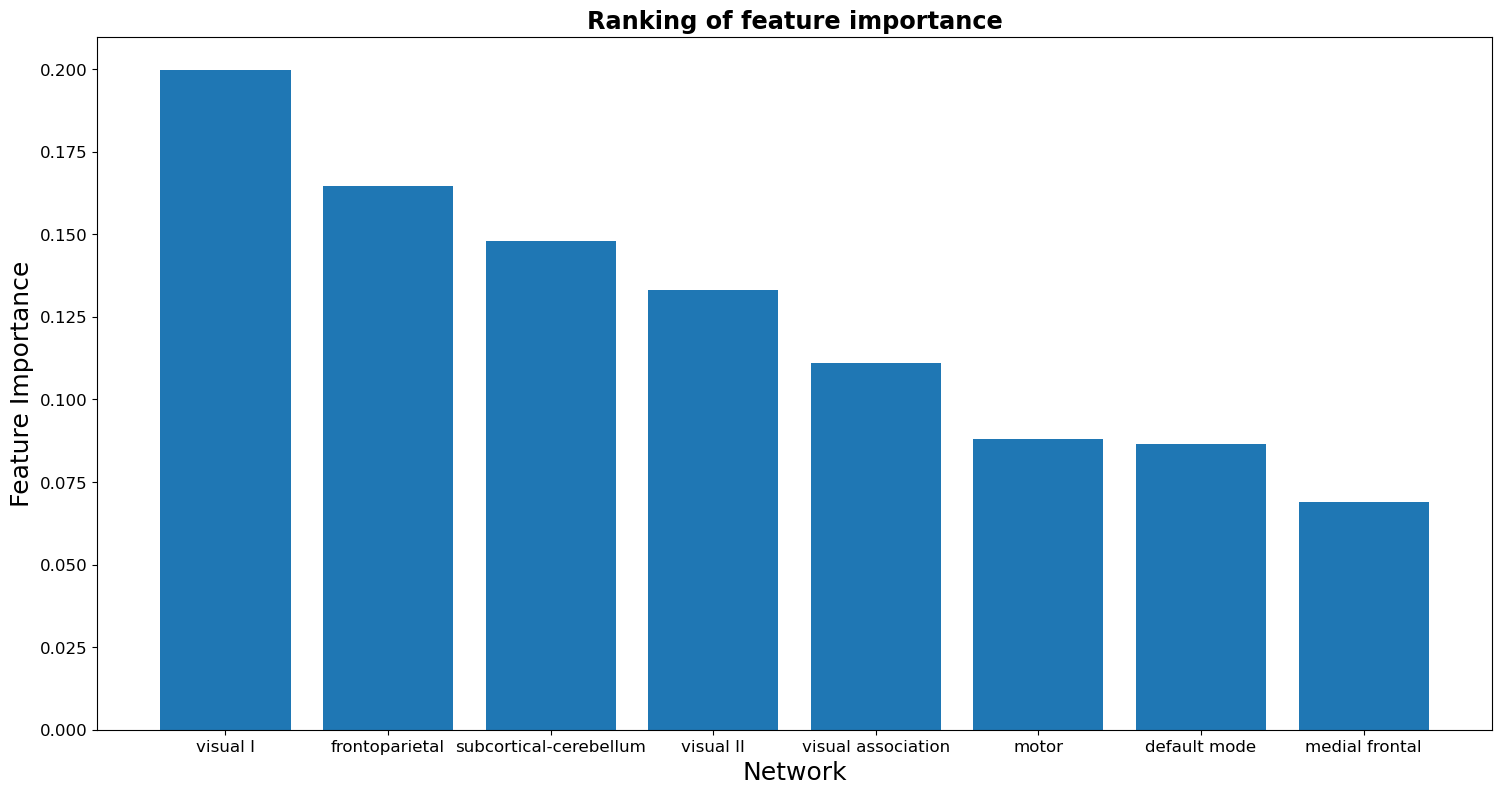

[0]	train-mlogloss:1.06737	test-mlogloss:1.09824
[1]	train-mlogloss:1.03715	test-mlogloss:1.11105
[2]	train-mlogloss:1.00692	test-mlogloss:1.10896
[3]	train-mlogloss:0.98023	test-mlogloss:1.10748
[4]	train-mlogloss:0.95271	test-mlogloss:1.09689
[5]	train-mlogloss:0.92956	test-mlogloss:1.14785
[6]	train-mlogloss:0.90482	test-mlogloss:1.14402
[7]	train-mlogloss:0.88069	test-mlogloss:1.11596
[8]	train-mlogloss:0.85966	test-mlogloss:1.11571
[9]	train-mlogloss:0.83888	test-mlogloss:1.12746
[10]	train-mlogloss:0.81954	test-mlogloss:1.13100
[11]	train-mlogloss:0.79830	test-mlogloss:1.12940
[12]	train-mlogloss:0.78225	test-mlogloss:1.10435
[13]	train-mlogloss:0.76519	test-mlogloss:1.11507
0.0
[0]	train-mlogloss:1.06844	test-mlogloss:1.09863
[1]	train-mlogloss:1.04015	test-mlogloss:1.11151
[2]	train-mlogloss:1.01329	test-mlogloss:1.10745
[3]	train-mlogloss:0.98795	test-mlogloss:1.10624
[4]	train-mlogloss:0.96196	test-mlogloss:1.10400
[5]	train-mlogloss:0.93898	test-mlogloss:1.15625
[6]	train-ml

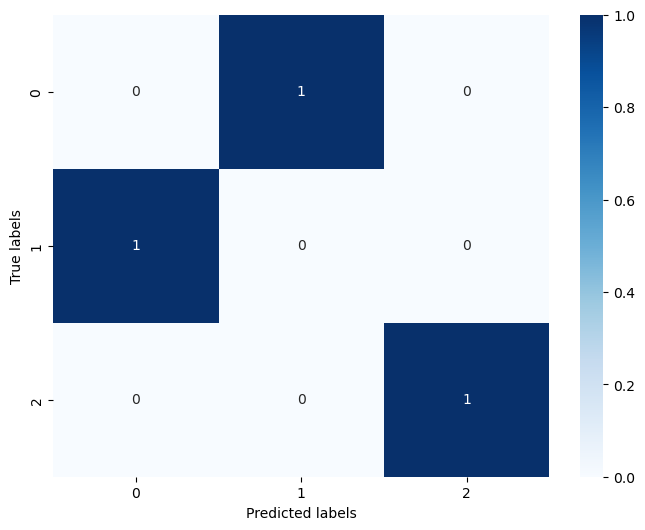

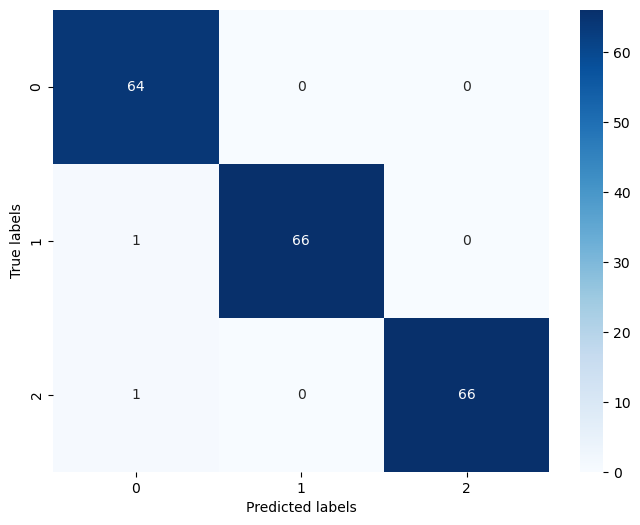

{'medial frontal': 3.907844953467189, 'frontoparietal': 9.117331872193686, 'default mode': 6.644673353192836, 'subcortical-cerebellum': 8.476346308508331, 'motor': 6.3824691596187275, 'visual I': 7.444822971160445, 'visual II': 7.099932129557284, 'visual association': 6.9265792523015}


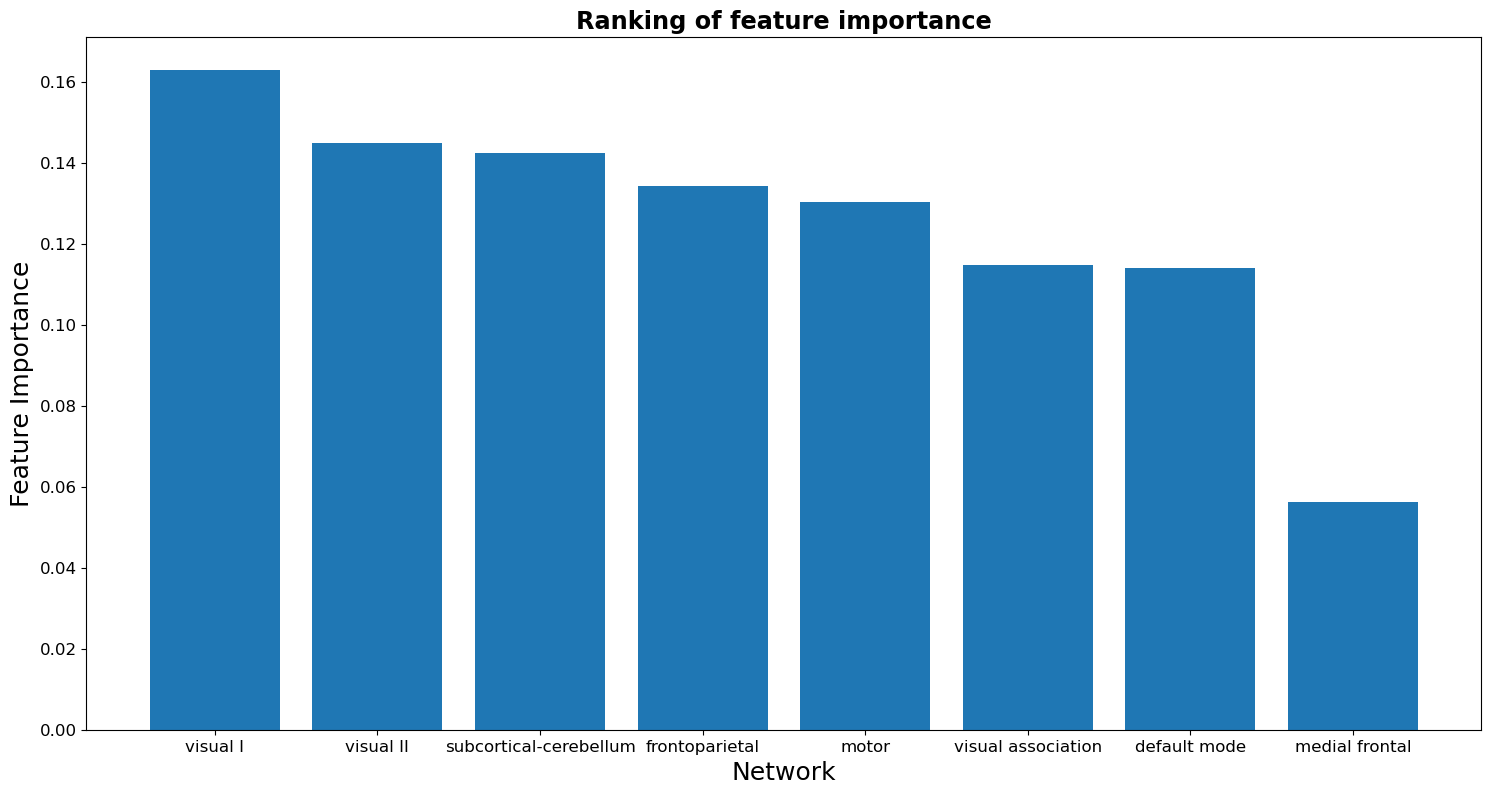

[0]	train-mlogloss:1.06805	test-mlogloss:1.09140
[1]	train-mlogloss:1.04108	test-mlogloss:1.06274
[2]	train-mlogloss:1.01241	test-mlogloss:1.02808
[3]	train-mlogloss:0.98550	test-mlogloss:1.01958
[4]	train-mlogloss:0.95932	test-mlogloss:0.99808
[5]	train-mlogloss:0.93703	test-mlogloss:0.96772
[6]	train-mlogloss:0.91273	test-mlogloss:0.93458
[7]	train-mlogloss:0.88979	test-mlogloss:0.91588
[8]	train-mlogloss:0.86616	test-mlogloss:0.87935
[9]	train-mlogloss:0.84544	test-mlogloss:0.84759
[10]	train-mlogloss:0.82646	test-mlogloss:0.81622
[11]	train-mlogloss:0.80588	test-mlogloss:0.80034
[12]	train-mlogloss:0.78923	test-mlogloss:0.79612
[13]	train-mlogloss:0.77171	test-mlogloss:0.78361
1.0
[0]	train-mlogloss:1.06980	test-mlogloss:1.09188
[1]	train-mlogloss:1.04312	test-mlogloss:1.07369
[2]	train-mlogloss:1.01827	test-mlogloss:1.03179
[3]	train-mlogloss:0.99210	test-mlogloss:1.01255
[4]	train-mlogloss:0.96695	test-mlogloss:0.99503
[5]	train-mlogloss:0.94474	test-mlogloss:0.96423
[6]	train-ml

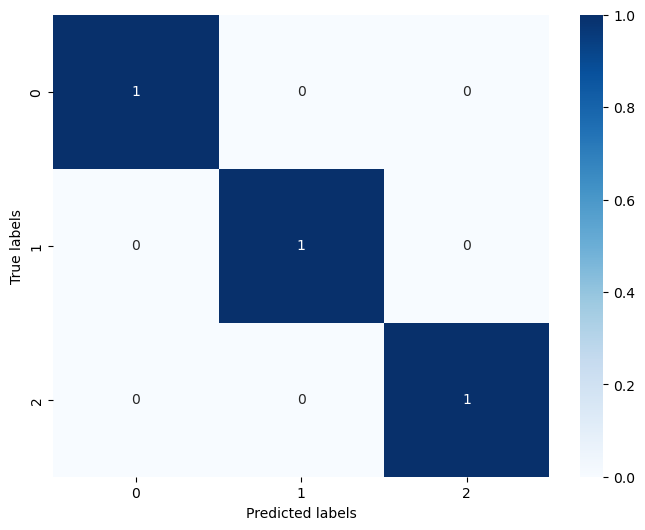

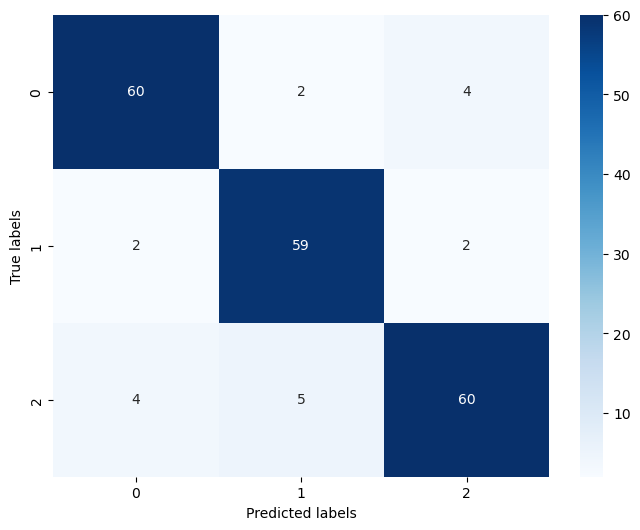

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
{'medial frontal': 3.9591521639411034, 'frontoparietal': 9.279251392306952, 'default mode': 6.771145627011035, 'subcortical-cerebellum': 8.620177521870204, 'motor': 6.51042934254067, 'visual I': 7.577081558159868, 'visual II': 7.248723039931636, 'visual association': 7.034039354238532}


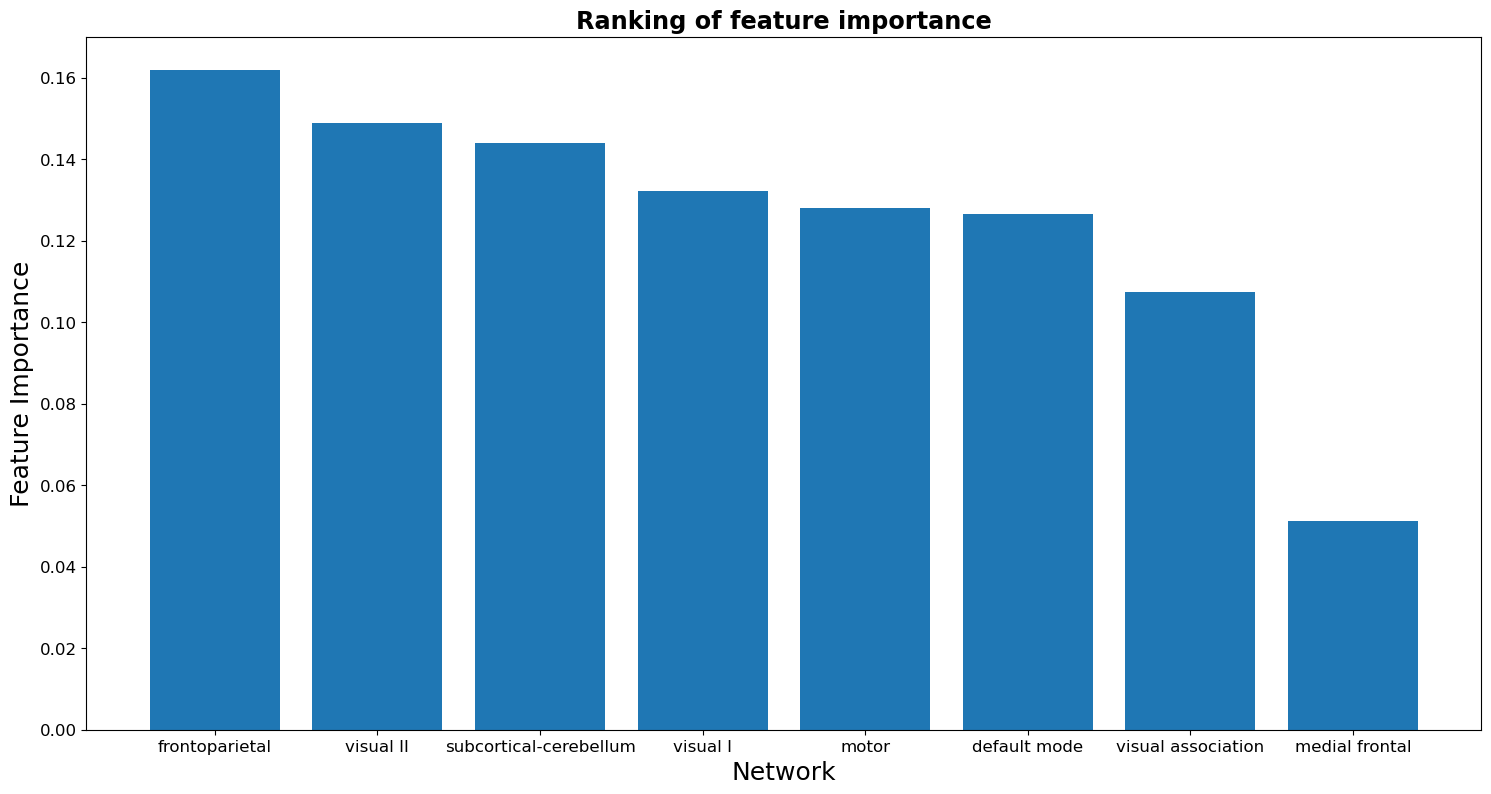

[0]	train-mlogloss:1.06827	test-mlogloss:1.09354
[1]	train-mlogloss:1.04075	test-mlogloss:1.11704
[2]	train-mlogloss:1.01234	test-mlogloss:1.10131
[3]	train-mlogloss:0.98636	test-mlogloss:1.09964
[4]	train-mlogloss:0.95989	test-mlogloss:1.11044
[5]	train-mlogloss:0.93681	test-mlogloss:1.11310
[6]	train-mlogloss:0.91446	test-mlogloss:1.11488
[7]	train-mlogloss:0.89079	test-mlogloss:1.09124
[8]	train-mlogloss:0.86790	test-mlogloss:1.07872
[9]	train-mlogloss:0.84681	test-mlogloss:1.08214
[10]	train-mlogloss:0.82696	test-mlogloss:1.07297
[11]	train-mlogloss:0.80604	test-mlogloss:1.05754
[12]	train-mlogloss:0.78938	test-mlogloss:1.07560
[13]	train-mlogloss:0.77102	test-mlogloss:1.05183
[14]	train-mlogloss:0.75406	test-mlogloss:1.05127
0.3333333333333333
[0]	train-mlogloss:1.07031	test-mlogloss:1.08975
[1]	train-mlogloss:1.04366	test-mlogloss:1.10742
[2]	train-mlogloss:1.01717	test-mlogloss:1.09795
[3]	train-mlogloss:0.99347	test-mlogloss:1.08640
[4]	train-mlogloss:0.96849	test-mlogloss:1.09

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


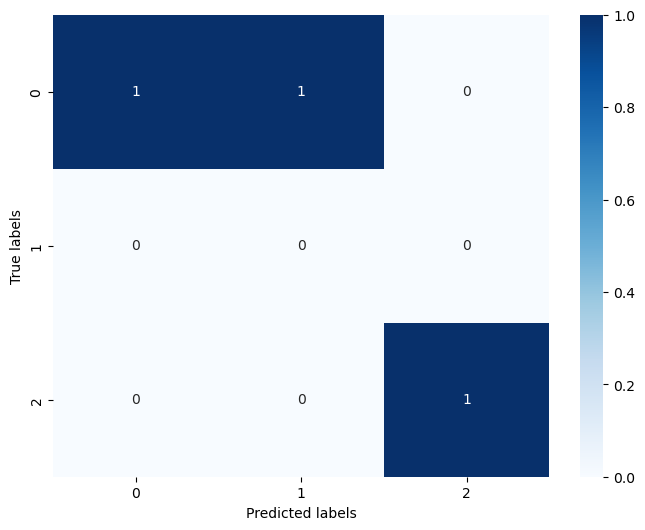

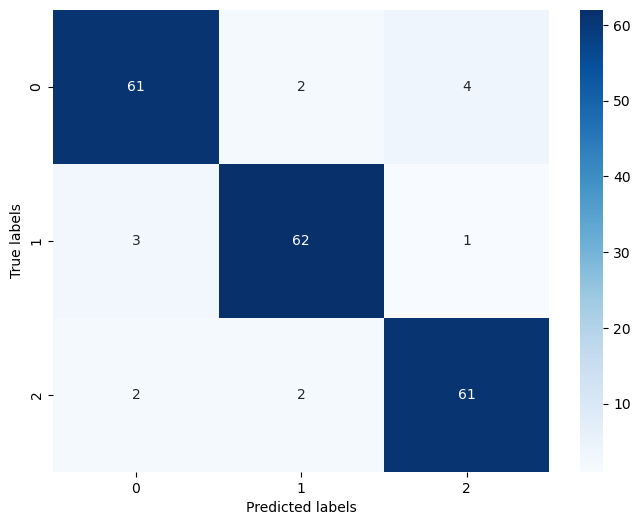

0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
{'medial frontal': 4.011897143687721, 'frontoparietal': 9.427712997064342, 'default mode': 6.878217935896668, 'subcortical-cerebellum': 8.783335325886407, 'motor': 6.648093739679341, 'visual I': 7.730041999425058, 'visual II': 7.367692272026783, 'visual association': 7.153008586333679}


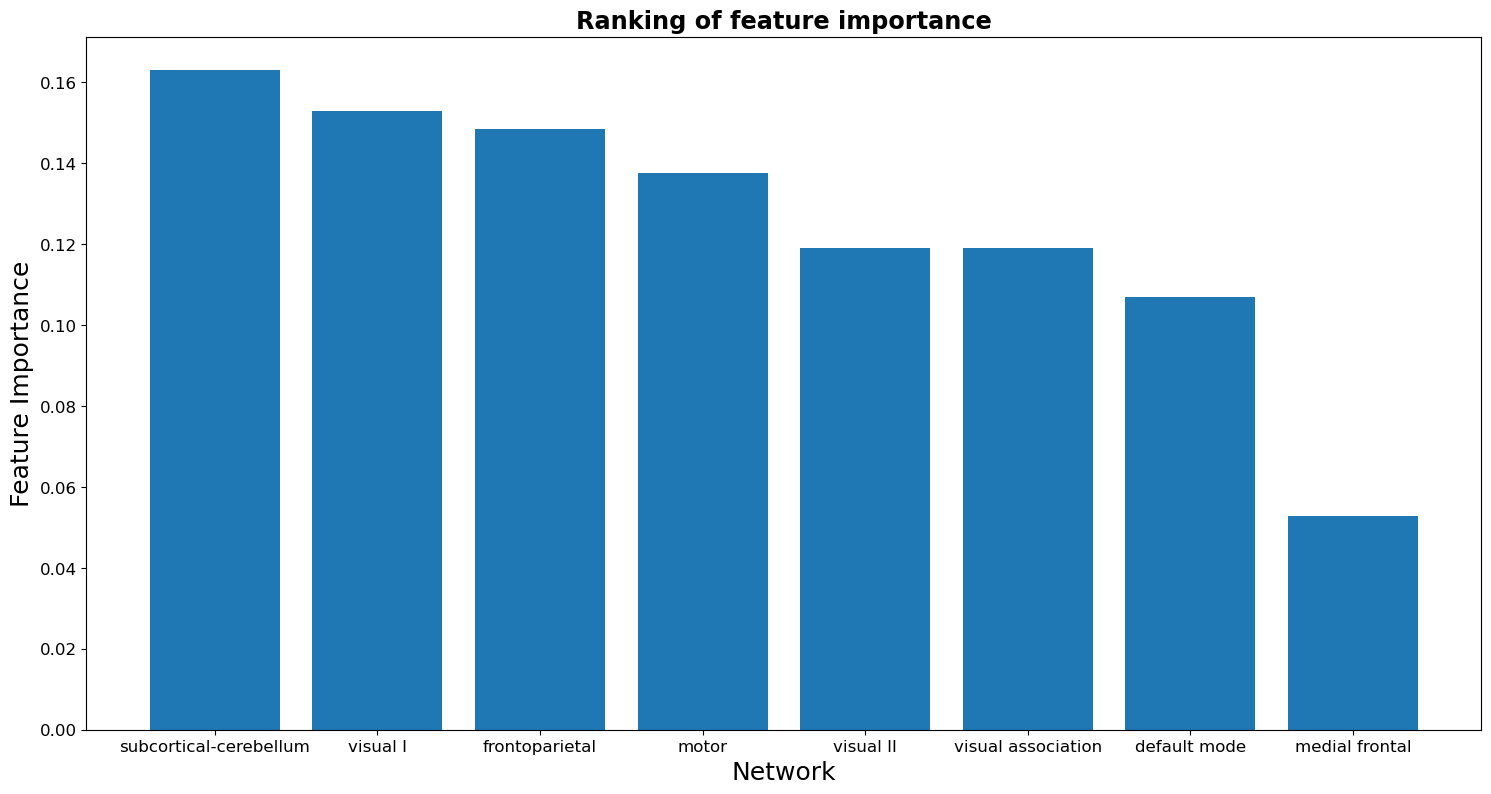

[0]	train-mlogloss:1.06746	test-mlogloss:1.07929
[1]	train-mlogloss:1.03929	test-mlogloss:1.07114
[2]	train-mlogloss:1.01136	test-mlogloss:1.05574
[3]	train-mlogloss:0.98707	test-mlogloss:1.02776
[4]	train-mlogloss:0.96160	test-mlogloss:1.02175
[5]	train-mlogloss:0.93830	test-mlogloss:1.03539
[6]	train-mlogloss:0.91677	test-mlogloss:1.02215
[7]	train-mlogloss:0.89324	test-mlogloss:0.99351
[8]	train-mlogloss:0.86932	test-mlogloss:0.99917
[9]	train-mlogloss:0.84816	test-mlogloss:1.00126
[10]	train-mlogloss:0.82860	test-mlogloss:0.99552
[11]	train-mlogloss:0.80835	test-mlogloss:0.97751
[12]	train-mlogloss:0.79384	test-mlogloss:0.98102
[13]	train-mlogloss:0.77703	test-mlogloss:0.98053
0.6666666666666666
[0]	train-mlogloss:1.06833	test-mlogloss:1.09289
[1]	train-mlogloss:1.04125	test-mlogloss:1.07361
[2]	train-mlogloss:1.01635	test-mlogloss:1.05169
[3]	train-mlogloss:0.99295	test-mlogloss:1.02776
[4]	train-mlogloss:0.96919	test-mlogloss:1.02852
[5]	train-mlogloss:0.94608	test-mlogloss:1.023

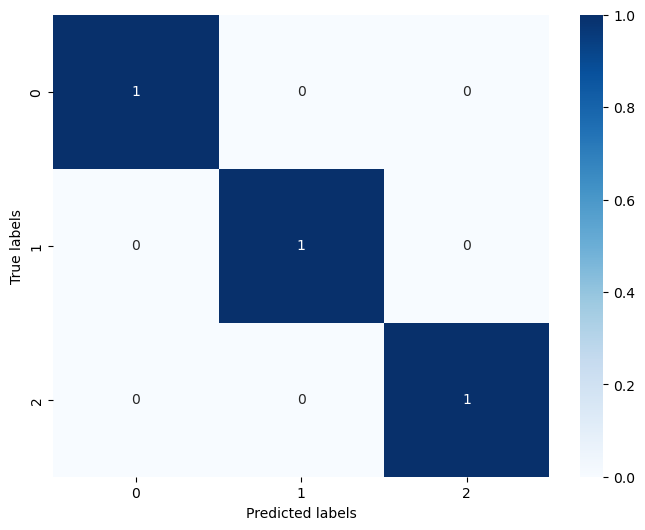

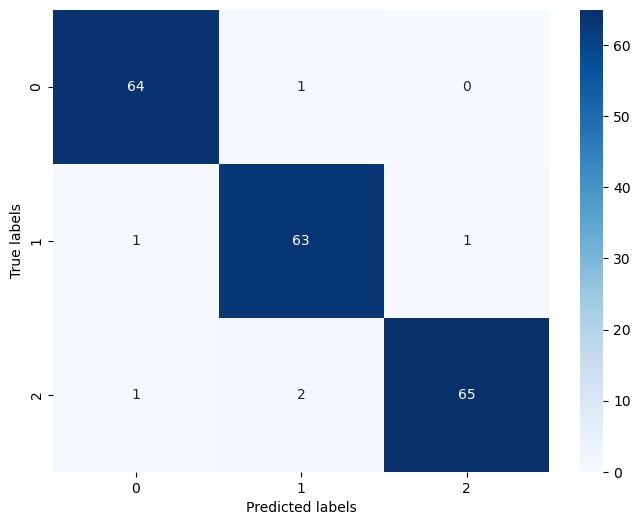

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
{'medial frontal': 4.116963899609838, 'frontoparietal': 9.563796191826214, 'default mode': 6.979782466621382, 'subcortical-cerebellum': 8.937562946616527, 'motor': 6.7812561244072995, 'visual I': 7.855430308961742, 'visual II': 7.493080581563467, 'visual association': 7.272127480393529}


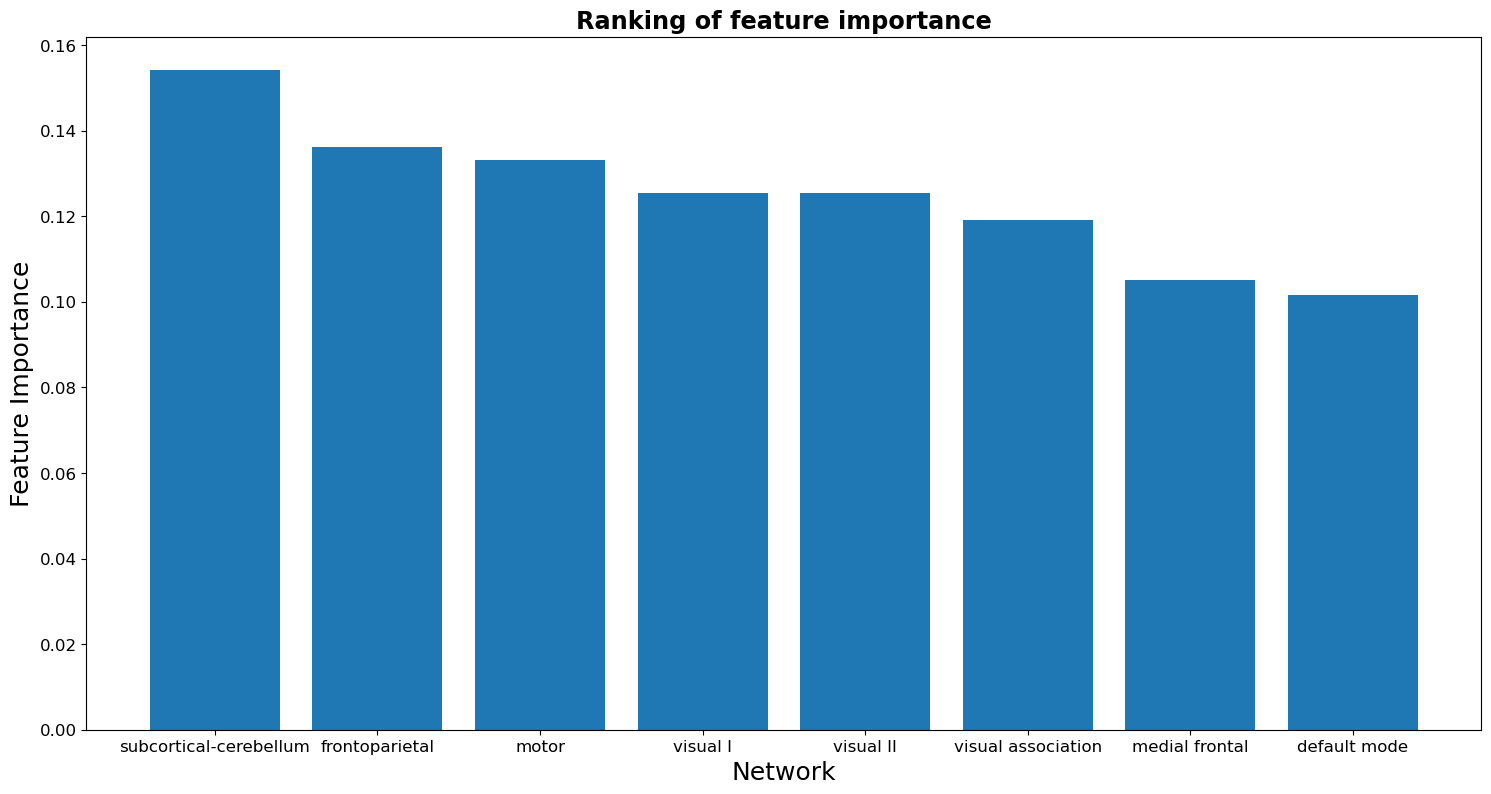

[0]	train-mlogloss:1.06632	test-mlogloss:1.10576
[1]	train-mlogloss:1.03716	test-mlogloss:1.10591
[2]	train-mlogloss:1.00975	test-mlogloss:1.10198
[3]	train-mlogloss:0.98405	test-mlogloss:1.10388
[4]	train-mlogloss:0.95711	test-mlogloss:1.08307
[5]	train-mlogloss:0.93411	test-mlogloss:1.09911
[6]	train-mlogloss:0.91171	test-mlogloss:1.11185
[7]	train-mlogloss:0.88834	test-mlogloss:1.10198
[8]	train-mlogloss:0.86696	test-mlogloss:1.11110
[9]	train-mlogloss:0.84647	test-mlogloss:1.10364
[10]	train-mlogloss:0.82673	test-mlogloss:1.11814
[11]	train-mlogloss:0.80644	test-mlogloss:1.12037
[12]	train-mlogloss:0.79148	test-mlogloss:1.09283
[13]	train-mlogloss:0.77394	test-mlogloss:1.11401
0.3333333333333333
[0]	train-mlogloss:1.06885	test-mlogloss:1.11351
[1]	train-mlogloss:1.04208	test-mlogloss:1.11809
[2]	train-mlogloss:1.01641	test-mlogloss:1.11365
[3]	train-mlogloss:0.99196	test-mlogloss:1.11076
[4]	train-mlogloss:0.96585	test-mlogloss:1.08186
[5]	train-mlogloss:0.94190	test-mlogloss:1.099

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


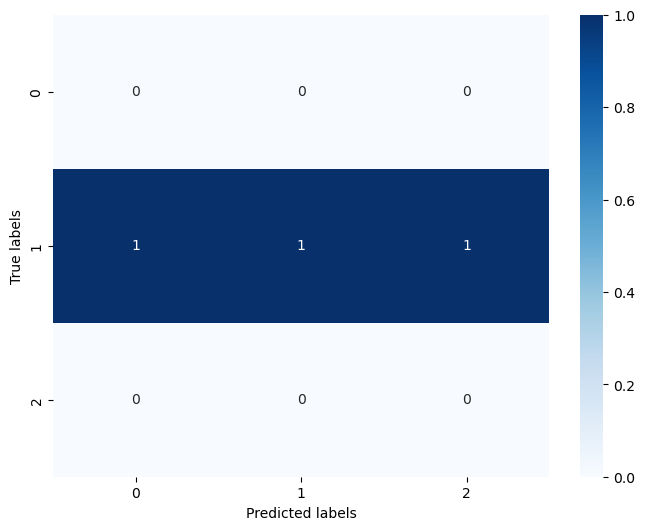

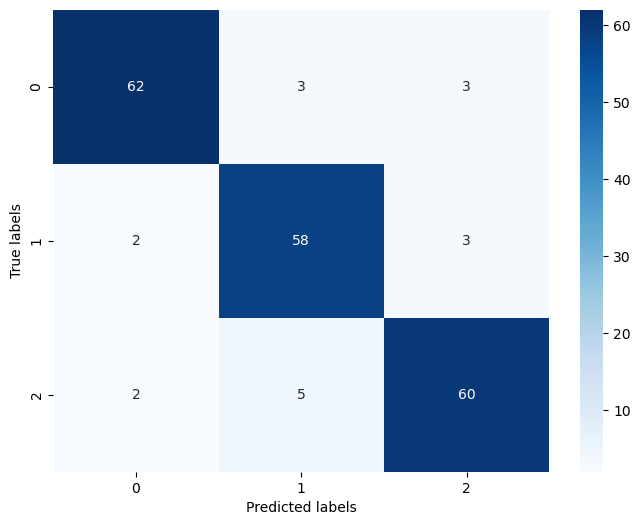

{'medial frontal': 4.227774887569464, 'frontoparietal': 9.700843310758634, 'default mode': 7.1324246025357665, 'subcortical-cerebellum': 9.083956574043189, 'motor': 6.913010389091294, 'visual I': 7.971474038019461, 'visual II': 7.582344988530943, 'visual association': 7.388171209451248}


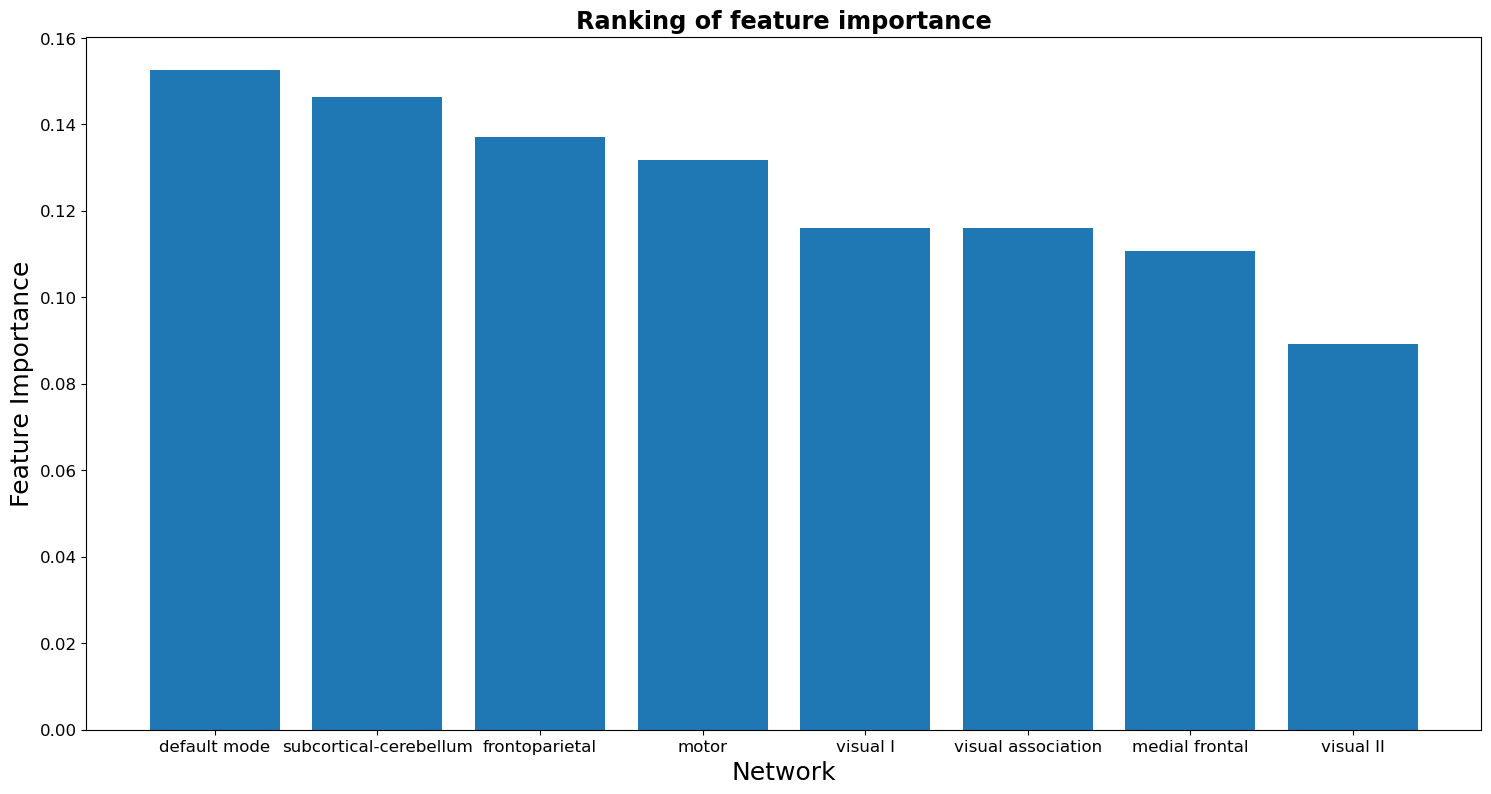

[0]	train-mlogloss:1.06611	test-mlogloss:1.10452
[1]	train-mlogloss:1.03605	test-mlogloss:1.10335
[2]	train-mlogloss:1.00866	test-mlogloss:1.09512
[3]	train-mlogloss:0.98321	test-mlogloss:1.10947
[4]	train-mlogloss:0.95799	test-mlogloss:1.13431
[5]	train-mlogloss:0.93533	test-mlogloss:1.12600
[6]	train-mlogloss:0.91408	test-mlogloss:1.13456
[7]	train-mlogloss:0.89041	test-mlogloss:1.12538
[8]	train-mlogloss:0.86811	test-mlogloss:1.08541
[9]	train-mlogloss:0.84768	test-mlogloss:1.10309
[10]	train-mlogloss:0.82824	test-mlogloss:1.10305
[11]	train-mlogloss:0.80820	test-mlogloss:1.11282
[12]	train-mlogloss:0.79222	test-mlogloss:1.12675
[13]	train-mlogloss:0.77586	test-mlogloss:1.10905
[14]	train-mlogloss:0.75868	test-mlogloss:1.13369
[15]	train-mlogloss:0.74308	test-mlogloss:1.16109
[16]	train-mlogloss:0.72771	test-mlogloss:1.16427
[17]	train-mlogloss:0.71100	test-mlogloss:1.17584
0.3333333333333333
[0]	train-mlogloss:1.06816	test-mlogloss:1.11144
[1]	train-mlogloss:1.03971	test-mlogloss:1

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


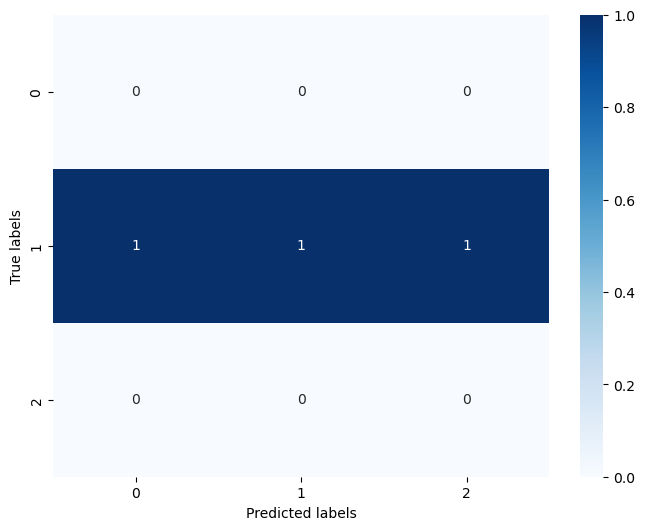

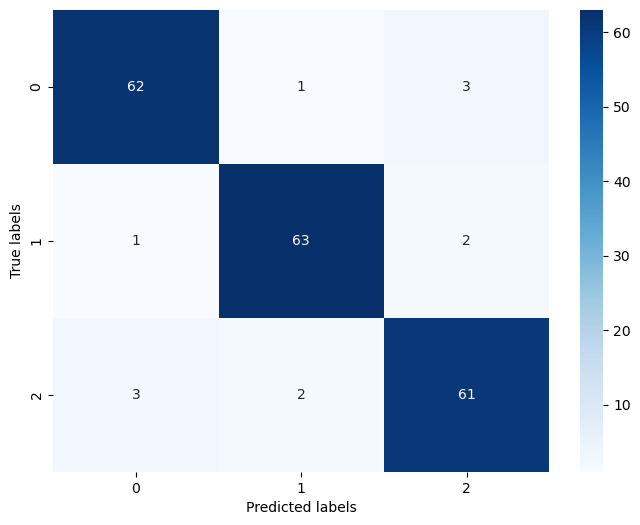

{'medial frontal': 4.328883725506206, 'frontoparietal': 9.851763120325975, 'default mode': 7.242380463791973, 'subcortical-cerebellum': 9.230564389051462, 'motor': 7.071835522016925, 'visual I': 8.141159009093853, 'visual II': 7.677368572332602, 'visual association': 7.4560451978810045}


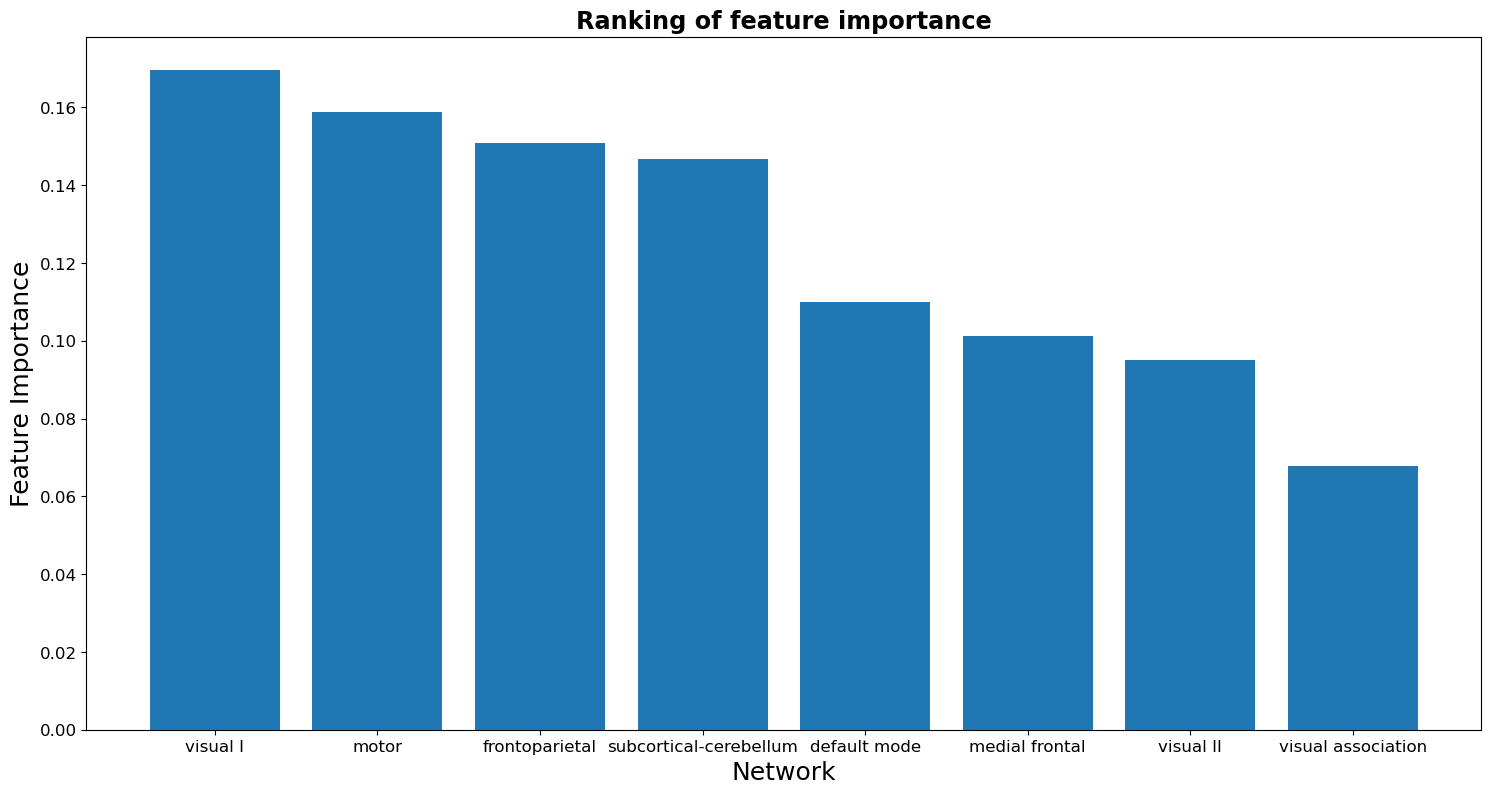

[0]	train-mlogloss:1.06717	test-mlogloss:1.07447
[1]	train-mlogloss:1.03859	test-mlogloss:1.05247
[2]	train-mlogloss:1.01081	test-mlogloss:1.02580
[3]	train-mlogloss:0.98619	test-mlogloss:1.00130
[4]	train-mlogloss:0.96084	test-mlogloss:0.98093
[5]	train-mlogloss:0.93664	test-mlogloss:0.98707
[6]	train-mlogloss:0.91626	test-mlogloss:0.97163
[7]	train-mlogloss:0.89316	test-mlogloss:0.95150
[8]	train-mlogloss:0.86998	test-mlogloss:0.93058
[9]	train-mlogloss:0.84926	test-mlogloss:0.92092
0.6666666666666666
[0]	train-mlogloss:1.06958	test-mlogloss:1.08829
[1]	train-mlogloss:1.04199	test-mlogloss:1.05859
[2]	train-mlogloss:1.01770	test-mlogloss:1.02904
[3]	train-mlogloss:0.99337	test-mlogloss:0.98962
[4]	train-mlogloss:0.96957	test-mlogloss:0.95472
[5]	train-mlogloss:0.94570	test-mlogloss:0.96107
[6]	train-mlogloss:0.92501	test-mlogloss:0.94482
[7]	train-mlogloss:0.90124	test-mlogloss:0.91774
[8]	train-mlogloss:0.87978	test-mlogloss:0.90683
[9]	train-mlogloss:0.85996	test-mlogloss:0.88658
0

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


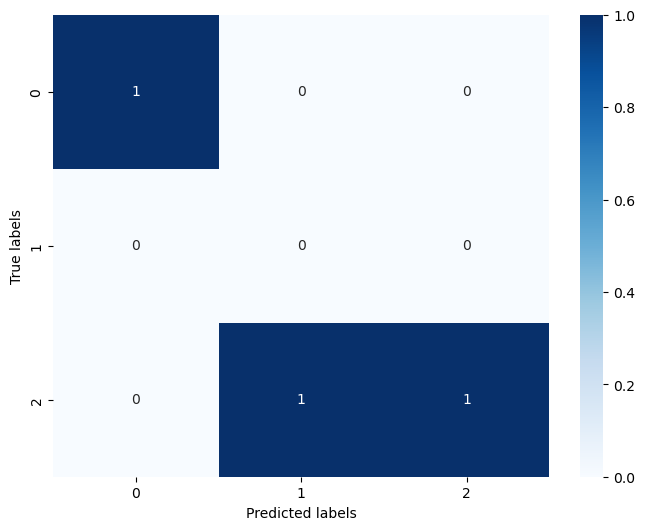

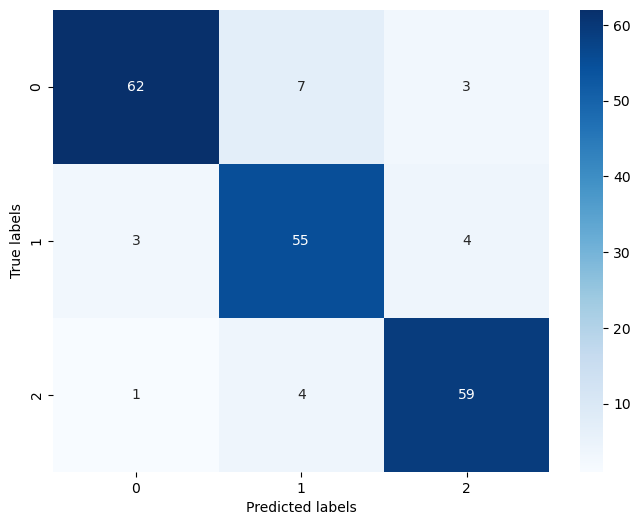

0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
{'medial frontal': 4.42286474297869, 'frontoparietal': 10.025443726145221, 'default mode': 7.333228780682041, 'subcortical-cerebellum': 9.374407557460737, 'motor': 7.203565581507523, 'visual I': 8.305190692367587, 'visual II': 7.753075503074325, 'visual association': 7.582223415783877}


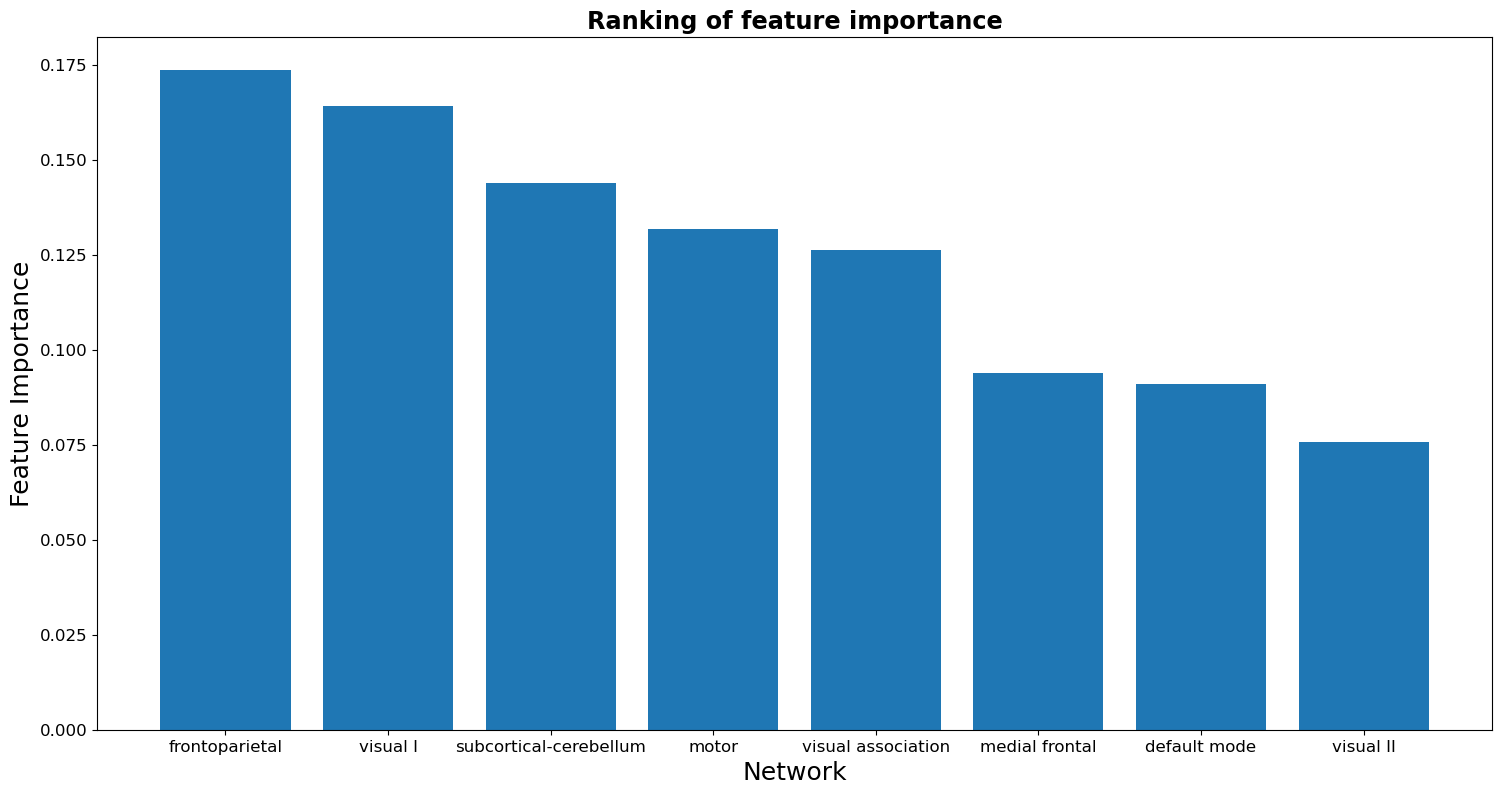

[0]	train-mlogloss:1.06712	test-mlogloss:1.11188
[1]	train-mlogloss:1.03675	test-mlogloss:1.10088
[2]	train-mlogloss:1.01075	test-mlogloss:1.11803
[3]	train-mlogloss:0.98623	test-mlogloss:1.09880
[4]	train-mlogloss:0.95876	test-mlogloss:1.09625
[5]	train-mlogloss:0.93673	test-mlogloss:1.12994
[6]	train-mlogloss:0.91392	test-mlogloss:1.13272
[7]	train-mlogloss:0.89140	test-mlogloss:1.12412
[8]	train-mlogloss:0.86821	test-mlogloss:1.13501
[9]	train-mlogloss:0.84752	test-mlogloss:1.13011
[10]	train-mlogloss:0.82743	test-mlogloss:1.14744
[11]	train-mlogloss:0.80702	test-mlogloss:1.15986
[12]	train-mlogloss:0.79025	test-mlogloss:1.16902
[13]	train-mlogloss:0.77269	test-mlogloss:1.17600
0.3333333333333333
[0]	train-mlogloss:1.06909	test-mlogloss:1.10630
[1]	train-mlogloss:1.03922	test-mlogloss:1.09624
[2]	train-mlogloss:1.01326	test-mlogloss:1.11399
[3]	train-mlogloss:0.98922	test-mlogloss:1.08949
[4]	train-mlogloss:0.96304	test-mlogloss:1.09299
[5]	train-mlogloss:0.94155	test-mlogloss:1.126

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


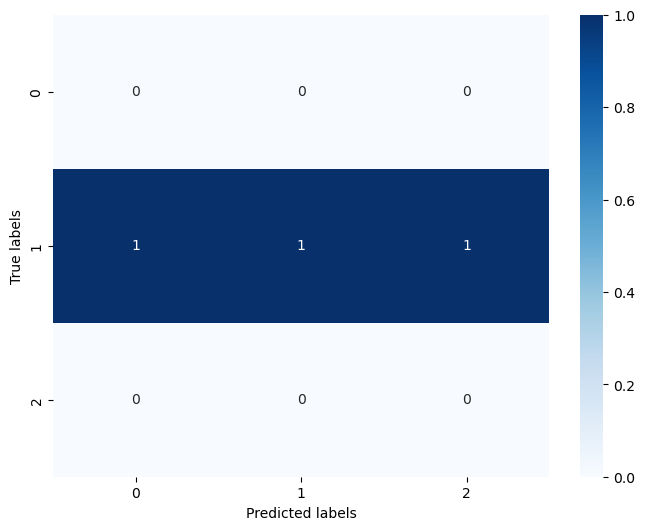

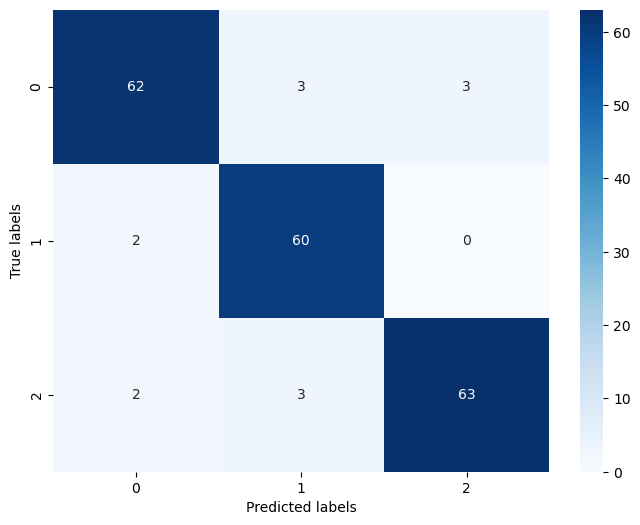

{'medial frontal': 4.502752586711802, 'frontoparietal': 10.16172298898406, 'default mode': 7.490436644599701, 'subcortical-cerebellum': 9.517825257876847, 'motor': 7.355808986564625, 'visual I': 8.507446423723641, 'visual II': 7.771462387743058, 'visual association': 7.692544723796269}


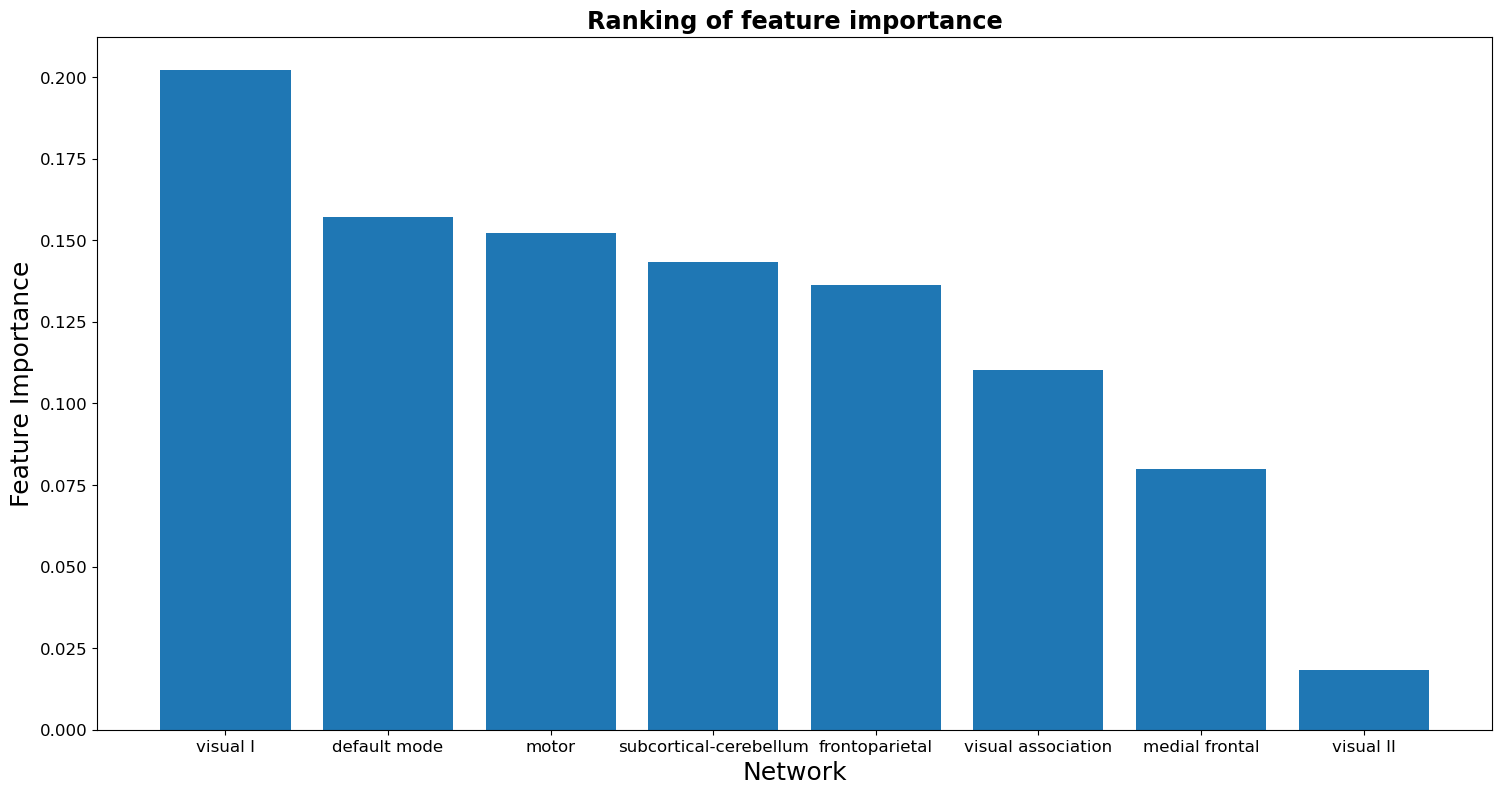

[0]	train-mlogloss:1.06845	test-mlogloss:1.09068
[1]	train-mlogloss:1.03877	test-mlogloss:1.09184
[2]	train-mlogloss:1.01122	test-mlogloss:1.10822
[3]	train-mlogloss:0.98431	test-mlogloss:1.10878
[4]	train-mlogloss:0.95769	test-mlogloss:1.08106
[5]	train-mlogloss:0.93407	test-mlogloss:1.09355
[6]	train-mlogloss:0.91142	test-mlogloss:1.09645
[7]	train-mlogloss:0.88832	test-mlogloss:1.08970
[8]	train-mlogloss:0.86885	test-mlogloss:1.09006
[9]	train-mlogloss:0.84846	test-mlogloss:1.09015
[10]	train-mlogloss:0.82840	test-mlogloss:1.11449
[11]	train-mlogloss:0.81040	test-mlogloss:1.10196
[12]	train-mlogloss:0.79292	test-mlogloss:1.10566
[13]	train-mlogloss:0.77708	test-mlogloss:1.13768
0.0
[0]	train-mlogloss:1.06942	test-mlogloss:1.08536
[1]	train-mlogloss:1.04107	test-mlogloss:1.08030
[2]	train-mlogloss:1.01443	test-mlogloss:1.08917
[3]	train-mlogloss:0.98955	test-mlogloss:1.09359
[4]	train-mlogloss:0.96528	test-mlogloss:1.05097
[5]	train-mlogloss:0.94127	test-mlogloss:1.06269
[6]	train-ml

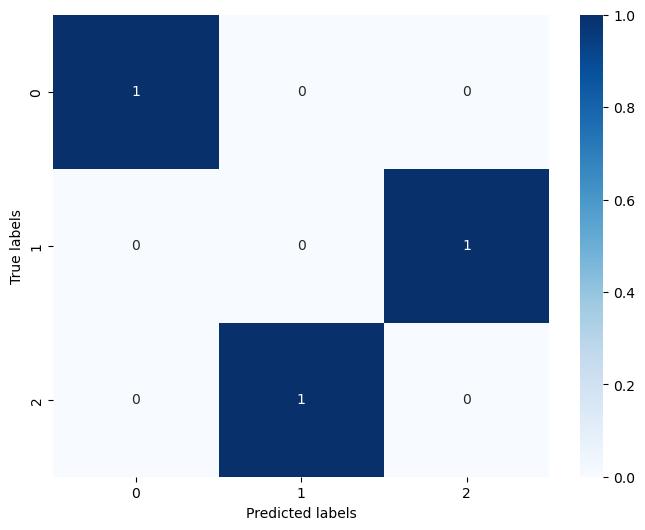

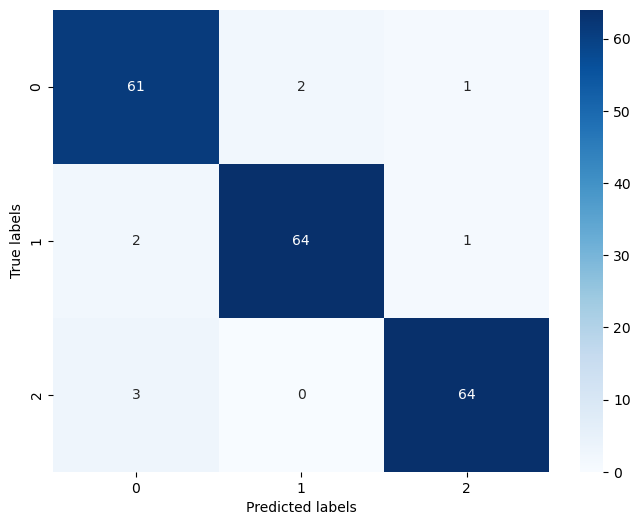

{'medial frontal': 4.549643284856624, 'frontoparietal': 10.292615739955169, 'default mode': 7.601695482925143, 'subcortical-cerebellum': 9.674411771075617, 'motor': 7.484374755296248, 'visual I': 8.713481309511497, 'visual II': 7.867612001110723, 'visual association': 7.816165655268982}


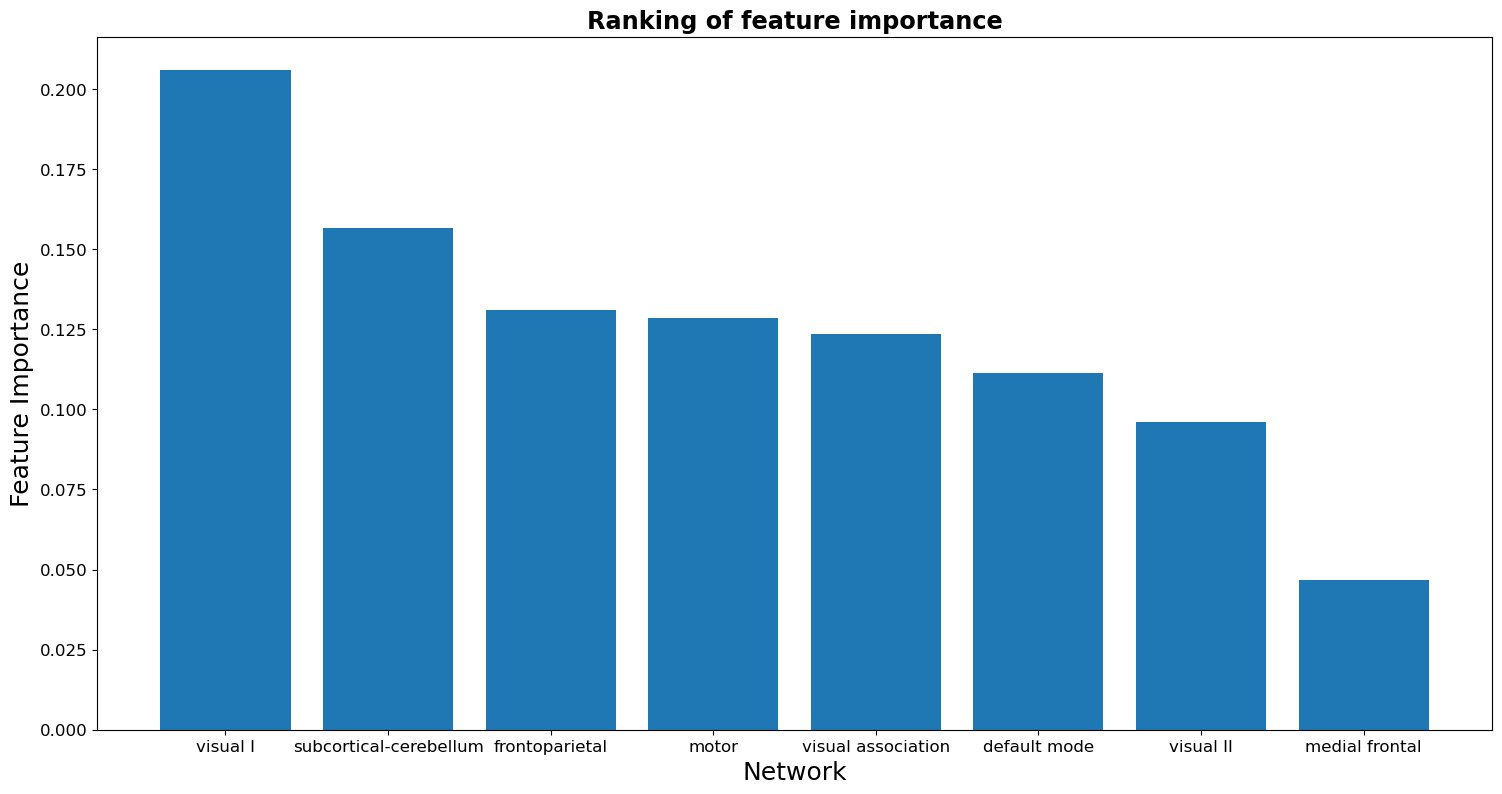

[0]	train-mlogloss:1.06745	test-mlogloss:1.07642
[1]	train-mlogloss:1.03621	test-mlogloss:1.05259
[2]	train-mlogloss:1.01244	test-mlogloss:1.02137
[3]	train-mlogloss:0.98739	test-mlogloss:1.01308
[4]	train-mlogloss:0.96070	test-mlogloss:1.01931
[5]	train-mlogloss:0.94026	test-mlogloss:0.98629
[6]	train-mlogloss:0.91805	test-mlogloss:0.96551
[7]	train-mlogloss:0.89366	test-mlogloss:0.96347
[8]	train-mlogloss:0.87098	test-mlogloss:0.96553
[9]	train-mlogloss:0.85196	test-mlogloss:0.95075
[10]	train-mlogloss:0.83201	test-mlogloss:0.92877
[11]	train-mlogloss:0.81197	test-mlogloss:0.91313
[12]	train-mlogloss:0.79353	test-mlogloss:0.91539
[13]	train-mlogloss:0.77807	test-mlogloss:0.92179
[14]	train-mlogloss:0.76093	test-mlogloss:0.90909
[15]	train-mlogloss:0.74645	test-mlogloss:0.92100
0.6666666666666666
[0]	train-mlogloss:1.06900	test-mlogloss:1.05198
[1]	train-mlogloss:1.04035	test-mlogloss:1.03196
[2]	train-mlogloss:1.01551	test-mlogloss:1.00933
[3]	train-mlogloss:0.99196	test-mlogloss:1.0

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


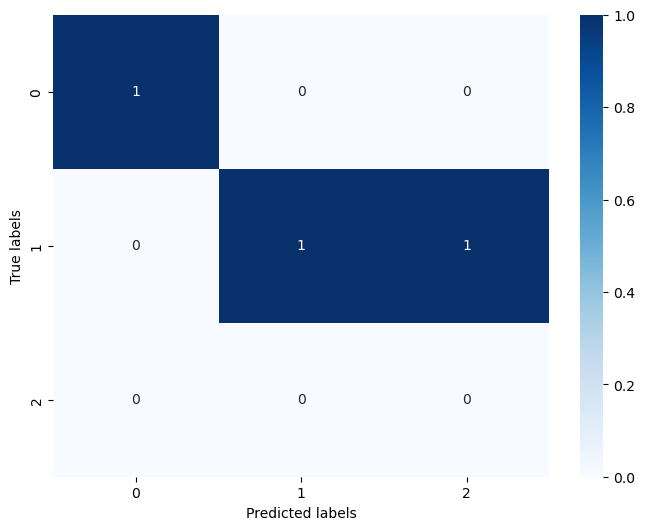

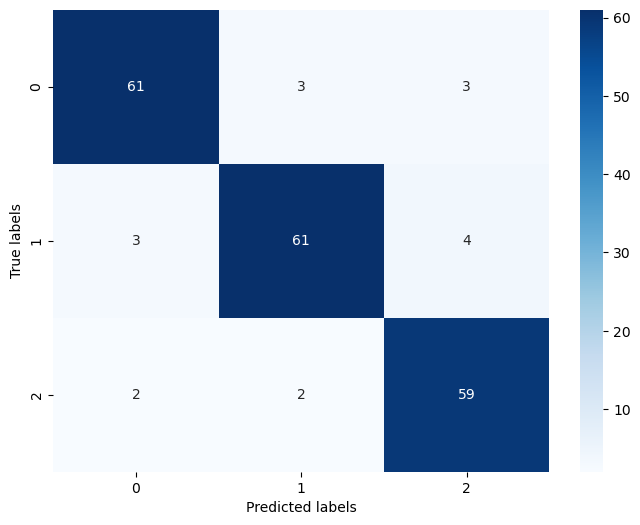

0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
{'medial frontal': 4.638043699574619, 'frontoparietal': 10.422471904712484, 'default mode': 7.715633795228336, 'subcortical-cerebellum': 9.827911997372976, 'motor': 7.626797645675239, 'visual I': 8.919203262281153, 'visual II': 7.946735829099052, 'visual association': 7.903201866056143}


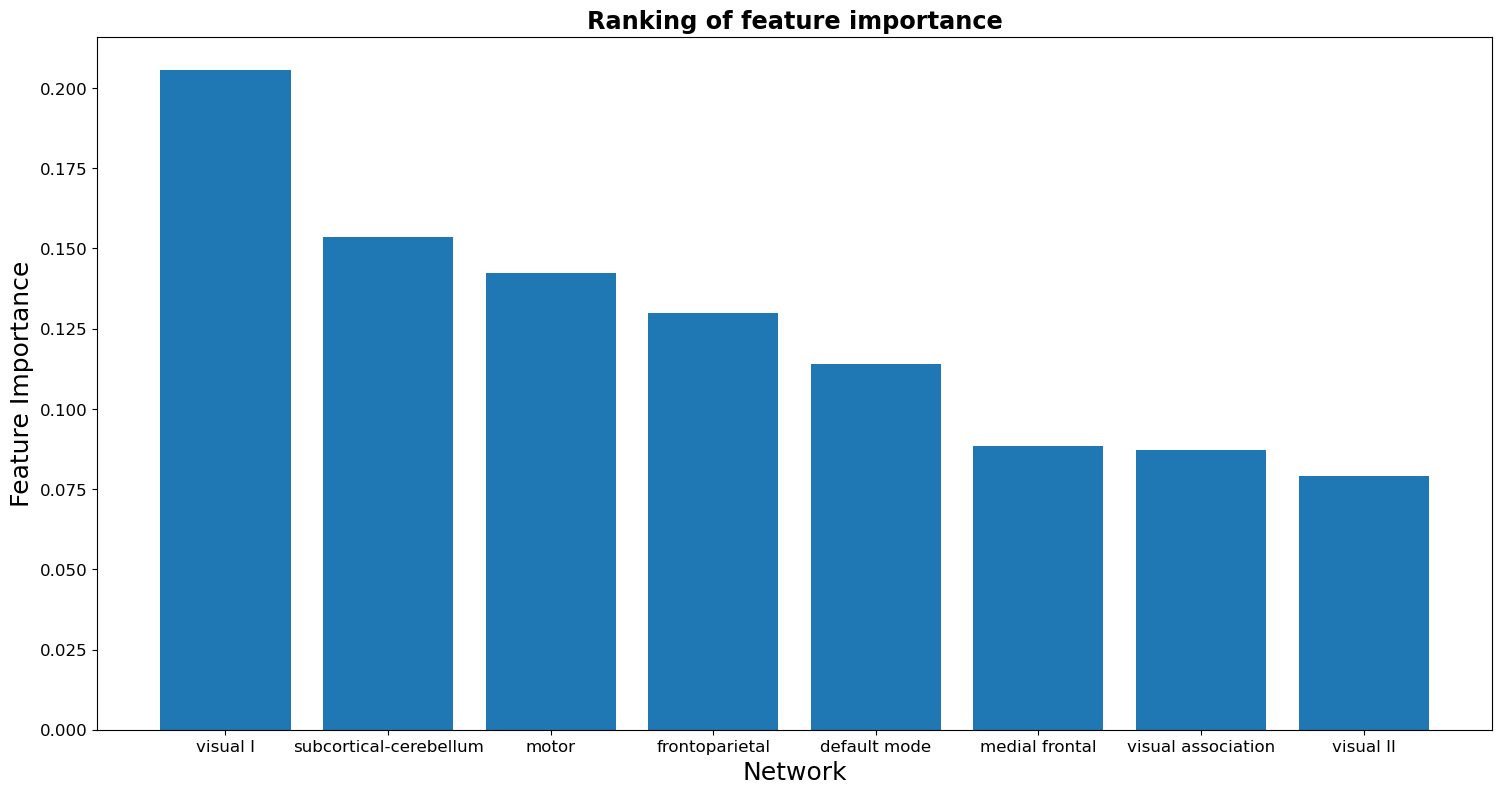

[0]	train-mlogloss:1.06738	test-mlogloss:1.07439
[1]	train-mlogloss:1.03838	test-mlogloss:1.06720
[2]	train-mlogloss:1.01130	test-mlogloss:1.07489
[3]	train-mlogloss:0.98667	test-mlogloss:1.05864
[4]	train-mlogloss:0.96215	test-mlogloss:1.00139
[5]	train-mlogloss:0.93742	test-mlogloss:1.02563
[6]	train-mlogloss:0.91420	test-mlogloss:1.02324
[7]	train-mlogloss:0.89106	test-mlogloss:1.00395
[8]	train-mlogloss:0.86890	test-mlogloss:0.97400
[9]	train-mlogloss:0.84994	test-mlogloss:0.94360
[10]	train-mlogloss:0.82936	test-mlogloss:0.94387
[11]	train-mlogloss:0.80876	test-mlogloss:0.93700
[12]	train-mlogloss:0.79203	test-mlogloss:0.93477
[13]	train-mlogloss:0.77439	test-mlogloss:0.94800
[14]	train-mlogloss:0.75769	test-mlogloss:0.93981
[15]	train-mlogloss:0.74288	test-mlogloss:0.95145
[16]	train-mlogloss:0.72549	test-mlogloss:0.93455
[17]	train-mlogloss:0.71046	test-mlogloss:0.92637
[18]	train-mlogloss:0.69621	test-mlogloss:0.92648
[19]	train-mlogloss:0.68280	test-mlogloss:0.92275
[20]	train

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


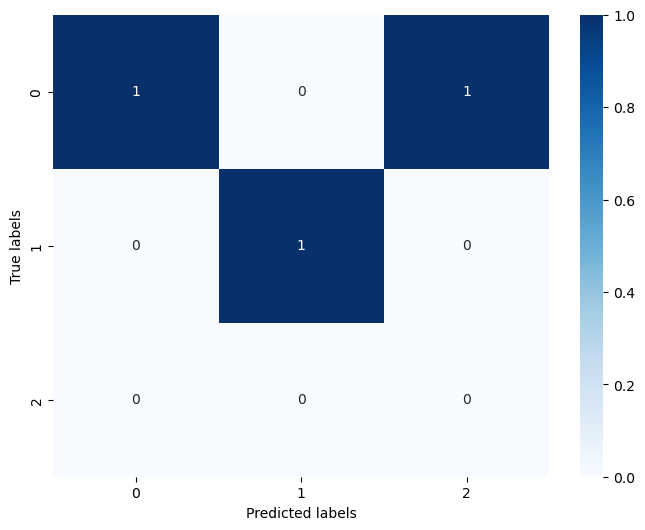

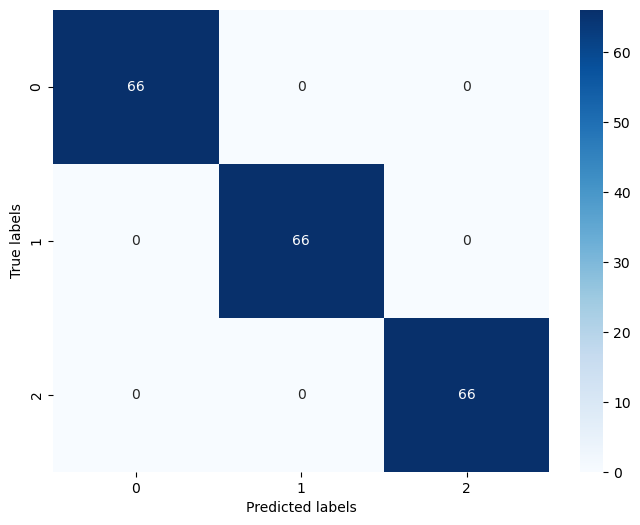

0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
{'medial frontal': 4.735367992462743, 'frontoparietal': 10.576288066569406, 'default mode': 7.827699856009808, 'subcortical-cerebellum': 9.971799285289928, 'motor': 7.764597394488012, 'visual I': 9.05294465169114, 'visual II': 8.048194814168697, 'visual association': 8.023107939320269}


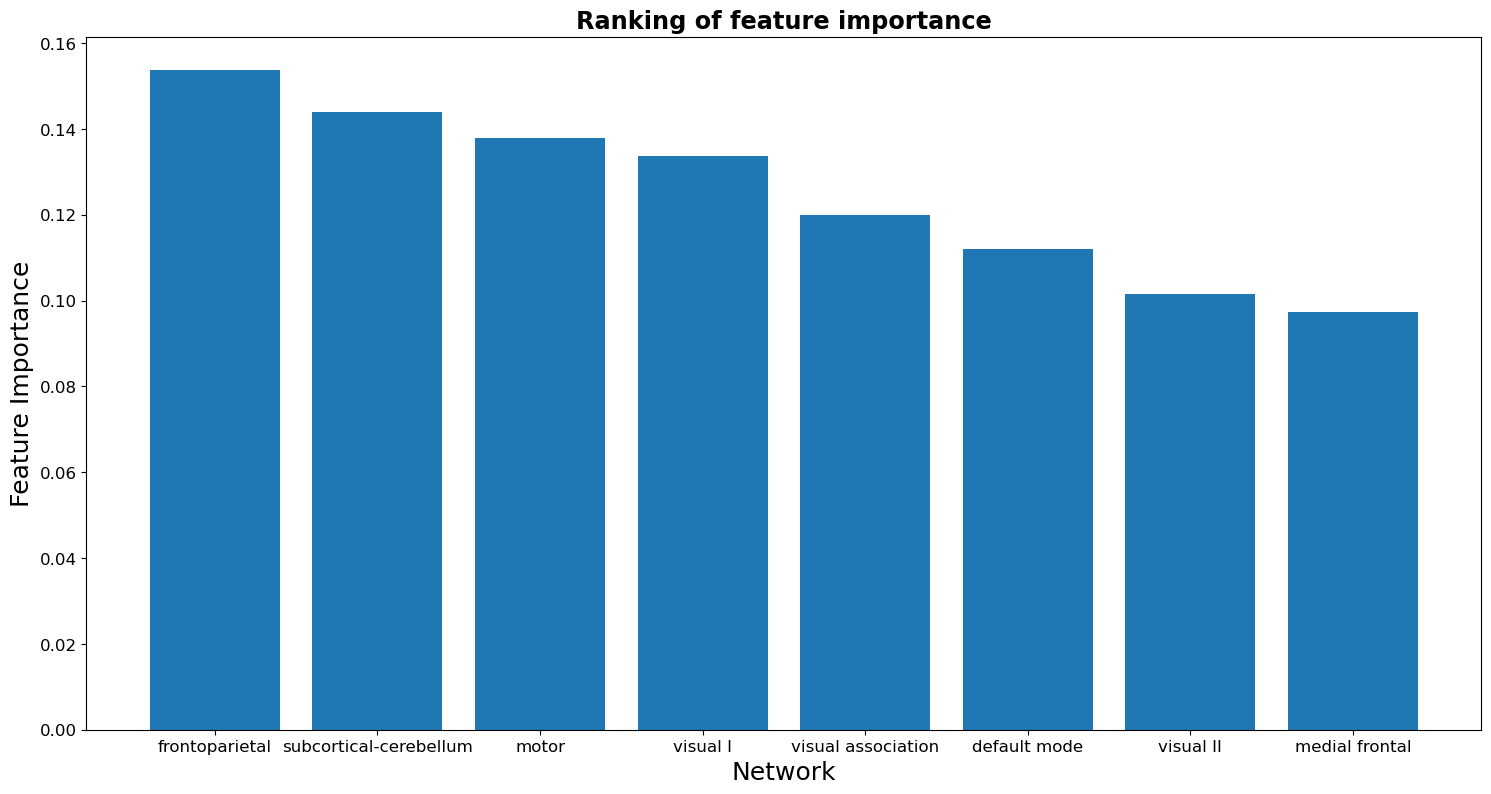

[0]	train-mlogloss:1.06748	test-mlogloss:1.10967
[1]	train-mlogloss:1.03564	test-mlogloss:1.09166
[2]	train-mlogloss:1.00936	test-mlogloss:1.07925
[3]	train-mlogloss:0.98171	test-mlogloss:1.10911
[4]	train-mlogloss:0.95592	test-mlogloss:1.12593
[5]	train-mlogloss:0.93182	test-mlogloss:1.11613
[6]	train-mlogloss:0.91106	test-mlogloss:1.09940
[7]	train-mlogloss:0.88777	test-mlogloss:1.10194
[8]	train-mlogloss:0.86808	test-mlogloss:1.08047
[9]	train-mlogloss:0.84941	test-mlogloss:1.06317
[10]	train-mlogloss:0.82938	test-mlogloss:1.03963
[11]	train-mlogloss:0.81017	test-mlogloss:1.01134
[12]	train-mlogloss:0.79327	test-mlogloss:1.01475
[13]	train-mlogloss:0.77573	test-mlogloss:1.02974
[14]	train-mlogloss:0.75826	test-mlogloss:1.04067
[15]	train-mlogloss:0.74351	test-mlogloss:1.03347
[16]	train-mlogloss:0.72594	test-mlogloss:1.02241
[17]	train-mlogloss:0.70972	test-mlogloss:1.02960
[18]	train-mlogloss:0.69604	test-mlogloss:1.04750
[19]	train-mlogloss:0.68090	test-mlogloss:1.06344
[20]	train

D:\Temple\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


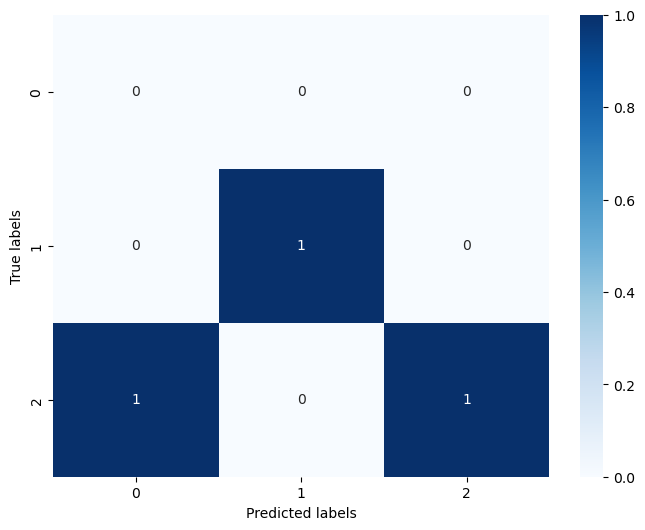

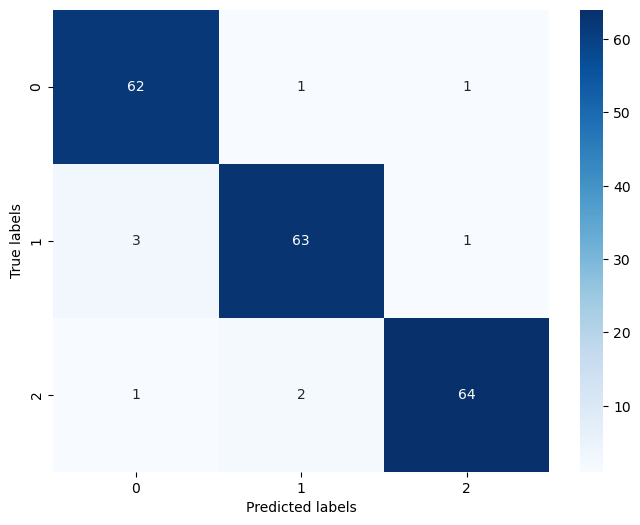

0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
{'medial frontal': 4.8265650257393435, 'frontoparietal': 10.734851234155531, 'default mode': 7.929419623895247, 'subcortical-cerebellum': 10.109686081756857, 'motor': 7.91921144167388, 'visual I': 9.211175401735156, 'visual II': 8.172518974917567, 'visual association': 8.09657221612642}


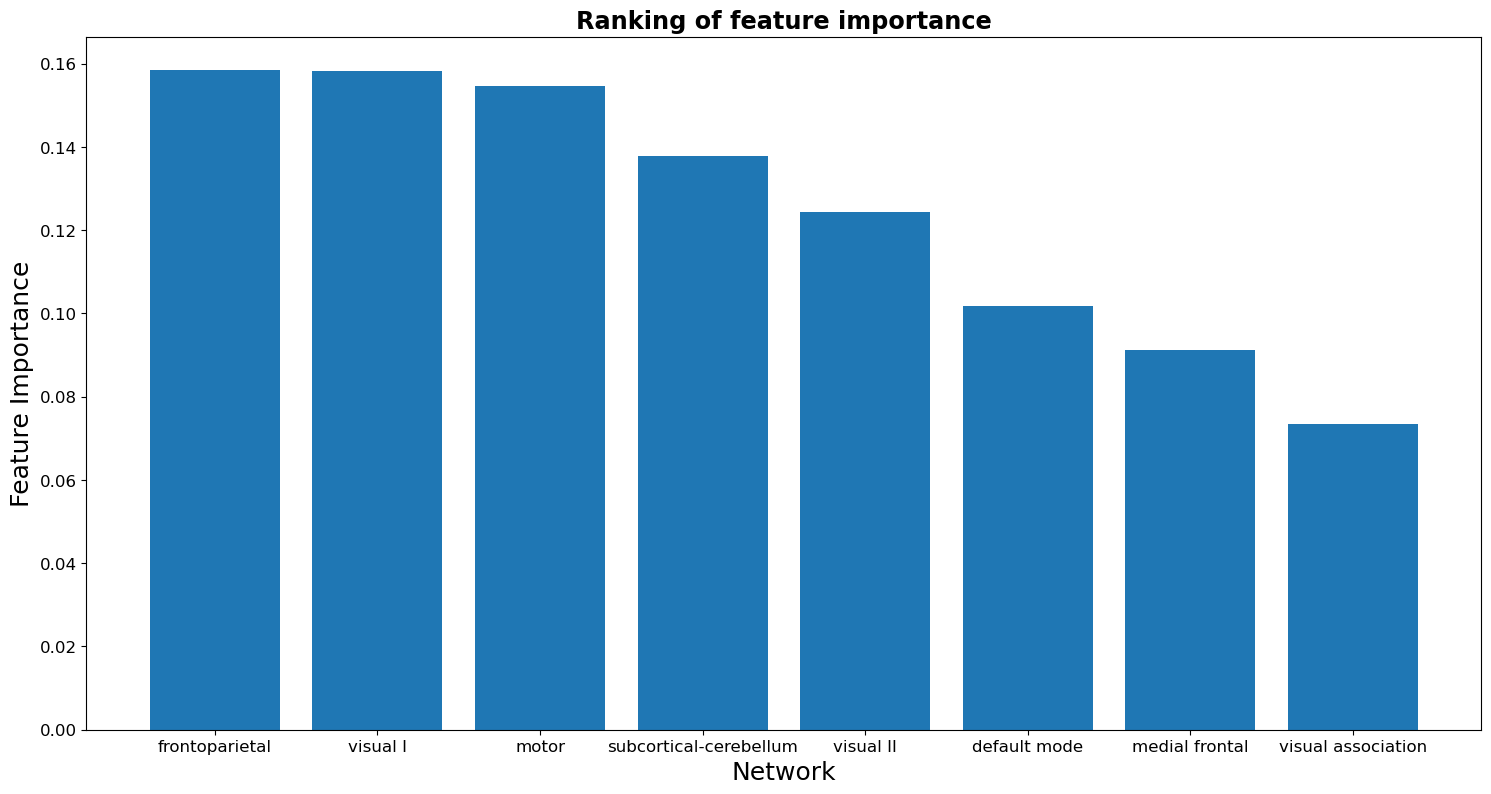

In [6]:
import seaborn as sns
from sklearn.model_selection import KFold
X = np.arange(0,201,3)
total_importance = []
total_sorted_importance = []
# booster:
param = {'booster':'gbtree',
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',#,'auc'
        'num_class':3,
        'max_depth':3,
        'lambda':10,
        'subsample':0.8,
        'colsample_bytree':0.9,
        'min_child_weight':4,
        'eta': 0.01,
        'seed':1,
        'nthread':8,
        'gamma':0.6,
        'reg_alpha': 1e-05,
        'learning_rate' : 0.1}

df = pd.read_csv("shen_268_parcellation_networklabels.csv",encoding="utf-8")
importance = {'medial frontal':0,'frontoparietal':0,'default mode':0,'subcortical-cerebellum':0,'motor':0,'visual I':0,'visual II':0,'visual association':0}
net_name = ['medial frontal','frontoparietal','default mode','subcortical-cerebellum','motor','visual I','visual II','visual association']
sum_acc = 0
sum_pre = 0
sum_rec = 0
sum_f1 = 0
#kf = KFold(n_splits = 10,shuffle=False)  # 初始化KFold
#for train_index , test_index in kf.split(X):  # 调用split方法切分数据
loo = LeaveOneOut()
for train_index , test_index in loo.split(X):  # 调用split方法切分数据
    train_x = train_X[X[train_index]]
    train_y = train_Y[X[train_index]]
    #print('train_index:%s , test_index: %s ' %(X[train_index],X[test_index]))
    #print(train_x,train_y)
    train_x = np.append(train_x,train_X[X[train_index]+1],axis=0)
    train_y = np.append(train_y,train_Y[X[train_index]+1],axis=0)
    #print(train_x,train_y,)
    train_x = np.append(train_x,train_X[X[train_index]+2],axis=0)
    train_y = np.append(train_y,train_Y[X[train_index]+2],axis=0)
    #print(train_x,train_y)
    test_x = train_X[X[test_index]]
    test_y = train_Y[X[test_index]]
    test_x = np.append(test_x,train_X[X[test_index]+1],axis=0)
    test_x = np.append(test_x,train_X[X[test_index]+2],axis=0)
    test_y = np.append(test_y,train_Y[X[test_index]+1],axis=0)
    test_y = np.append(test_y,train_Y[X[test_index]+2],axis=0)
    

    dtrain = xgb.DMatrix(train_x,label=train_y)
    ddtrain = xgb.DMatrix(train_x)
    dtest = xgb.DMatrix(test_x,label=test_y)
    ddtest = xgb.DMatrix(test_x)
    watchlist = [(dtrain,'train'),(dtest,'test')]
    cv_res= xgb.cv(param,dtrain,num_boost_round=200,early_stopping_rounds=30,nfold=5, metrics='mlogloss',show_stdv=False)
    # 最佳迭代次数cv_res.shape[0]
    #print(cv_res)
    best_depth = 3
    best_score = 0
    for max_depth in range(3,10):
        for min_child_weight in range(3,10):
            param = {'booster':'gbtree',
                'objective': 'multi:softmax',
                'eval_metric': 'mlogloss',#,'auc'
                'num_class':3,
                'max_depth':max_depth,
                'lambda':10,
                'subsample':0.8,
                'colsample_bytree':0.9,
                'min_child_weight':min_child_weight,
                'eta': 0.01,
                'seed':0,
                'nthread':8,
                'gamma':0.6,
                'reg_alpha': 1e-05,
                'learning_rate' : 0.1}
            bst=xgb.train(param,dtrain,early_stopping_rounds=10, num_boost_round=cv_res.shape[0],evals=watchlist)
            pred_test_y = bst.predict(ddtest)
            score = accuracy_score(test_y, pred_test_y)
            print(score)
            if score > best_score:
                best_score = score
                best_depth = max_depth
                best_weight = min_child_weight
                #print(best_depth)
    # booster:
    param = {'booster':'gbtree',
            'objective': 'multi:softmax',
            'eval_metric': 'mlogloss',#,'auc'
            'num_class':3,
            'max_depth':best_depth,
            'lambda':10,
            'subsample':0.8,
            'colsample_bytree':0.9,
            'min_child_weight':best_weight,
            'eta': 0.01,
            'seed':0,
            'nthread':8,
            'gamma':0.6,
            'reg_alpha': 1e-05,
            'learning_rate' : 0.1}
    bst=xgb.train(param,dtrain,early_stopping_rounds=10, num_boost_round=cv_res.shape[0],evals=watchlist)
    '''xgb.plot_tree(bst, num_trees=0, )
    fig = plt.gcf()
    fig.set_size_inches(120, 120)
    fig.savefig('tree1.png')'''

    pred_test_y = bst.predict(ddtest)
    pred_train_y = bst.predict(ddtrain)
    print ('Train Accuracy: %.4f' % metrics.accuracy_score(train_y,pred_train_y))
    print ('Test Accuracy: %.4f' % metrics.accuracy_score(test_y,pred_test_y))
    #print('train_index:%s , test_index: %s ' %(X[train_index],X[test_index]))
    #print(train_x,train_y)
    sum_acc += metrics.accuracy_score(test_y,pred_test_y)
    sum_pre += metrics.precision_score(test_y,pred_test_y,average='macro')
    sum_rec += metrics.recall_score(test_y,pred_test_y,average='macro')
    sum_f1 += metrics.f1_score(test_y,pred_test_y,average='macro')
    ## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
    confusion_matrix_result = metrics.confusion_matrix(pred_test_y,test_y)
    # 利用热力图对于结果进行可视化
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

    confusion_matrix_result = metrics.confusion_matrix(pred_train_y,train_y)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()
    
    Node_importance = bst.get_score(fmap='',importance_type='weight')
    # Compute net_importance
    df = pd.read_csv("shen_268_parcellation_networklabels.csv",encoding="utf-8")
    net_importance = {'medial frontal':0,'frontoparietal':0,'default mode':0,'subcortical-cerebellum':0,'motor':0,'visual I':0,'visual II':0,'visual association':0}
    for i in range(268):
        if 'f'+str(i) in Node_importance.keys():
            net_importance[net_name[df['Network'][i]-1]] += Node_importance['f'+str(i)]
            
    tmp = [29,34,20,90,50,18,9,18]
    sum_importance = 0
    for x in range(8):
        net_importance[net_name[x]] = net_importance[net_name[x]]/tmp[x]
        sum_importance += net_importance[net_name[x]]
    
    for x in range(8):
        net_importance[net_name[x]] = net_importance[net_name[x]]/sum_importance
        if metrics.accuracy_score(test_y,pred_test_y) > 0.4:
            print(metrics.accuracy_score(test_y,pred_test_y))
        importance[net_name[x]] += net_importance[net_name[x]]
        
    print(importance)
    total_importance.append(net_importance)
    # Sort importances
    dict1_sorted_values = sorted(net_importance.items(),key = lambda x:x[1],reverse = True)
    sorted_net = {k:v for k,v in dict1_sorted_values}
    total_sorted_importance.append(sorted_net)
    # Plot importances 
    plt.figure(figsize=(18, 9))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.bar(sorted_net.keys(), sorted_net.values())
    plt.title('Ranking of feature importance',fontsize='xx-large',fontweight='heavy')
    plt.xlabel('Network',fontsize=18)
    plt.ylabel('Feature Importance',fontsize=18)
    plt.show()


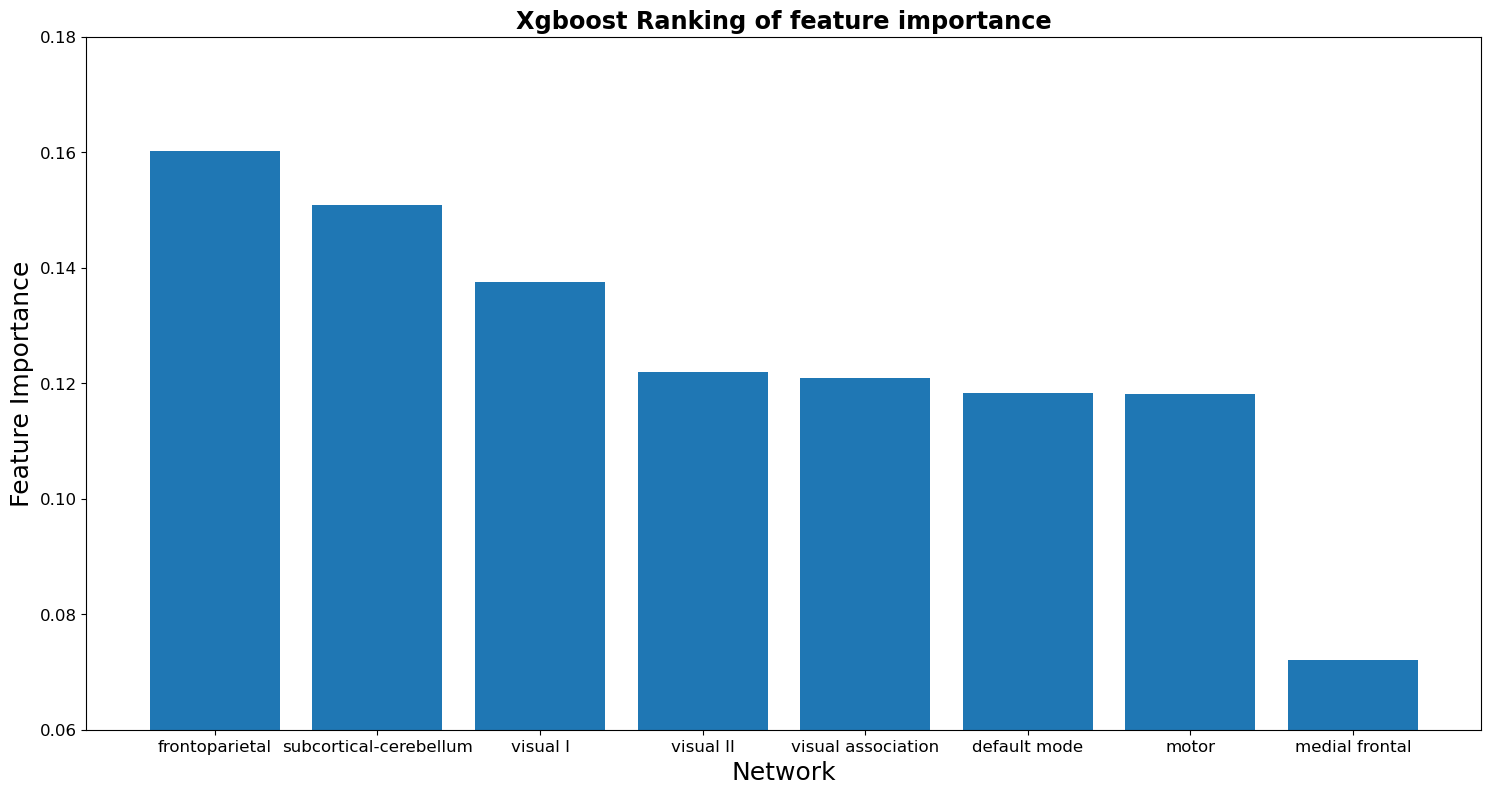

In [21]:
# Sort importances
dict1_sorted_values = sorted(importance.items(),key = lambda x:x[1],reverse = True)
sorted_net = {k:v for k,v in dict1_sorted_values}
sum_imp = 0
for i in sorted_net.values():
    sum_imp += i
for i in sorted_net.keys():
    sorted_net[i] = sorted_net[i]/sum_imp
# Plot importances 
plt.figure(figsize=(18, 9))
plt.ylim(0.06,0.18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.bar(sorted_net.keys(), sorted_net.values())
plt.title('Xgboost Ranking of feature importance',fontsize='xx-large',fontweight='heavy')
plt.xlabel('Network',fontsize=18)
plt.ylabel('Feature Importance',fontsize=18)
plt.show()

In [8]:
for i in range(5):
    print(total_importance[i].values())

dict_values([0.11859740236509099, 0.16340682814556654, 0.08598311671469097, 0.1513890772925328, 0.1058253744180812, 0.1322817180226015, 0.1028857806842456, 0.13963070235719047])
dict_values([0.07927921205790182, 0.17581331144605283, 0.06897291449037457, 0.16604590525460547, 0.10116027458588271, 0.1532731433119435, 0.05109104777064783, 0.20436419108259132])
dict_values([0.07642560785920705, 0.1489978237255129, 0.10685937670314129, 0.1530331814514122, 0.10131852013334877, 0.15391268249423642, 0.0967451147106629, 0.16270769292247847])
dict_values([0.08288193889565815, 0.13633730704895025, 0.07725780732773849, 0.16596121574106784, 0.08927568846760892, 0.13353201266522702, 0.15260801447454514, 0.16214601537920423])
dict_values([0.09991645058237658, 0.15979285295343312, 0.06338449833819514, 0.1529276785302486, 0.10141519734111223, 0.15091547223379798, 0.06036618889351918, 0.21128166112731717])


In [9]:
print(sum_acc/67,sum_pre/67,sum_rec/67,sum_f1/67)

0.6019900497512438 0.4776119402985074 0.6019900497512438 0.5165837479270319


In [10]:
import math
cnt = 0
net_variance = np.zeros(8)
net_score = np.zeros(8)
for i in range(8):
    for j in range(67):
        net_score[i] += total_sorted_importance[j][net_name[i]]
    net_score[i] /= 67
    
for i in range(8):
    for j in range(67):
        net_variance[i] += math.pow((total_sorted_importance[j][net_name[i]] - net_score[i]),2)
    net_variance[i] /= 67
    net_variance[i] = math.sqrt(net_variance[i])


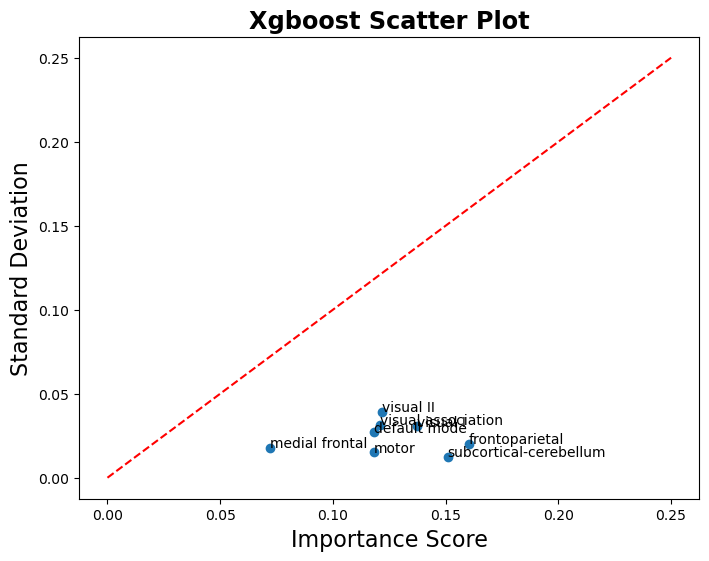

[0.07203828 0.16022166 0.11834955 0.15089084 0.11819719 0.13748023
 0.1219779  0.12084436]
[0.01784162 0.02029899 0.02716695 0.01253046 0.01525448 0.03057714
 0.03931118 0.0314663 ]


In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(net_score,net_variance)
#plt.plot([0, 0, 0, 0])
for i, name in enumerate(['medial frontal','frontoparietal','default mode','subcortical-cerebellum','motor','visual I','visual II','visual association']):
    plt.annotate(name,(net_score[i],net_variance[i]))
plt.title('Xgboost Scatter Plot',fontsize='xx-large',fontweight='heavy')
plt.xlabel('Importance Score',fontsize=16)
plt.ylabel('Standard Deviation',fontsize=16)
x_line = np.linspace(0,0.25)
y_line = x_line
plt.plot(x_line, y_line, 'r--')
plt.show()
print(net_score)
print(net_variance)